## Import modules and functions

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import glob
import re
import os

import pylab as pl
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from scipy.signal import savgol_filter

from matplotlib.gridspec    import GridSpec
import import_ipynb

import Module_Diagnostics as MD
import numpy as np
from tempfile import mkdtemp
import os.path as path
import sys

from pathlib import Path
import json

#Debugger. For some reason, using it inside a function works well. Otherwise...
from IPython.core.debugger import set_trace
#exemple: 
# def debug():
#     set_trace()
    
#     `code_to_debug`
    
#     return

# debug()

importing Jupyter notebook from Module_Diagnostics.ipynb
testing compute_RMS(...):
This should be close to 1: 1.0055953065476992
This should be close to 0: 0.0


## Choose run

In [2]:
run_name = 'RUN_NAME'

### Only if working on lx-moissard
Cluster = 'Occ/'
run_name = '20_08_18_new_big_one_0'
filepath = '/data/Lathys/Visualisation/' + Cluster + run_name + '/ncfiles/'
# filepath = '../ncfiles'

#This is used by the functions find_ip_shock(N, V) and find_mc_leading_edge(B)
metadata = {'t_shock_entrance' : 130,
            't_shock_exit'     : 240,
            't_MC_entrance'    : 130,
            't_MC_exit'        : 270}
#todo: autodefine t_collision? maybe from story_reader will be easier, as lines will cross on the multivariate plot

from_time = 210
to_time = 220 #metadata['t_shock_exit']

date = re.search('Magw_(.+?)_t', glob.glob(filepath+'Magw*_t'+ '%05d' % from_time +'.nc')[0]).group(1) 

print(f'date of the simulation (DD_MM_YY): {date}')

date of the simulation (DD_MM_YY): 18_08_20


In [3]:
storing_directory_json = filepath + "../shock_tracking/"
#The next line links directly to my PhD_Manuscript on Overleaf.com
#Saving plots there means that I do not need to worry about having the very last version before
#starting to write about it in Overleaf, since it will always be up to date.
dropbox = os.environ['DROPBOX']
dropbox_dir = dropbox + "/Apps/Overleaf/PhD_Manuscript/Images/LATHYS"

path_store_json = Path(storing_directory_json)

if not(path_store_json.exists()):
    os.system(f'mkdir {path_store_json}')

name = "shock_tracking_" + run_name + ".json"
name = "shock_tracking_occ.json"
path_json = Path(storing_directory_json + name)

In [4]:
with open(path_json, "r", encoding='utf-8') as shock_tracking:
            stored_data = json.load(shock_tracking)

In [5]:
stored_data.keys()

dict_keys(['00210', 'x', 'y', 'z', '00211', '00212', '00213', '00214', '00215', '00216', '00217', '00218', '00219', '00220', '00221', '00222', '00223', '00224', '00225', '00226', '00227', '00228', '00229', '00230', '00231', '00232', '00233', '00234', '00235', '00236', '00237', '00238', '00239'])

In [6]:
stored_data['00210'].keys()

dict_keys(['Vx', 'Vy', 'Vz'])

In [7]:
stored_data['00210']['Vx'].keys()

dict_keys(['(xy) plane', '(xz) plane'])

In [8]:
stored_data['00210']['Vx']['(xy) plane'].keys()

dict_keys(['y = -300.0', 'y = -100.0', 'y = -90.0', 'y = -80.0', 'y = -70.0', 'y = -0.0', 'y = 70.0', 'y = 80.0', 'y = 90.0', 'y = 100.0', 'y = 300.0'])

## Def functions

In [9]:
x = np.array(stored_data['x'])
y = np.array(stored_data['y'])
z = np.array(stored_data['z'])

In [10]:
from scipy import signal
from collections.abc import Iterable

def simplified_find_ip_shock(V, test=None, first_point=False, verbose=False):
    
    Vx, Vy, Vz = tuple(V)    

    v_slice = np.sqrt( np.array(Vx)**2
                      +np.array(Vy)**2
                      +np.array(Vz)**2 ) 
    grad_v = np.gradient(v_slice)
    
    #Be careful, this test is very arbitrary. Works for the dataset I'm using.
    large_grad_v = [True if (grad_v[i] > 100*np.nanmean(grad_v)) else False for i in range(0,len(grad_v))]
    
    if not(test):
        test = large_grad_v
        
    if test:
        test = np.array(test) * np.array(large_grad_v)
                     
    ix_is = first_largest(grad_v, grad_v[test], verbose=verbose)   
    if np.isnan(ix_is):
        return np.nan
    x_is = x[ix_is]    
    
    if isinstance(x_is, Iterable):
        x_is = x_is[0]
        
    print("grad_v[ix_is] = ", grad_v[ix_is])

    return x_is

def simplified_check_for_absurdities(list_pos, V, first_estimation=None, verbose=False, info=None):
   
    maximum_expected_change = 13
    minimum_expected_change = 2
    
    if info=='slow':
        maximum_expected_change = 8
    
    if first_estimation:
        prev_position = first_estimation
        maximum_expected_change = 20
        minimum_expected_change = 0
    else:
        prev_position = list_pos[-2]
        
    position = list_pos[-1]
    
    absurd = False
    test = np.ones(len(V))*True
    if ( abs(prev_position - position) > maximum_expected_change or 
         abs(position - prev_position) < minimum_expected_change or
         position > prev_position ) :
        absurd = True
        if verbose:
            print(f'''This is absurd, the ip shock was located at {prev_position} 
                      and now it would be at {position}!''')
        test = [True if (prev_position - maximum_expected_change 
                         <  x[i]  < 
                         prev_position - minimum_expected_change) else False for i in range(0, len(V[0]))]
    else:
        if verbose:
            print("Sounds like a good position for the ip shock")

    return {'absurd': absurd, 'test': test, 'prev_position': prev_position, 'position': position}


def first_largest(list1, sub_list1, verbose=False):
    '''
    This function extracts the three largest local maxima 
    from sub_list1.
    Then, it finds the one with the smallest x
    '''
    tmp = list(sub_list1.copy())
    three_largest = []
        
    try:
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
        c1 = x[np.where(list1 == three_largest[0])][0]
    except ValueError:
        return np.nan    
    if all(np.isnan(tmp)) or not(tmp):
        candidates = [c1]
       
    c2_ok = False
    if tmp and not(all(np.isnan(tmp))):
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
    #at this point, we have the two largest local maximas
        c2 = x[np.where(list1 == three_largest[1])][0]
        c2_ok = True
        
    if tmp and not(all(np.isnan(tmp))):
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
        #at this point, we have the three largest local maximas    
        c3 = x[np.where(list1 == three_largest[2])][0]
        candidates = [c1, c2, c3]
    elif c2_ok:
        candidates = [c1, c2]

    index_first = candidates.index(min(candidates))
    index_first = MD.aplatir(np.where(x == candidates[index_first]))
    #Which of the two candidate has the smallest x
    
    if verbose:
        print(f'the chosen candidate for the position of the ip shock is {x[index_first]}')
    
    return index_first

## Trace Shock

In [11]:
verbose = True
rcParams["figure.figsize"] = [17, 8]

time = 00210
grad_v[ix_is] =  122.2272002637232
first try x_is = 109.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  136.5208844096146
first try x_is = 101.0
Sounds like a good position for the ip shock
time = 00212
grad_v[ix_is] =  122.58320804727566
first try x_is = 92.0
Sounds like a good position for the ip shock
time = 00213
grad_v[ix_is] =  124.19972358998041
first try x_is = 83.0
Sounds like a good position for the ip shock
time = 00214
grad_v[ix_is] =  112.25755480363804
first try x_is = 74.0
Sounds like a good position for the ip shock
time = 00215
grad_v[ix_is] =  122.42269955827993
first try x_is = 65.0
Sounds like a good position for the ip shock
time = 00216
grad_v[ix_is] =  130.60078289078015
first try x_is = 56.0
Sounds like a good position for the ip shock
time = 00217
grad_v[ix_is] =  132.364275694511
first try x_is = 47.0
Sounds like a good position for the ip shock
time = 00218
grad_v[ix_is] =  106.94883083280598
first try x_is = 38.0
Sou

grad_v[ix_is] =  90.6144332373714
first try x_is = -56.0
Sounds like a good position for the ip shock
time = 00231
grad_v[ix_is] =  71.9240825239039
first try x_is = -64.0
Sounds like a good position for the ip shock
time = 00232
grad_v[ix_is] =  73.61695825625814
first try x_is = -99.0
This is absurd, the ip shock was located at -64.0 
                      and now it would be at -99.0!
the chosen candidate for the position of the ip shock is -72.0
grad_v[ix_is] =  49.895547532330426
Sounds like a good position for the ip shock
time = 00233
grad_v[ix_is] =  78.22676980368794
first try x_is = -79.0
Sounds like a good position for the ip shock
time = 00234
grad_v[ix_is] =  98.0270803146409
first try x_is = -87.0
Sounds like a good position for the ip shock
time = 00235
time = 00236
time = 00237
time = 00238
time = 00239
time = x
time = y
time = z
time = 00210
grad_v[ix_is] =  107.26097395001653
first try x_is = 108.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is

grad_v[ix_is] =  150.4659675060259
first try x_is = -77.0
This is absurd, the ip shock was located at 15.0 
                      and now it would be at -77.0!
the chosen candidate for the position of the ip shock is 8.0
grad_v[ix_is] =  80.51274459683383
Sounds like a good position for the ip shock
time = 00223
grad_v[ix_is] =  251.69540510977583
first try x_is = -55.0
This is absurd, the ip shock was located at 8.0 
                      and now it would be at -55.0!
the chosen candidate for the position of the ip shock is -0.0
grad_v[ix_is] =  65.3239656190065
Sounds like a good position for the ip shock
time = 00224
grad_v[ix_is] =  97.4500593209894
first try x_is = -78.0
This is absurd, the ip shock was located at -0.0 
                      and now it would be at -78.0!
the chosen candidate for the position of the ip shock is -7.0
grad_v[ix_is] =  93.00609980701792
Sounds like a good position for the ip shock
time = 00225
grad_v[ix_is] =  93.38873709843716
first try x_is = -63.0


grad_v[ix_is] =  141.91508243133768
first try x_is = 66.0
Sounds like a good position for the ip shock
time = 00216
grad_v[ix_is] =  118.22052835419228
first try x_is = -55.0
This is absurd, the ip shock was located at 66.0 
                      and now it would be at -55.0!
the chosen candidate for the position of the ip shock is 57.0
grad_v[ix_is] =  136.33558265100586
Sounds like a good position for the ip shock
time = 00217
grad_v[ix_is] =  123.55396580737046
first try x_is = -49.0
This is absurd, the ip shock was located at 57.0 
                      and now it would be at -49.0!
the chosen candidate for the position of the ip shock is 48.0
grad_v[ix_is] =  124.0050604036098
Sounds like a good position for the ip shock
time = 00218
grad_v[ix_is] =  172.17717073591066
first try x_is = -65.0
This is absurd, the ip shock was located at 48.0 
                      and now it would be at -65.0!
the chosen candidate for the position of the ip shock is 39.0
grad_v[ix_is] =  102.9660686

the chosen candidate for the position of the ip shock is -45.0
grad_v[ix_is] =  51.40418755176145
Sounds like a good position for the ip shock
time = 00230
grad_v[ix_is] =  64.97139083801355
first try x_is = -75.0
This is absurd, the ip shock was located at -45.0 
                      and now it would be at -75.0!
the chosen candidate for the position of the ip shock is -54.0
grad_v[ix_is] =  35.62026434832012
Sounds like a good position for the ip shock
time = 00231
grad_v[ix_is] =  203.4206226413676
first try x_is = -83.0
This is absurd, the ip shock was located at -54.0 
                      and now it would be at -83.0!
the chosen candidate for the position of the ip shock is -66.0
grad_v[ix_is] =  71.76871284722273
Sounds like a good position for the ip shock
time = 00232
grad_v[ix_is] =  114.62792870323051
first try x_is = -93.0
This is absurd, the ip shock was located at -66.0 
                      and now it would be at -93.0!
the chosen candidate for the position of the ip 

grad_v[ix_is] =  105.42736466063533
first try x_is = 48.0
Sounds like a good position for the ip shock
time = 00218
grad_v[ix_is] =  143.72843918075827
first try x_is = 40.0
Sounds like a good position for the ip shock
time = 00219
grad_v[ix_is] =  119.47835898152599
first try x_is = 31.0
Sounds like a good position for the ip shock
time = 00220
grad_v[ix_is] =  144.17097719466253
first try x_is = 23.0
Sounds like a good position for the ip shock
time = 00221
grad_v[ix_is] =  150.78435806171234
first try x_is = 14.0
Sounds like a good position for the ip shock
time = 00222
grad_v[ix_is] =  140.66463615633097
first try x_is = 5.0
Sounds like a good position for the ip shock
time = 00223
grad_v[ix_is] =  141.38548430032432
first try x_is = -4.0
Sounds like a good position for the ip shock
time = 00224
grad_v[ix_is] =  115.41279997603735
first try x_is = -13.0
Sounds like a good position for the ip shock
time = 00225
grad_v[ix_is] =  146.8869164926738
first try x_is = -21.0
Sounds like a 

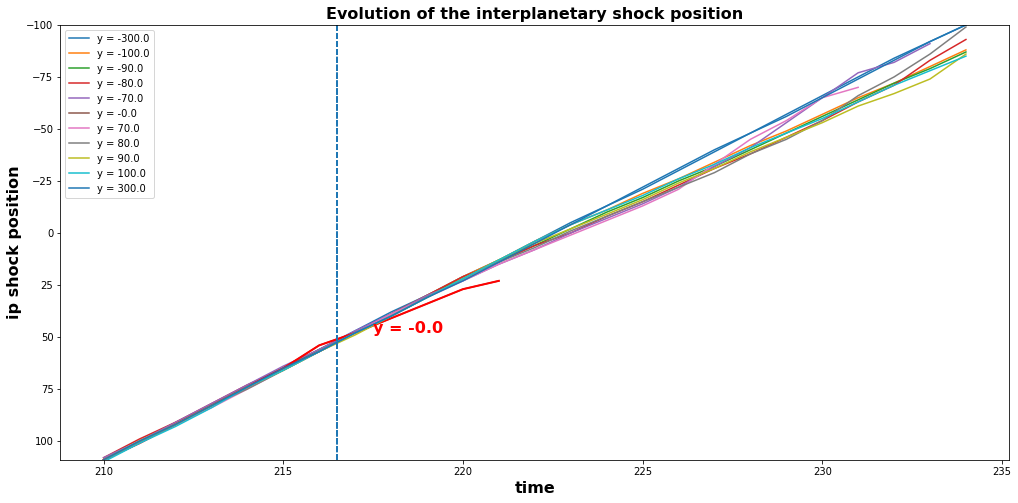

In [12]:
for y_slice in stored_data['00210']['Vx']['(xy) plane'].keys():

  
    t = []
    pos = []

    for time in sorted(stored_data):

        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()) or int(time)>=235:
            continue
  
            
        Vx_xy = stored_data[time]['Vx']['(xy) plane']
        Vy_xy = stored_data[time]['Vy']['(xy) plane']
        Vz_xy = stored_data[time]['Vz']['(xy) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (y_slice == 'y = -0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = Vx_xy[y_slice]
        Vy = Vy_xy[y_slice]
        Vz = Vz_xy[y_slice]
        
        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
        j = 0
        while absurdity['absurd']:
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break

                    
    if y_slice == 'y = -0.0':
        t_fig_y0 = t[:-2]
        pos_fig_y0 = pos[:-2]
    if y_slice == 'y = 90.0':
        t_fig_y = t[:-1]
        pos_fig_y = pos[:-1]
    if y_slice == 'y = -300.0':
        t_ref = t[:-1]
        pos_ref = pos[:-1]
        
        
    plt.plot(t, pos, label=y_slice)
    plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
    plt.ylim([max(pos), min(pos)])
    plt.ylabel('ip shock position', weight='bold', fontsize='16')
    plt.xlabel('time', weight='bold', fontsize='16')
    plt.axvline(216.5, linestyle='--', )
    
    if y_slice == 'y = -0.0':
        plt.plot(t, pos, color='red', linewidth=2) 
        plt.text(217.5,48, y_slice, color='red', weight='bold', fontsize='16')
        
plt.legend()
saving_title = "shock_tracking_xy"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

z = -300.0
time = 00210
grad_v[ix_is] =  130.6237194755408
first try x_is = 109.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  103.0921555379258
first try x_is = 100.0
Sounds like a good position for the ip shock
time = 00212
grad_v[ix_is] =  125.32294587793467
first try x_is = 92.0
Sounds like a good position for the ip shock
time = 00213
grad_v[ix_is] =  129.74265102393593
first try x_is = 84.0
Sounds like a good position for the ip shock
time = 00214
grad_v[ix_is] =  131.99743550308804
first try x_is = 75.0
Sounds like a good position for the ip shock
time = 00215
grad_v[ix_is] =  119.04659273208159
first try x_is = 66.0
Sounds like a good position for the ip shock
time = 00216
grad_v[ix_is] =  98.38773262723024
first try x_is = 57.0
Sounds like a good position for the ip shock
time = 00217
grad_v[ix_is] =  142.855635586086
first try x_is = 49.0
Sounds like a good position for the ip shock
time = 00218
grad_v[ix_is] =  145.17149985026734
first try x_is 

Sounds like a good position for the ip shock
z = -80.0
time = 00210
grad_v[ix_is] =  140.1926279350299
first try x_is = 109.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  137.67086606563842
first try x_is = 100.0
Sounds like a good position for the ip shock
time = 00212
grad_v[ix_is] =  121.6651548171485
first try x_is = 91.0
Sounds like a good position for the ip shock
time = 00213
grad_v[ix_is] =  100.05117767886358
first try x_is = 82.0
Sounds like a good position for the ip shock
time = 00214
grad_v[ix_is] =  145.341739836498
first try x_is = 74.0
Sounds like a good position for the ip shock
time = 00215
grad_v[ix_is] =  133.84352536481165
first try x_is = 65.0
Sounds like a good position for the ip shock
time = 00216
grad_v[ix_is] =  135.18303669814784
first try x_is = 56.0
Sounds like a good position for the ip shock
time = 00217
grad_v[ix_is] =  118.64600618590643
first try x_is = 47.0
Sounds like a good position for the ip shock
time = 00218
grad_v

grad_v[ix_is] =  85.26239141337777
first try x_is = -66.0
This is absurd, the ip shock was located at -50.0 
                      and now it would be at -66.0!
the chosen candidate for the position of the ip shock is -57.0
grad_v[ix_is] =  41.540412933118944
Sounds like a good position for the ip shock
time = 00231
grad_v[ix_is] =  114.1447361366713
first try x_is = -74.0
This is absurd, the ip shock was located at -57.0 
                      and now it would be at -74.0!
the chosen candidate for the position of the ip shock is -66.0
grad_v[ix_is] =  73.8032062649088
Sounds like a good position for the ip shock
time = 00232
grad_v[ix_is] =  229.08770581041637
first try x_is = -79.0
Sounds like a good position for the ip shock
time = 00233
grad_v[ix_is] =  98.96638804466266
first try x_is = -92.0
Sounds like a good position for the ip shock
time = 00234
grad_v[ix_is] =  149.0390196959391
first try x_is = -94.0
Sounds like a good position for the ip shock
time = 00235
grad_v[ix_is] =  

the chosen candidate for the position of the ip shock is 15.0
grad_v[ix_is] =  92.95997000610552
Sounds like a good position for the ip shock
time = 00222
grad_v[ix_is] =  108.4472656523599
first try x_is = 7.0
Sounds like a good position for the ip shock
time = 00223
grad_v[ix_is] =  121.53309090220324
first try x_is = -1.0
Sounds like a good position for the ip shock
time = 00224
grad_v[ix_is] =  219.76154168147198
first try x_is = -44.0
This is absurd, the ip shock was located at -1.0 
                      and now it would be at -44.0!
the chosen candidate for the position of the ip shock is -11.0
grad_v[ix_is] =  147.98686394624366
Sounds like a good position for the ip shock
time = 00225
grad_v[ix_is] =  141.3110317056172
first try x_is = -43.0
This is absurd, the ip shock was located at -11.0 
                      and now it would be at -43.0!
the chosen candidate for the position of the ip shock is -23.0
grad_v[ix_is] =  57.270076101959546
Sounds like a good position for the i

grad_v[ix_is] =  139.53893716591256
first try x_is = 100.0
Sounds like a good position for the ip shock
time = 00212
grad_v[ix_is] =  151.14215864182967
first try x_is = 91.0
Sounds like a good position for the ip shock
time = 00213
grad_v[ix_is] =  135.9114039901157
first try x_is = 82.0
Sounds like a good position for the ip shock
time = 00214
grad_v[ix_is] =  108.29595113714467
first try x_is = 73.0
Sounds like a good position for the ip shock
time = 00215
grad_v[ix_is] =  140.74733865015446
first try x_is = 65.0
Sounds like a good position for the ip shock
time = 00216
grad_v[ix_is] =  118.14334643741321
first try x_is = 56.0
Sounds like a good position for the ip shock
time = 00217
grad_v[ix_is] =  83.68307279214687
first try x_is = 47.0
Sounds like a good position for the ip shock
time = 00218
grad_v[ix_is] =  139.68551834342063
first try x_is = 39.0
Sounds like a good position for the ip shock
time = 00219
grad_v[ix_is] =  123.78554502854067
first try x_is = 30.0
Sounds like a g

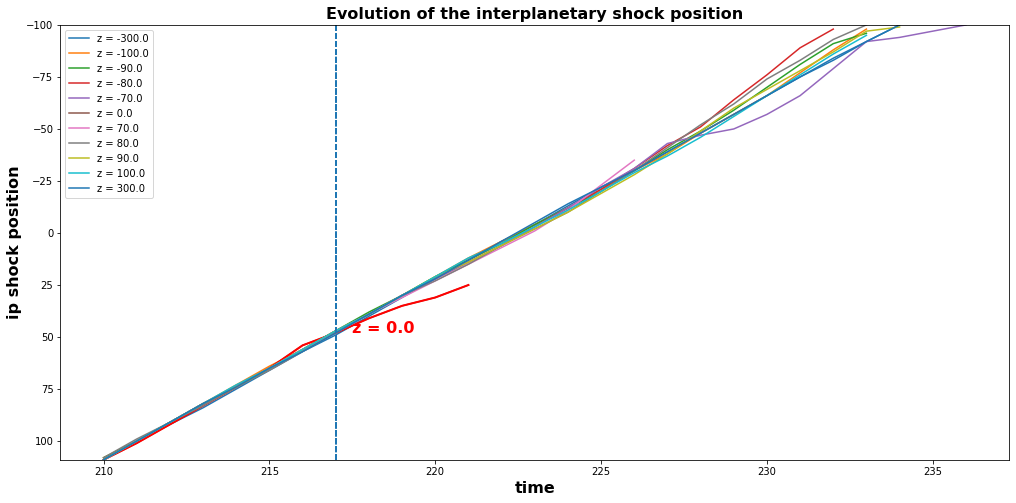

In [13]:
for z_slice in stored_data['00210']['Vx']['(xz) plane'].keys():

    if z_slice == 'z = -0.0':
        continue
        # plt.plot(t, pos, color='red', linewidth=2) 
        # plt.text(217.5,48, y_slice, color='red', weight='bold', fontsize='16')
 
    if verbose:
        print(z_slice)

    t = []
    pos = []

    for time in sorted(stored_data):

        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue
            
        Vx_xz = stored_data[time]['Vx']['(xz) plane']
        Vy_xz = stored_data[time]['Vy']['(xz) plane']
        Vz_xz = stored_data[time]['Vz']['(xz) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (z_slice == 'z = 0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = Vx_xz[z_slice]
        Vy = Vy_xz[z_slice]
        Vz = Vz_xz[z_slice]
        
        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info)
        j = 0
        while absurdity['absurd']:
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break
 
        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break


    if z_slice == 'z = 80.0':
        t_fig_z = t[:-1]
        pos_fig_z = pos[:-1]


    plt.plot(t, pos, label=z_slice)
    plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
    plt.ylim([max(pos), min(pos)])
    plt.ylabel('ip shock position', weight='bold', fontsize='16')
    plt.xlabel('time', weight='bold', fontsize='16')
    plt.axvline(217, linestyle='--', )

    if z_slice == 'z = 0.0':
        plt.plot(t, pos, color='red', linewidth=2) 
        plt.text(217.5,48, z_slice, color='red', weight='bold', fontsize='16')
        
plt.legend()
saving_title = "shock_tracking_xz"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Figures for publication

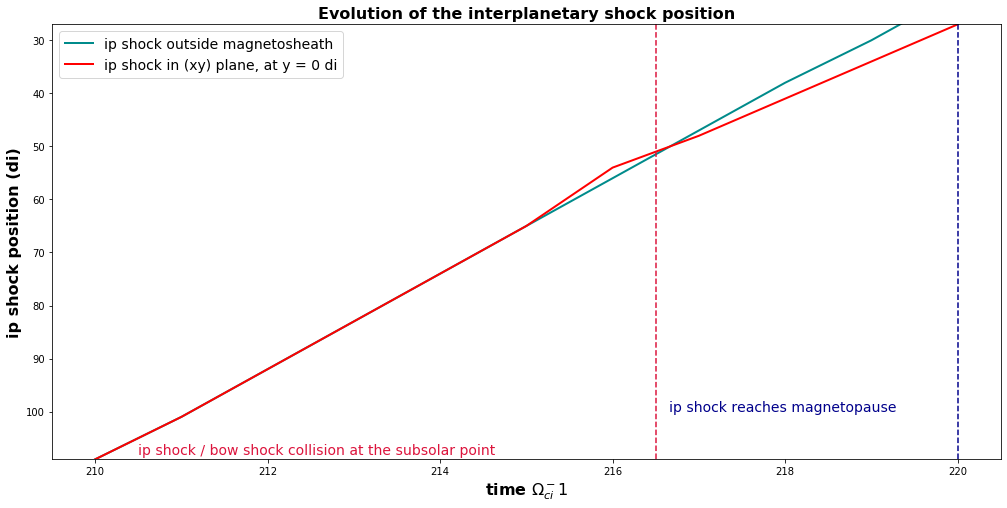

In [14]:
'''''''''''''''''''''''
Figure for publication
'''''''''''''''''''''''

plt.plot(t_fig_y0 , pos_ref[0:len(t_fig_y0)]    , label='ip shock outside magnetosheath'
         , color = "darkcyan", linewidth=2.0)
plt.plot(t_fig_y0 , pos_fig_y0 , label='ip shock in (xy) plane, at y = 0 di', linewidth=2.0, color='red')
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_fig_y0), min(pos_fig_y0)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='crimson')
plt.text(210.5,108, 'ip shock / bow shock collision at the subsolar point', color='crimson', fontsize=14)
plt.axvline(220, linestyle='--', color='darkblue')
plt.text(216.65,100, 'ip shock reaches magnetopause', color='darkblue', fontsize=14)
plt.legend(fontsize=14)
saving_title = "shock_tracking_pretty_bs_to_mp"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

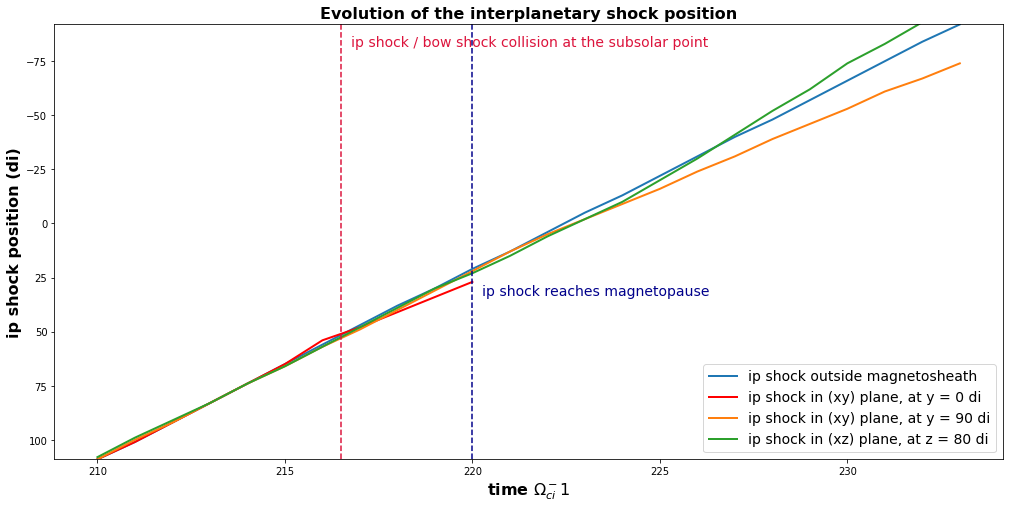

In [15]:
'''''''''''''''''''''''
Figure for publication
'''''''''''''''''''''''

plt.plot(t_ref    , pos_ref    , label='ip shock outside magnetosheath', linewidth=2.0)
plt.plot(t_fig_y0 , pos_fig_y0 , label='ip shock in (xy) plane, at y = 0 di', linewidth=2.0, color='red')
plt.plot(t_fig_y  , pos_fig_y  , label='ip shock in (xy) plane, at y = 90 di', linewidth=2.0)
plt.plot(t_fig_z  , pos_fig_z  , label='ip shock in (xz) plane, at z = 80 di', linewidth=2.0)
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_ref), min(pos_ref)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='crimson')
plt.text(216.75,-82, 'ip shock / bow shock collision at the subsolar point', color='crimson', fontsize=14)
plt.axvline(220, linestyle='--', color='darkblue')
plt.text(220.25,33, 'ip shock reaches magnetopause', color='darkblue', fontsize=14)
plt.legend(fontsize=14)
saving_title = "shock_tracking_pretty"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

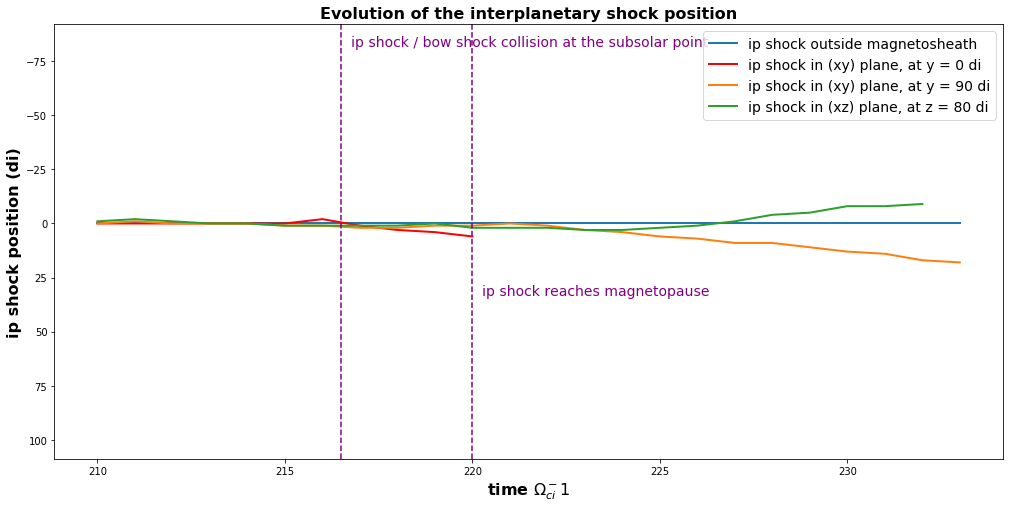

In [16]:
plt.plot(t_ref    , 0*np.array(t_ref)    , label='ip shock outside magnetosheath', linewidth=2.0)
plt.plot(t_fig_y0 , np.array(pos_fig_y0) - np.array(pos_ref)[0:len(pos_fig_y0)] , label='ip shock in (xy) plane, at y = 0 di', linewidth=2.0, color='red')
plt.plot(t_fig_y  , np.array(pos_fig_y)  - np.array(pos_ref), label='ip shock in (xy) plane, at y = 90 di', linewidth=2.0)
plt.plot(t_fig_z  , np.array(pos_fig_z)  - np.array(pos_ref)[0:len(pos_fig_z)], label='ip shock in (xz) plane, at z = 80 di', linewidth=2.0)
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_ref), min(pos_ref)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='purple')
plt.text(216.75,-82, 'ip shock / bow shock collision at the subsolar point', color='purple', fontsize=14)
plt.axvline(220, linestyle='--', color='purple')
plt.text(220.25,33, 'ip shock reaches magnetopause', color='purple', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Test 

grad_v[ix_is] =  122.2272002637232


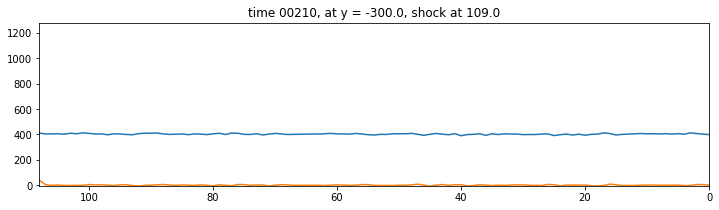

grad_v[ix_is] =  136.5208844096146


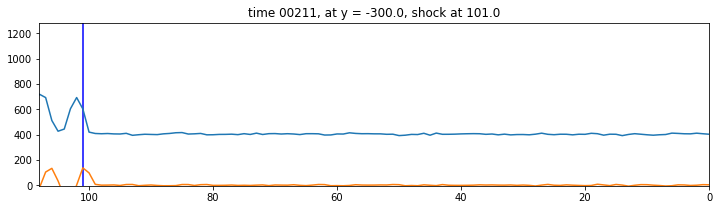

grad_v[ix_is] =  122.58320804727566


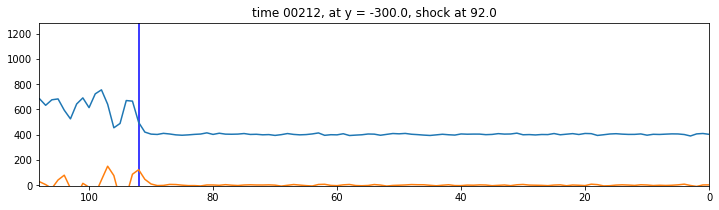

grad_v[ix_is] =  124.19972358998041


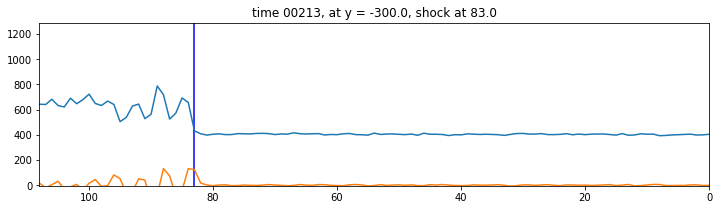

grad_v[ix_is] =  112.25755480363804


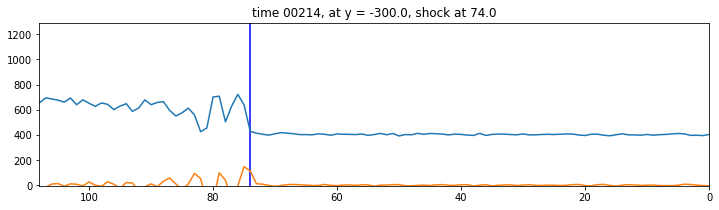

grad_v[ix_is] =  122.42269955827993


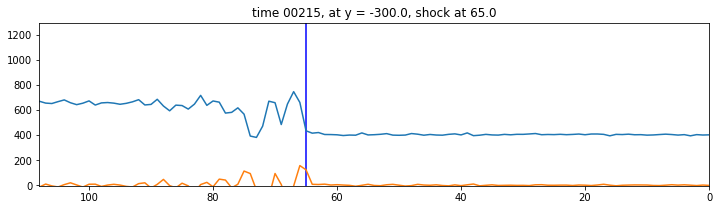

grad_v[ix_is] =  130.60078289078015


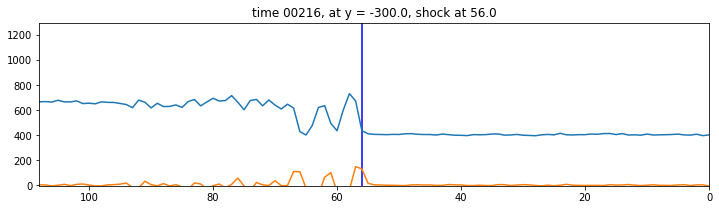

grad_v[ix_is] =  132.364275694511


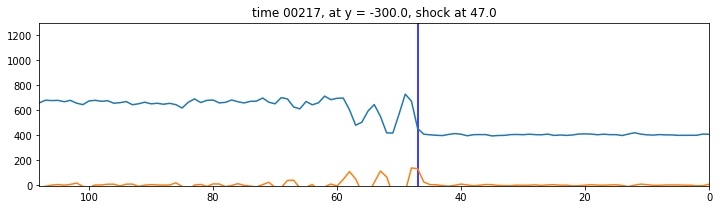

grad_v[ix_is] =  106.94883083280598


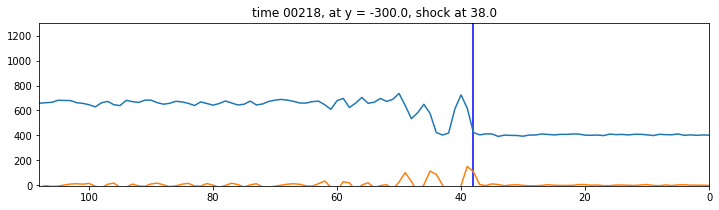

grad_v[ix_is] =  132.03841805939982


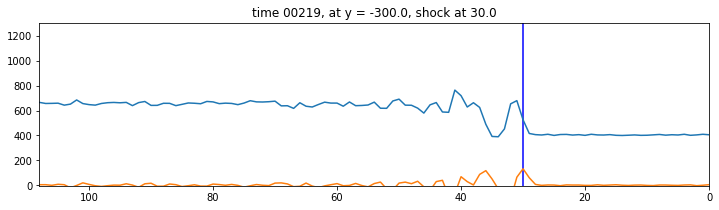

grad_v[ix_is] =  120.61226161427766


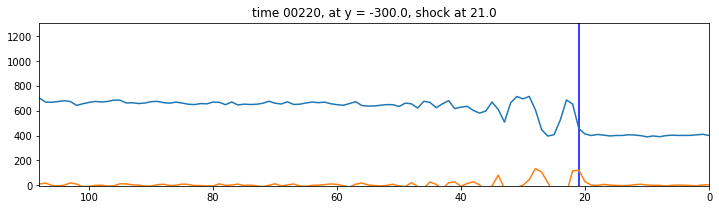

grad_v[ix_is] =  138.04557451681606


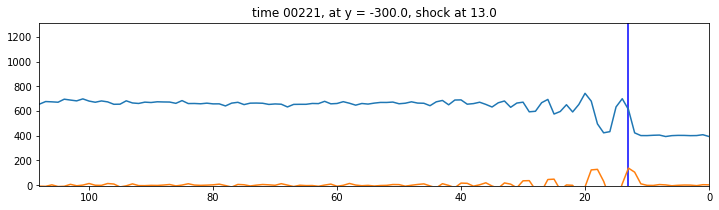

grad_v[ix_is] =  131.70512437187384


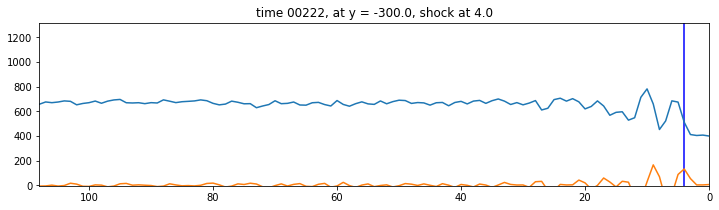

grad_v[ix_is] =  119.46346597215174


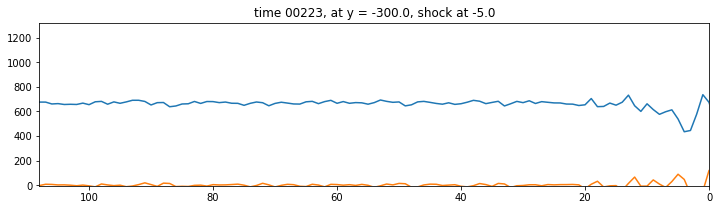

grad_v[ix_is] =  134.8690489961867


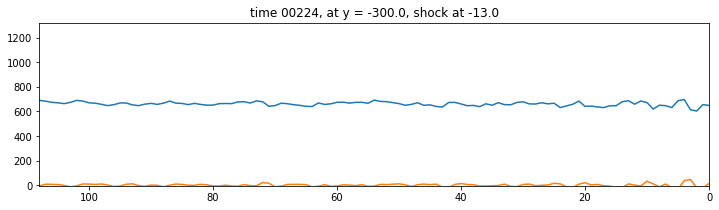

grad_v[ix_is] =  136.79716617278822


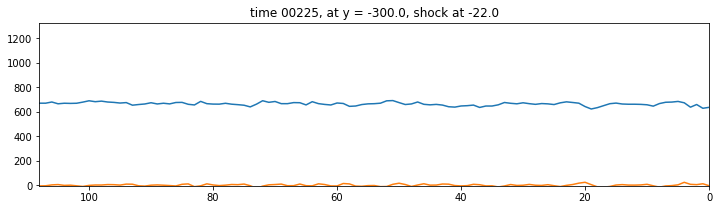

grad_v[ix_is] =  127.26870159876185


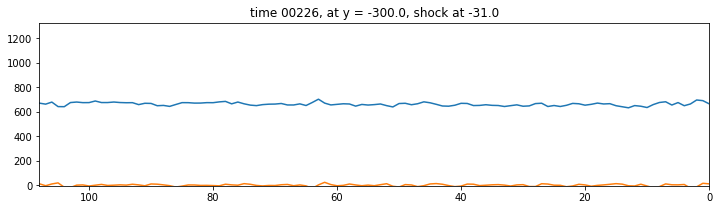

grad_v[ix_is] =  104.97367241034553


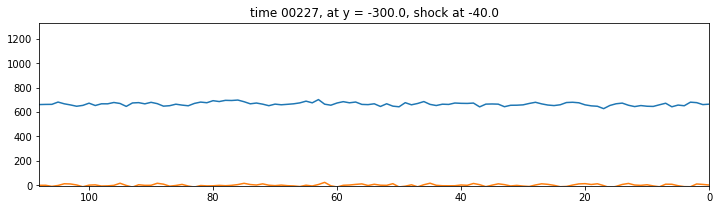

grad_v[ix_is] =  137.13228666699723


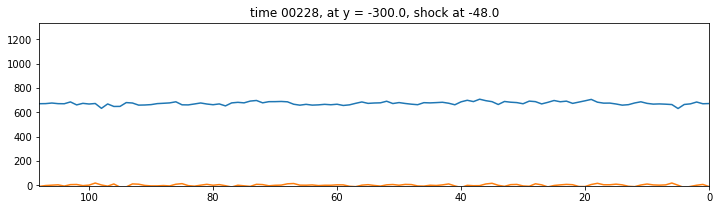

grad_v[ix_is] =  125.61823651204458


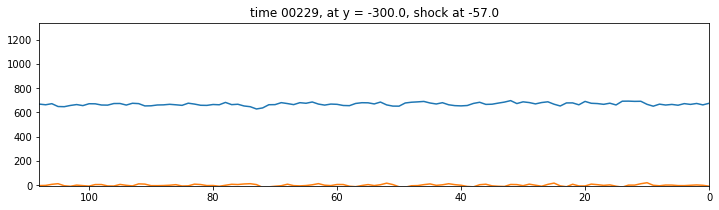

grad_v[ix_is] =  122.78438228309454


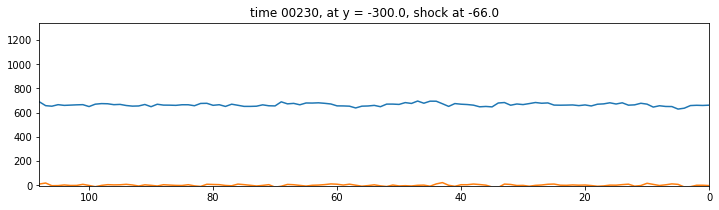

grad_v[ix_is] =  90.68893643425397


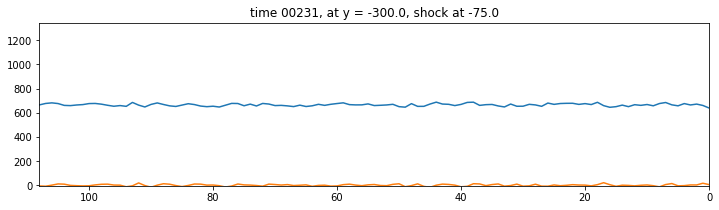

grad_v[ix_is] =  86.48564376799561


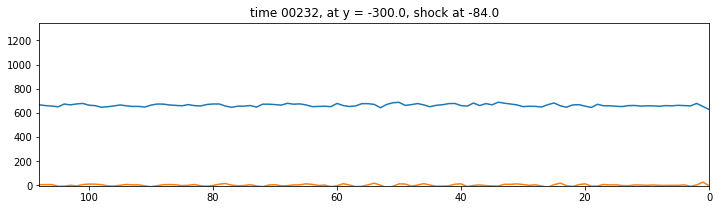

grad_v[ix_is] =  129.6330532977307


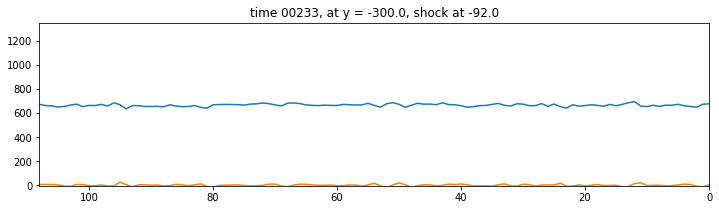

grad_v[ix_is] =  142.0362022652299


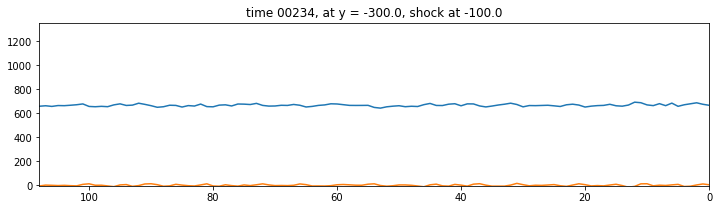

grad_v[ix_is] =  93.01779190951385
[]


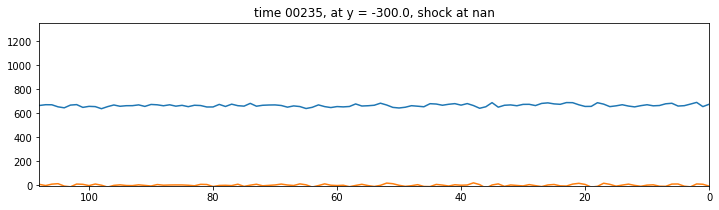

grad_v[ix_is] =  41.04467755259668


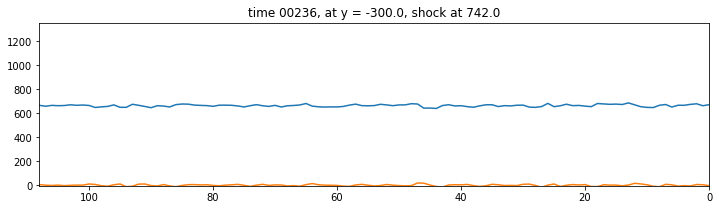

grad_v[ix_is] =  41.35669869183681


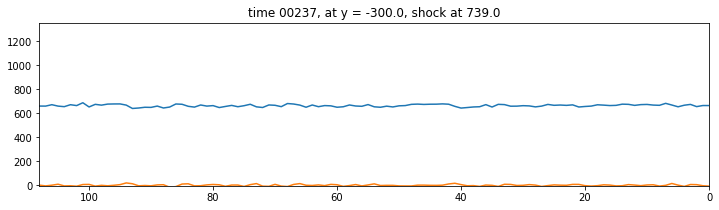

grad_v[ix_is] =  46.80703912279233


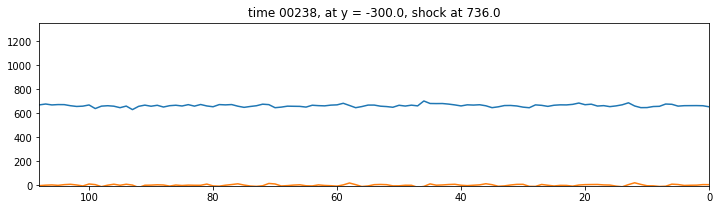

grad_v[ix_is] =  46.688160703628284


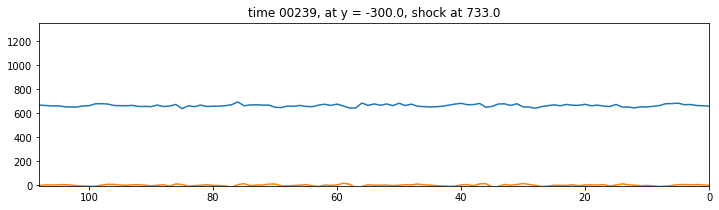

grad_v[ix_is] =  141.8611136706432


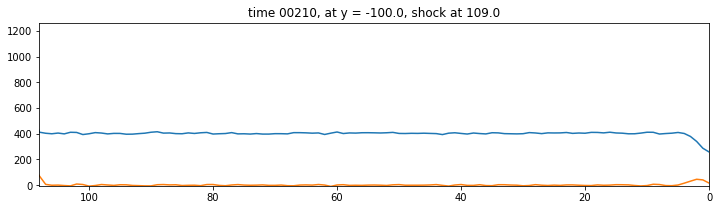

grad_v[ix_is] =  139.66234899305107


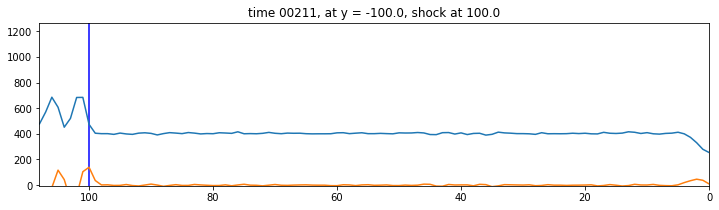

grad_v[ix_is] =  103.28845082635746


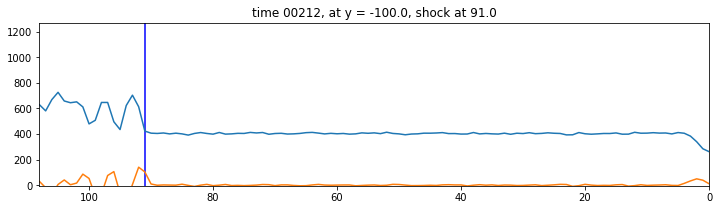

grad_v[ix_is] =  137.96132045232537


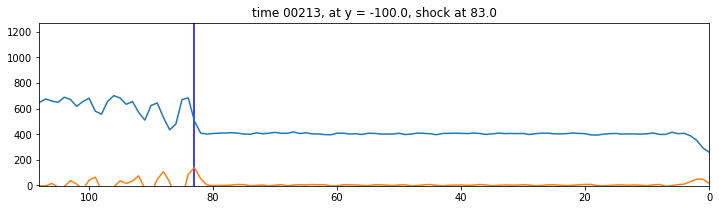

grad_v[ix_is] =  112.35305228402146


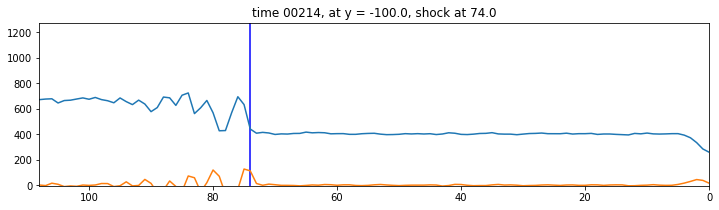

grad_v[ix_is] =  136.5854512380009


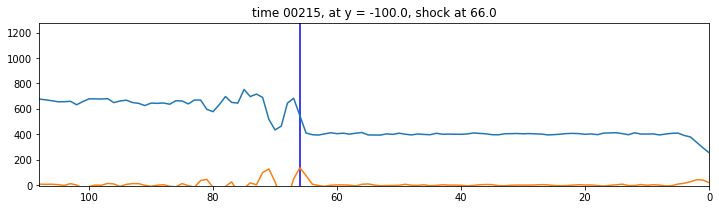

grad_v[ix_is] =  123.93749812208856


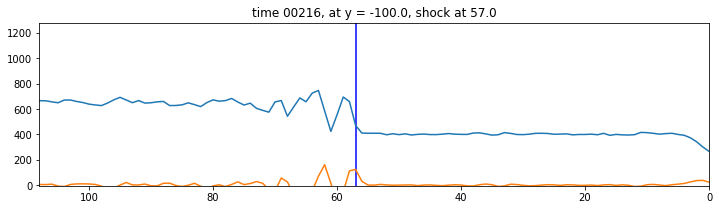

grad_v[ix_is] =  109.0158419104973


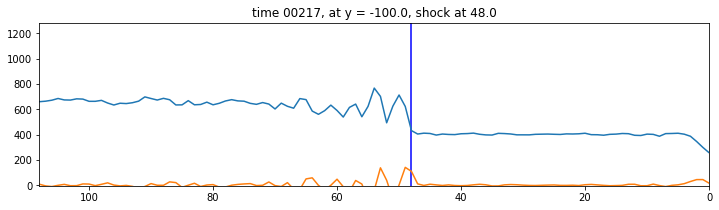

grad_v[ix_is] =  106.21727076884241


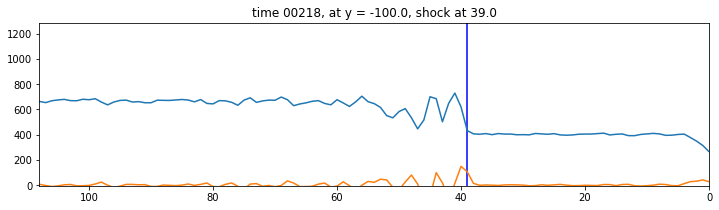

grad_v[ix_is] =  113.28428473706373


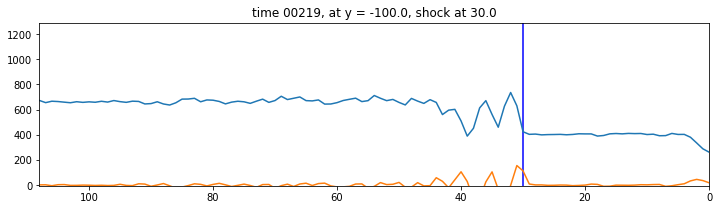

grad_v[ix_is] =  103.0930729724135


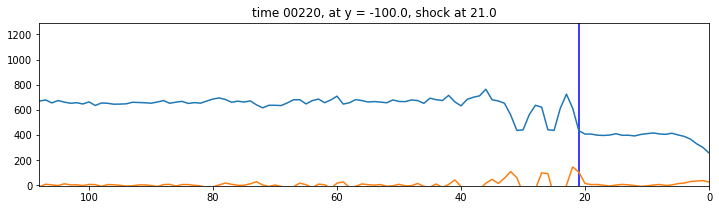

grad_v[ix_is] =  144.39165230159685


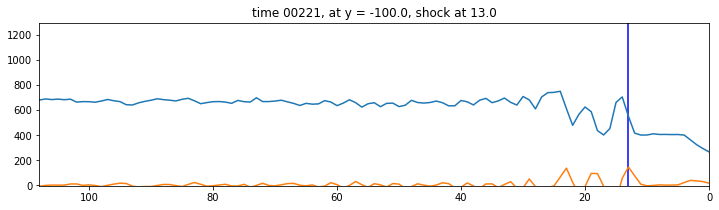

grad_v[ix_is] =  168.48013199039565


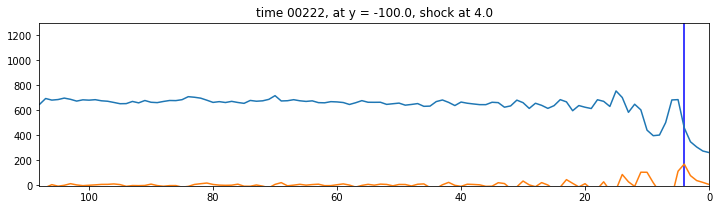

grad_v[ix_is] =  114.99155365951265


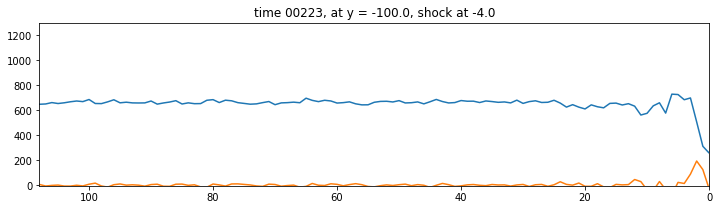

grad_v[ix_is] =  112.36176669032784


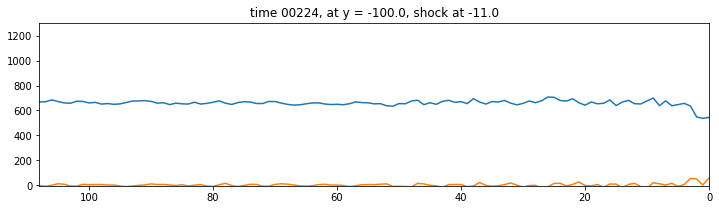

grad_v[ix_is] =  76.76458624321083


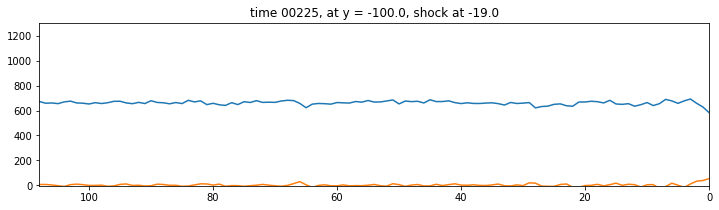

grad_v[ix_is] =  109.9144653368995


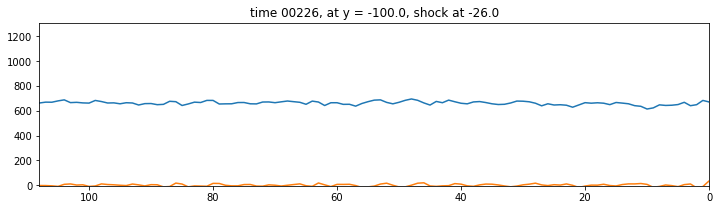

grad_v[ix_is] =  112.98534334155778


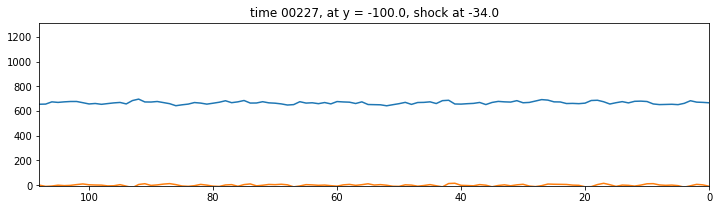

grad_v[ix_is] =  98.12908572396353


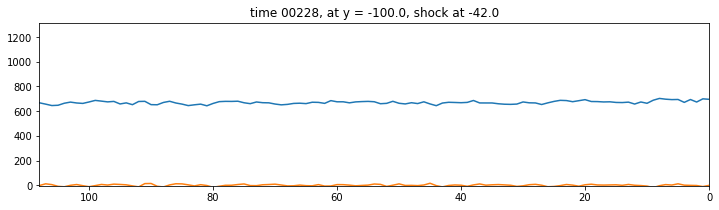

grad_v[ix_is] =  99.10543374299698


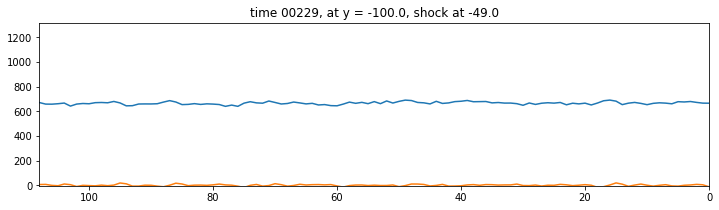

grad_v[ix_is] =  93.82955736447818


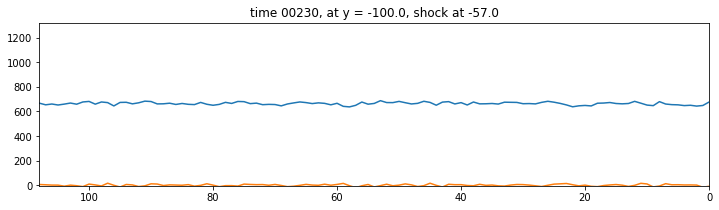

grad_v[ix_is] =  78.97377789719192


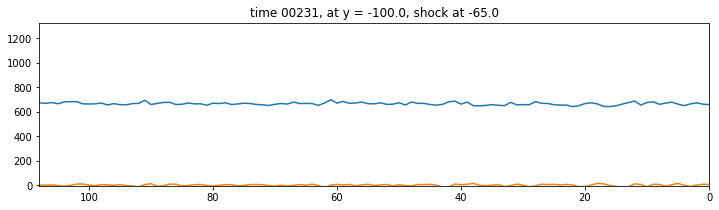

grad_v[ix_is] =  93.27838942544895


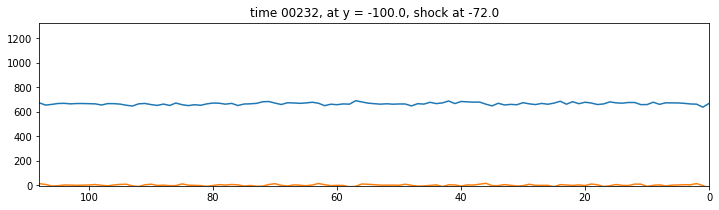

grad_v[ix_is] =  117.88737620061835


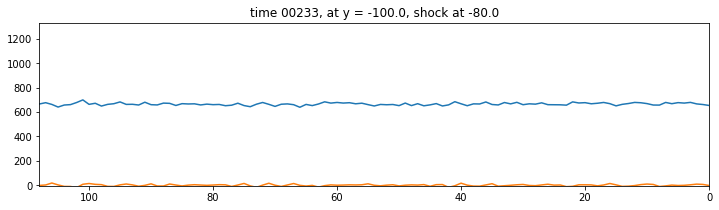

grad_v[ix_is] =  112.6692400113817


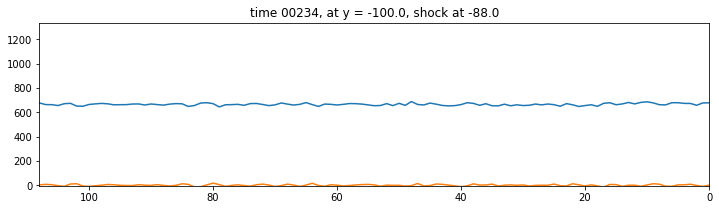

grad_v[ix_is] =  102.58289198816428


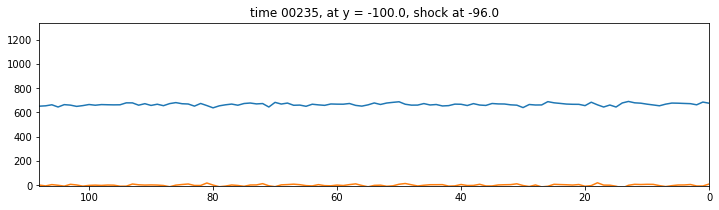

grad_v[ix_is] =  58.08184730968168
[-102. -101. -100.  -99.]


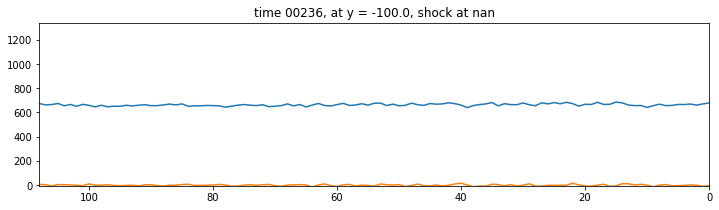

grad_v[ix_is] =  50.62005442034621


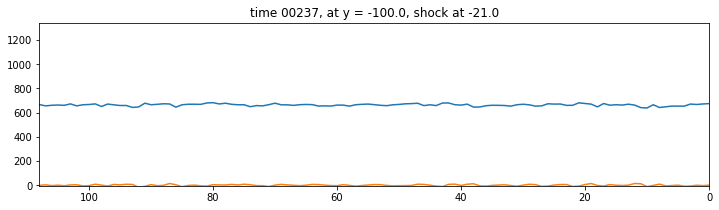

grad_v[ix_is] =  52.40978059615986


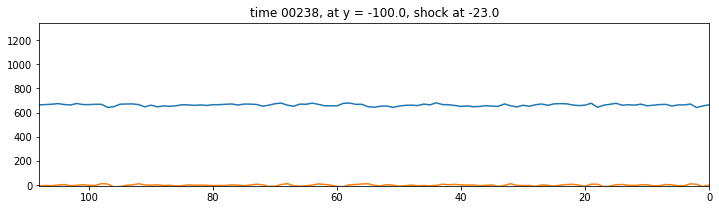

grad_v[ix_is] =  50.96672071572368


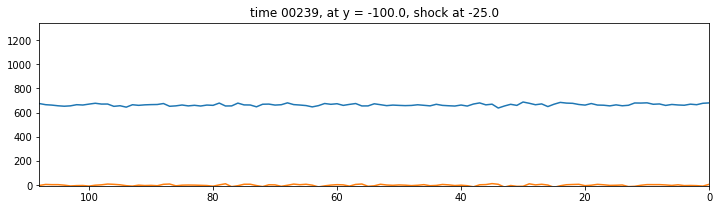

grad_v[ix_is] =  124.7500900236046


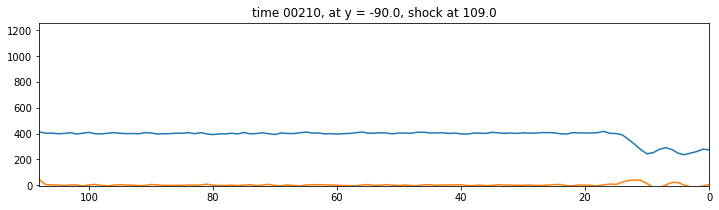

grad_v[ix_is] =  99.35478443644442


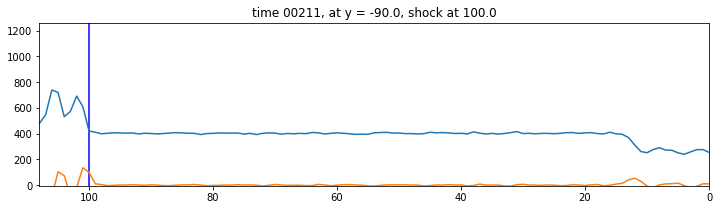

grad_v[ix_is] =  146.50286172767773


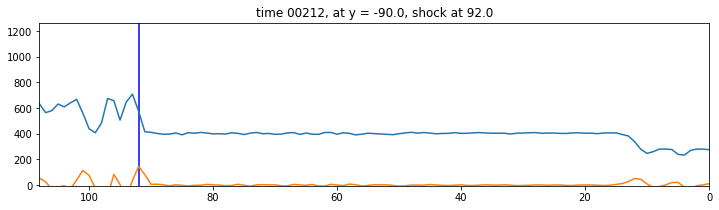

grad_v[ix_is] =  143.48847146409292


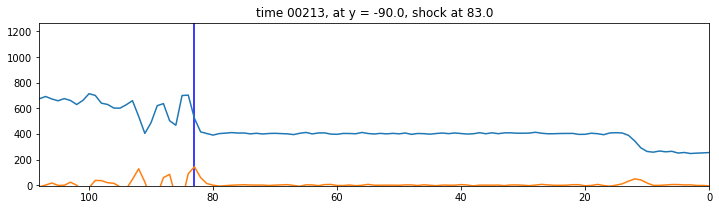

grad_v[ix_is] =  140.78212797950832


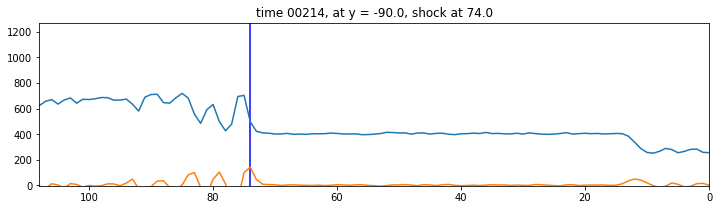

grad_v[ix_is] =  139.54862007088494


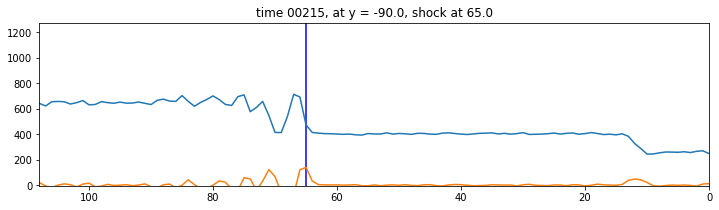

grad_v[ix_is] =  116.3082088849998


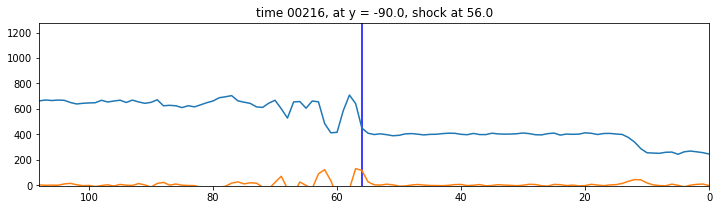

grad_v[ix_is] =  141.4680375852742


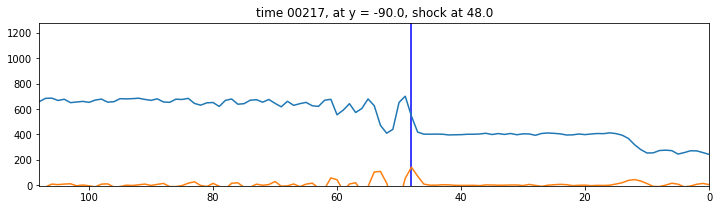

grad_v[ix_is] =  124.10834840407247


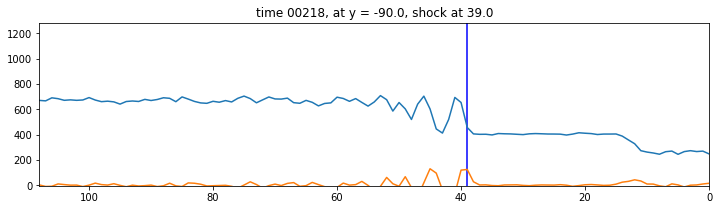

grad_v[ix_is] =  83.79388449862401


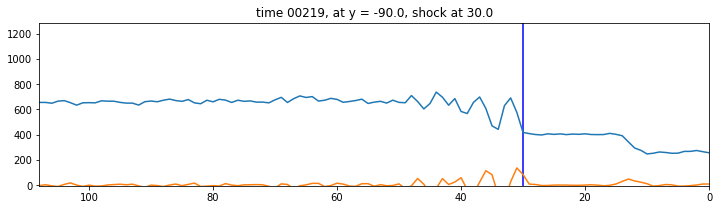

grad_v[ix_is] =  125.91521086087786


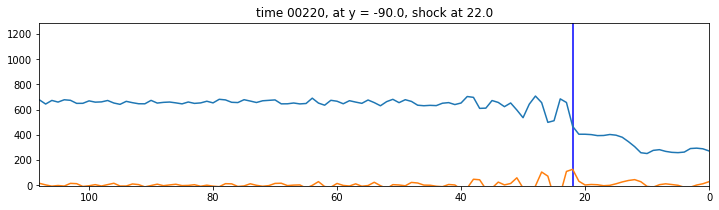

grad_v[ix_is] =  145.65640873976645


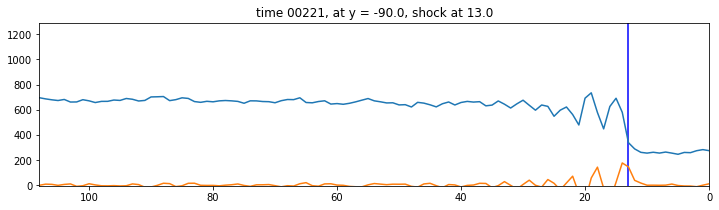

grad_v[ix_is] =  132.58187287321806


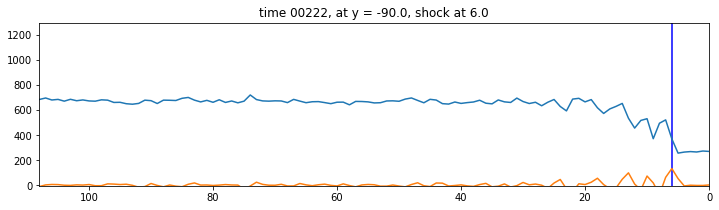

grad_v[ix_is] =  156.85385368110062


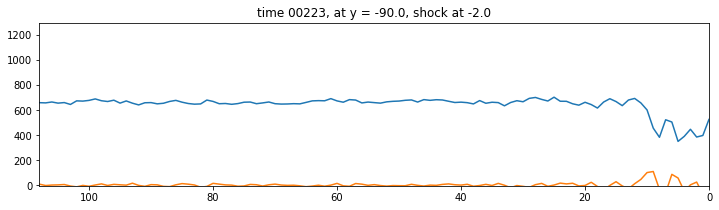

grad_v[ix_is] =  106.28764421766283


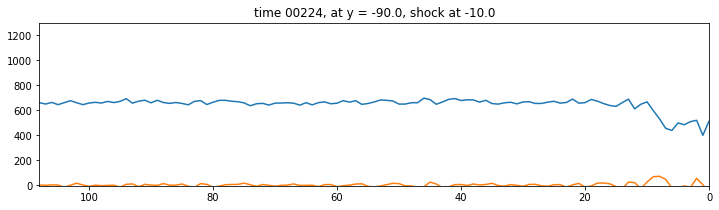

grad_v[ix_is] =  106.5412064861469


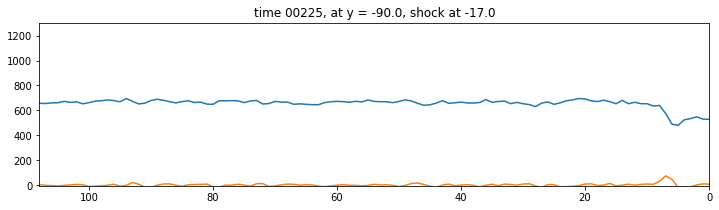

grad_v[ix_is] =  77.46022792799079


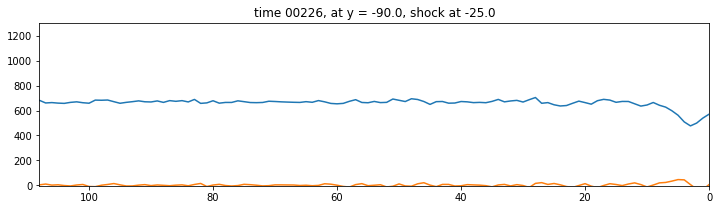

grad_v[ix_is] =  73.26720229754156


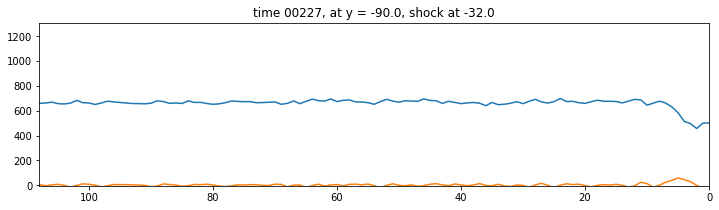

grad_v[ix_is] =  65.55885438153288


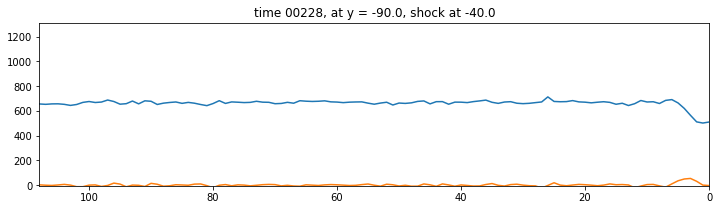

grad_v[ix_is] =  64.28837841837117


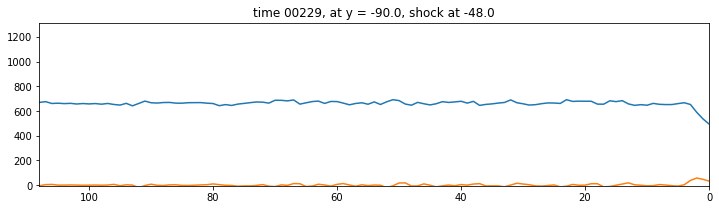

grad_v[ix_is] =  90.6144332373714


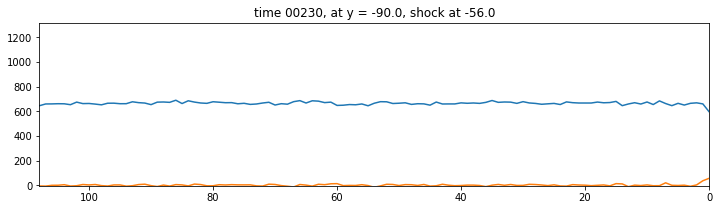

grad_v[ix_is] =  71.9240825239039


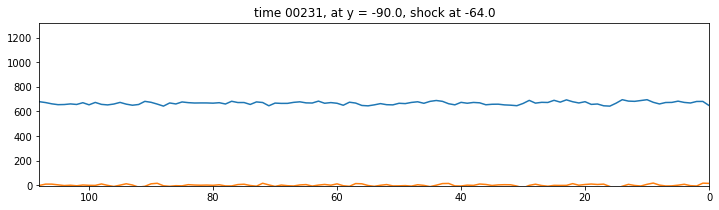

grad_v[ix_is] =  73.61695825625814
[-76. -75. -74. -73. -72. -71. -70. -69. -68. -67.]
grad_v[ix_is] =  49.895547532330426


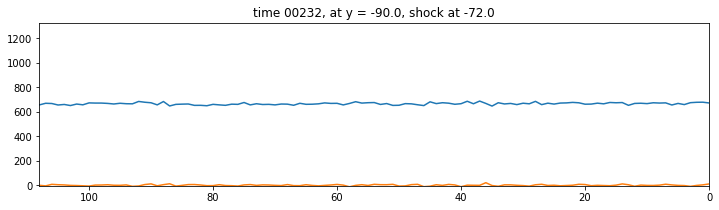

grad_v[ix_is] =  78.22676980368794


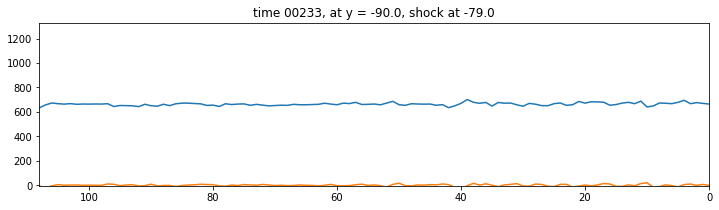

grad_v[ix_is] =  98.0270803146409


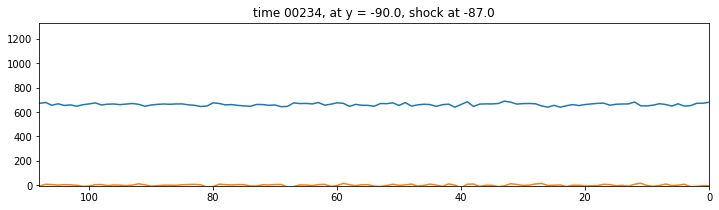

grad_v[ix_is] =  86.76749118590914


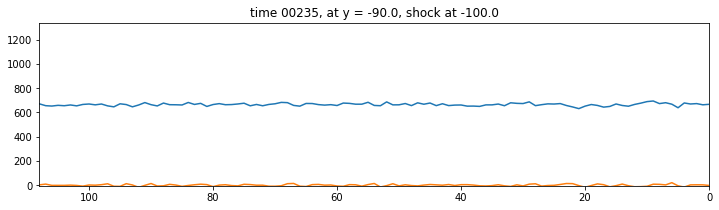

grad_v[ix_is] =  48.92210014223343
[]


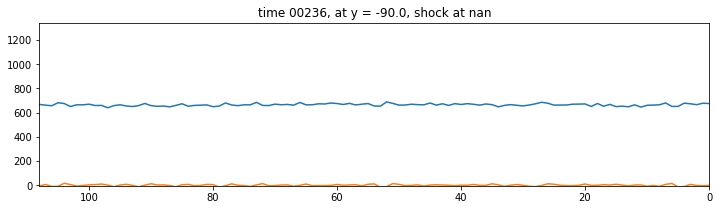

grad_v[ix_is] =  61.13249028161343


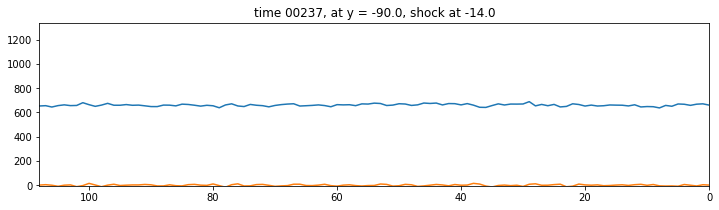

grad_v[ix_is] =  33.45300296425597
[-26. -25. -24. -23. -22. -21. -20. -19. -18. -17.]
grad_v[ix_is] =  7.454562009160924


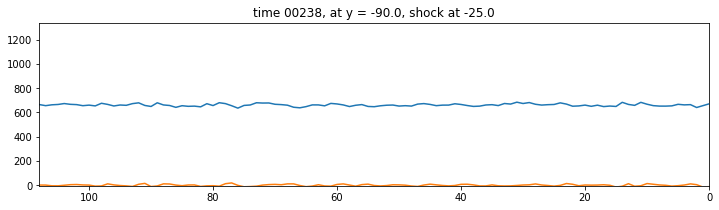

grad_v[ix_is] =  46.680632652184016
[-37. -36. -35. -34. -33. -32. -31. -30. -29. -28.]
grad_v[ix_is] =  5.2341216370658685


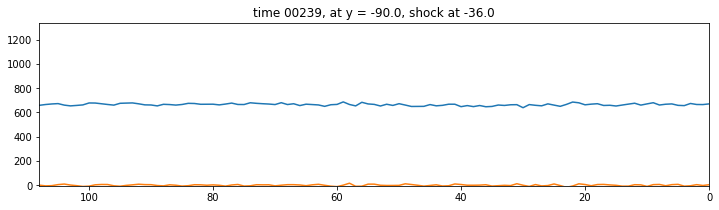

grad_v[ix_is] =  107.26097395001653


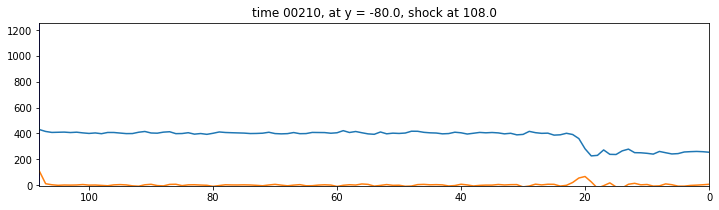

grad_v[ix_is] =  109.73130668502307
[ 96.  97.  98.  99. 100. 101. 102. 103. 104. 105.]
grad_v[ix_is] =  91.9319670240287


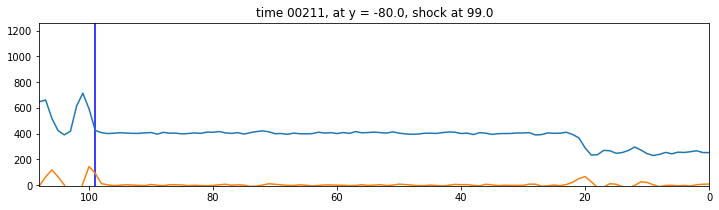

grad_v[ix_is] =  139.71110188858006


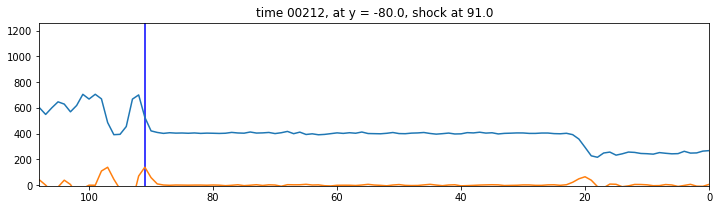

grad_v[ix_is] =  116.27848148794192


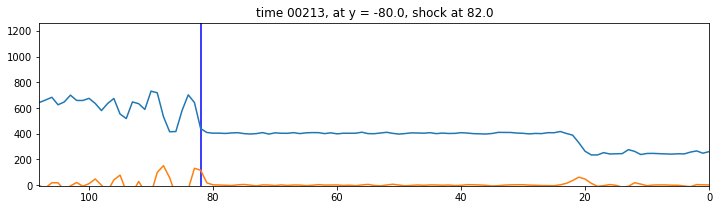

grad_v[ix_is] =  88.35552094244483


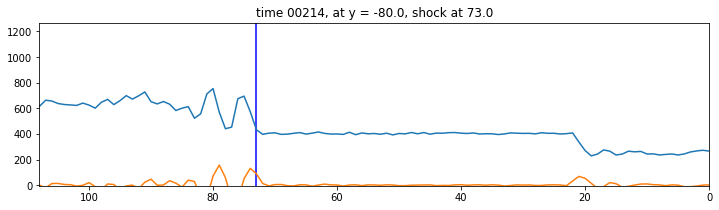

grad_v[ix_is] =  133.17954019543447
[61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]
grad_v[ix_is] =  120.06569298231582


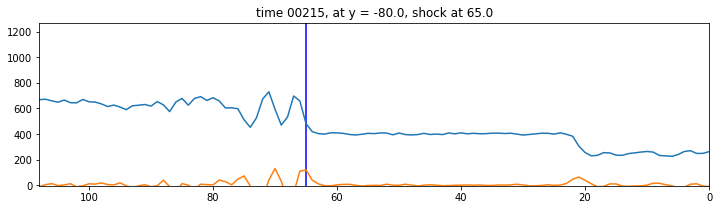

grad_v[ix_is] =  127.81839922158429


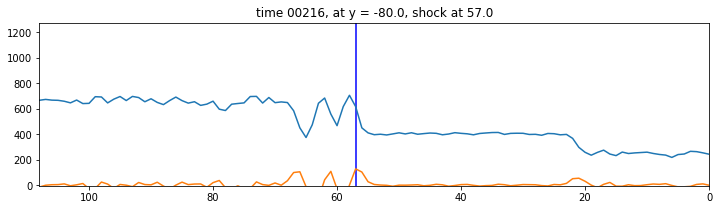

grad_v[ix_is] =  142.7270923145896


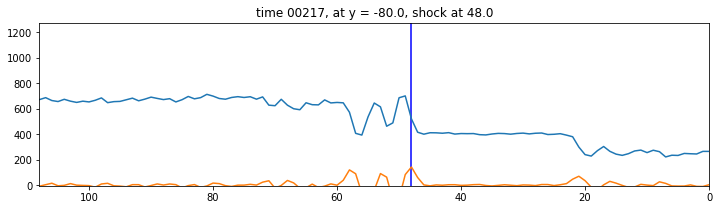

grad_v[ix_is] =  126.20048897731107


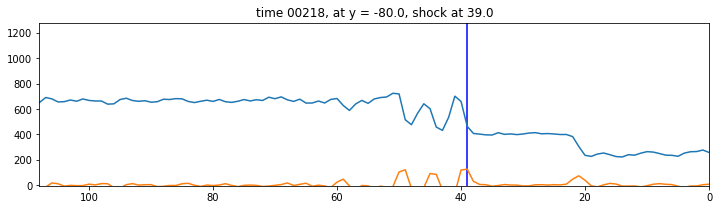

grad_v[ix_is] =  99.65046743742565


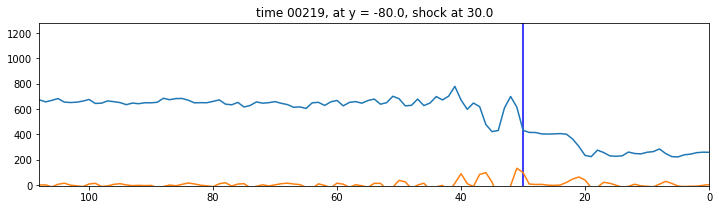

grad_v[ix_is] =  117.98990599505778


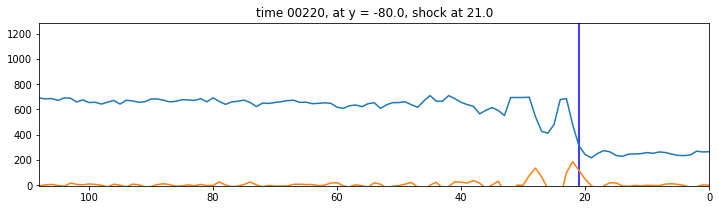

grad_v[ix_is] =  91.81595483392161


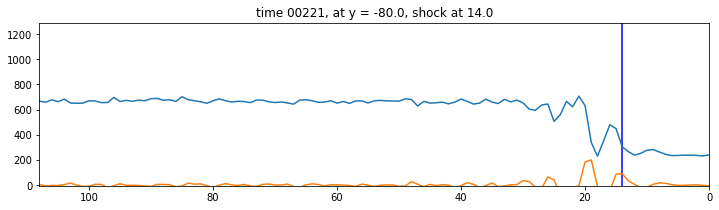

grad_v[ix_is] =  105.48062842128249
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
grad_v[ix_is] =  49.8403256157264


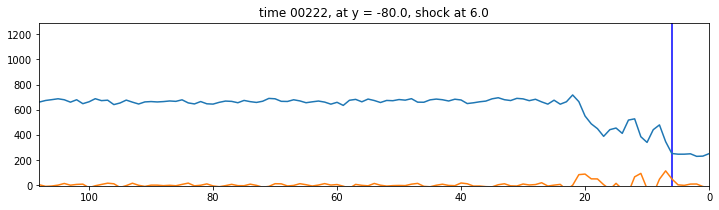

grad_v[ix_is] =  99.62689225446763


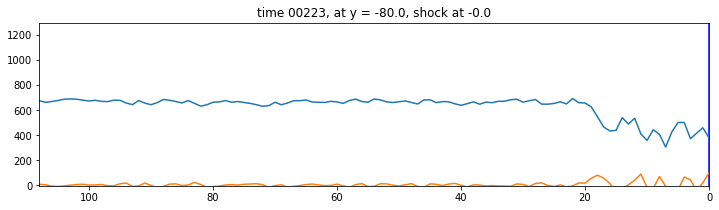

grad_v[ix_is] =  103.69844160654691


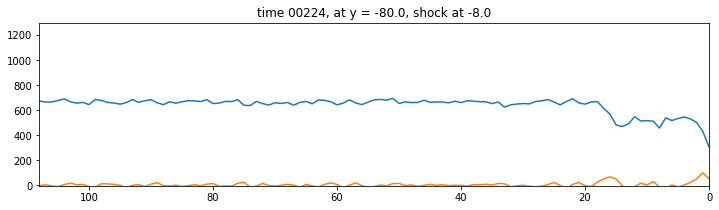

grad_v[ix_is] =  122.7870237577136


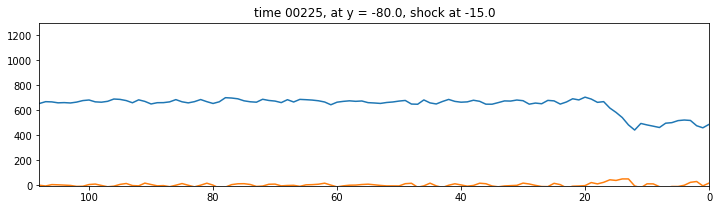

grad_v[ix_is] =  84.3504969333581


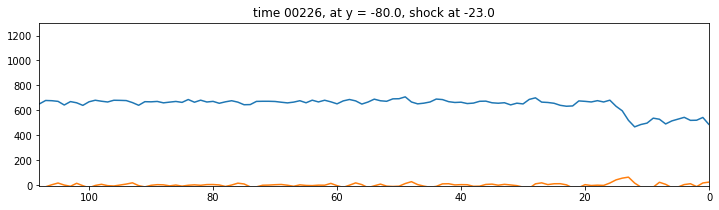

grad_v[ix_is] =  92.94429589995906


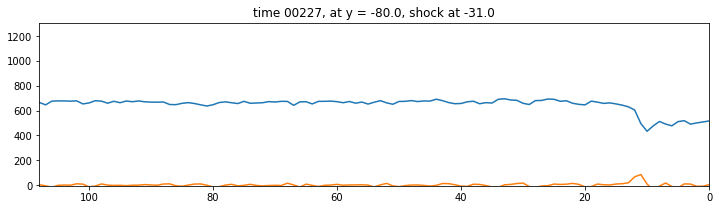

grad_v[ix_is] =  156.3981500388129
[-43. -42. -41. -40. -39. -38. -37. -36. -35. -34.]
grad_v[ix_is] =  82.4474146164589


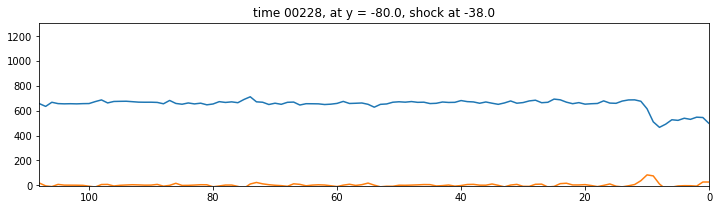

grad_v[ix_is] =  96.32842952305242
[-50. -49. -48. -47. -46. -45. -44. -43. -42. -41.]
grad_v[ix_is] =  66.05867349927934


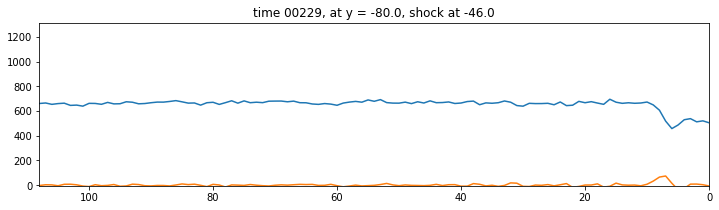

grad_v[ix_is] =  79.27970498210678
[-58. -57. -56. -55. -54. -53. -52. -51. -50. -49.]
grad_v[ix_is] =  70.96876394683554


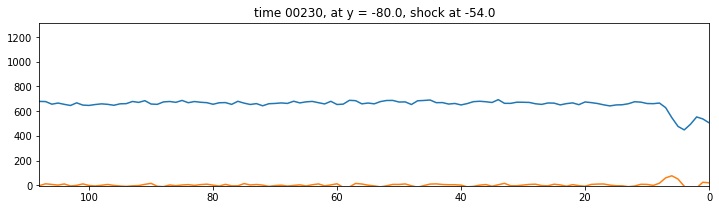

grad_v[ix_is] =  206.03324675494412
[-66. -65. -64. -63. -62. -61. -60. -59. -58. -57.]
grad_v[ix_is] =  141.1278613754341


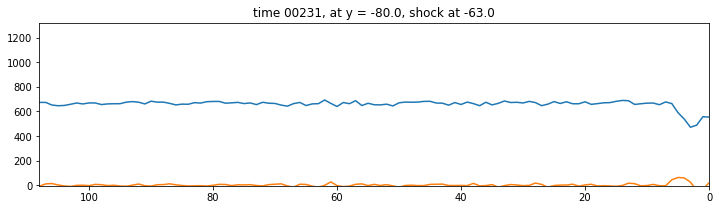

grad_v[ix_is] =  121.95502146691416
[-75. -74. -73. -72. -71. -70. -69. -68. -67. -66.]
grad_v[ix_is] =  101.18868852033864


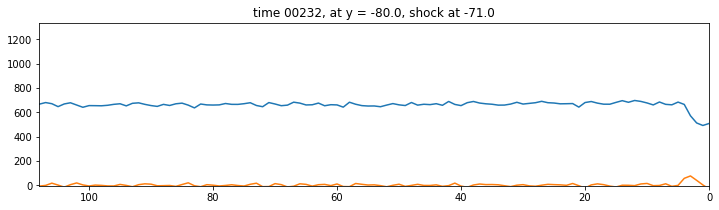

grad_v[ix_is] =  174.47459701986529
[-83. -82. -81. -80. -79. -78. -77. -76. -75. -74.]
grad_v[ix_is] =  46.17318093203477


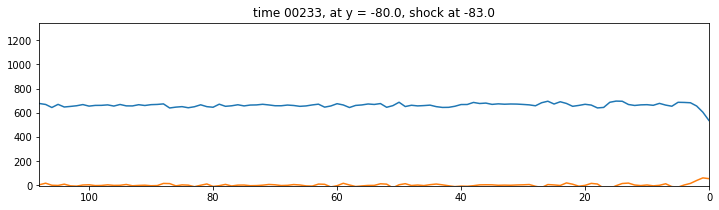

grad_v[ix_is] =  162.69782448258042


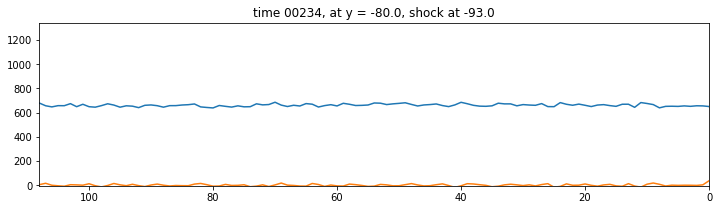

grad_v[ix_is] =  190.81292983270674


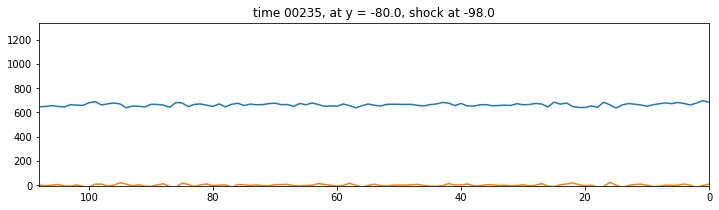

grad_v[ix_is] =  54.12985344637718
[-102. -101.]


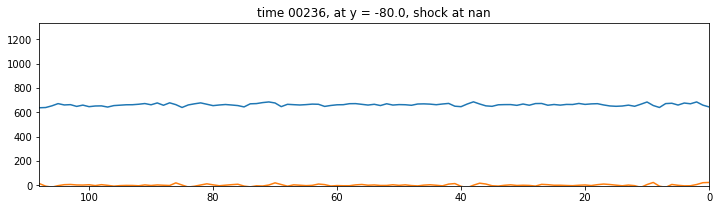

grad_v[ix_is] =  62.19371566243308


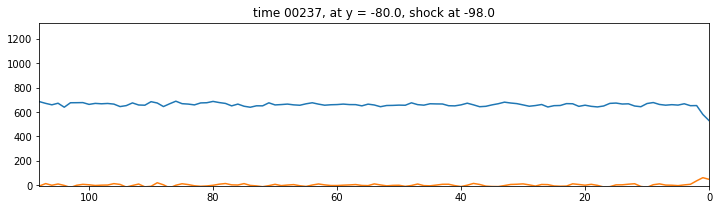

grad_v[ix_is] =  58.960073667890725
[-102. -101.]


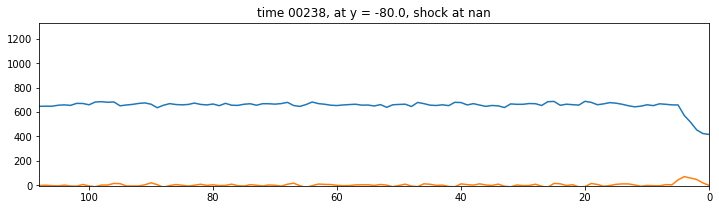

grad_v[ix_is] =  54.418929577429


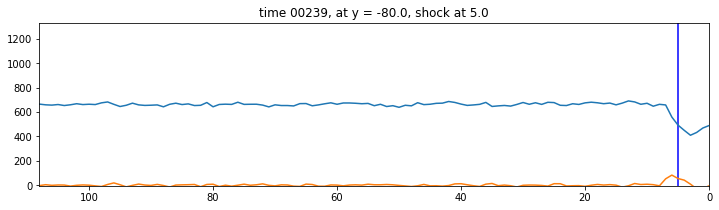

grad_v[ix_is] =  96.23250667729283


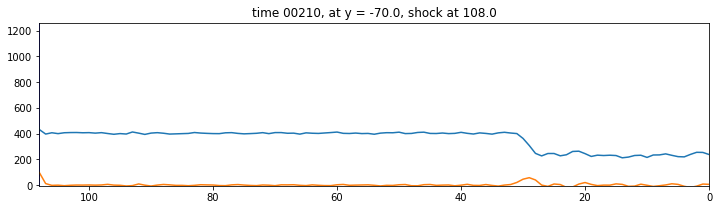

grad_v[ix_is] =  155.82750522904033
[ 96.  97.  98.  99. 100. 101. 102. 103. 104. 105.]
grad_v[ix_is] =  133.36865586505562


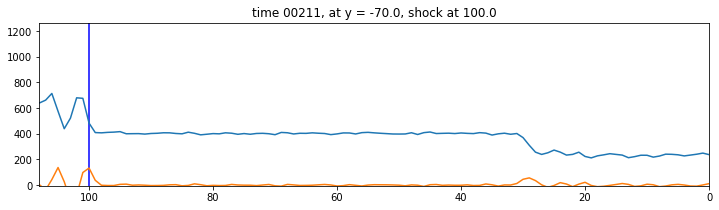

grad_v[ix_is] =  139.02938205351208
[88. 89. 90. 91. 92. 93. 94. 95. 96. 97.]
grad_v[ix_is] =  122.67458407641601


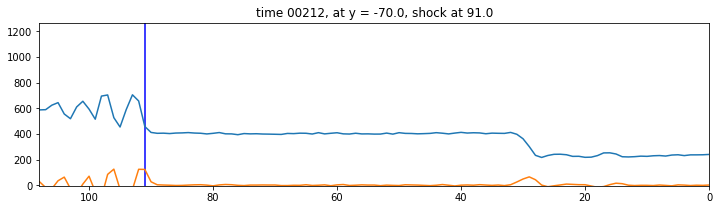

grad_v[ix_is] =  206.49018658423086
[79. 80. 81. 82. 83. 84. 85. 86. 87. 88.]
grad_v[ix_is] =  106.57674104078211


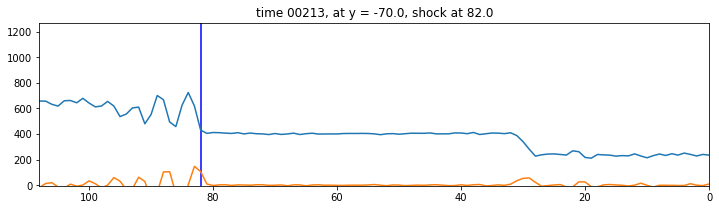

grad_v[ix_is] =  234.72359350576892
[70. 71. 72. 73. 74. 75. 76. 77. 78. 79.]
grad_v[ix_is] =  94.7461851277773


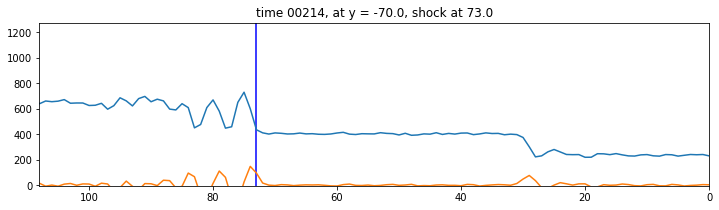

grad_v[ix_is] =  276.6894814380927
[61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]
grad_v[ix_is] =  80.96104939580201


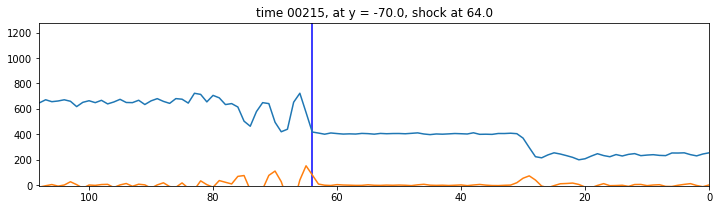

grad_v[ix_is] =  135.31868247273906


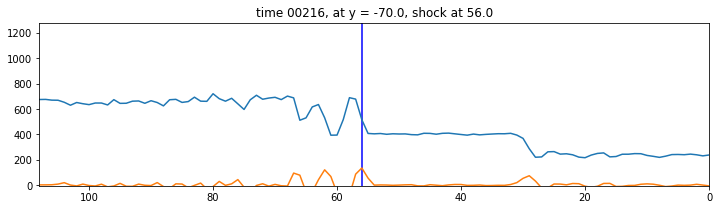

grad_v[ix_is] =  189.5935365941577
[44. 45. 46. 47. 48. 49. 50. 51. 52. 53.]
grad_v[ix_is] =  113.839632907413


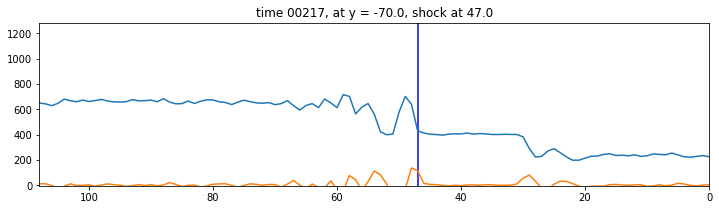

grad_v[ix_is] =  133.56028396698562


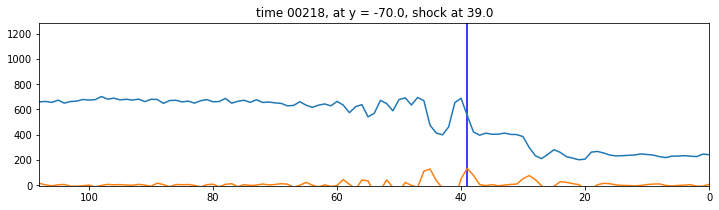

grad_v[ix_is] =  182.23765437765758


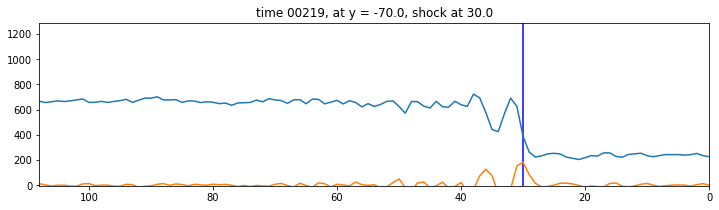

grad_v[ix_is] =  139.955397197327


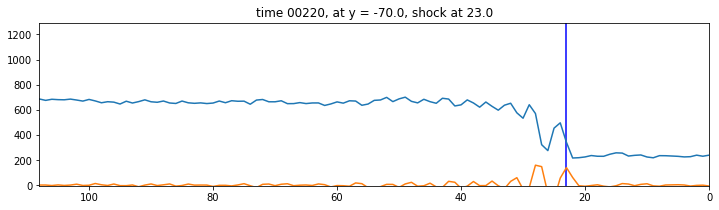

grad_v[ix_is] =  310.66825137269456
[11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
grad_v[ix_is] =  56.656865084881616


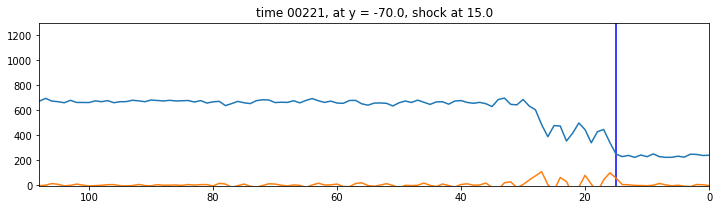

grad_v[ix_is] =  150.4659675060259
[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
grad_v[ix_is] =  80.51274459683383


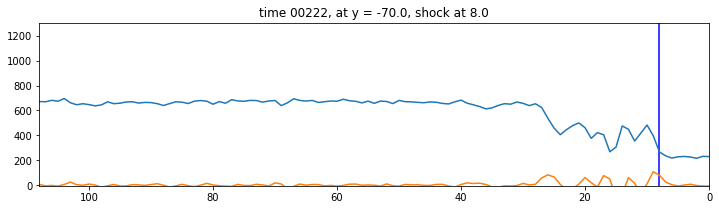

grad_v[ix_is] =  251.69540510977583
[-4. -3. -2. -1. -0.  1.  2.  3.  4.  5.]
grad_v[ix_is] =  65.3239656190065


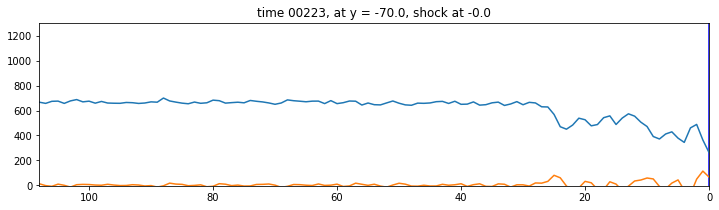

grad_v[ix_is] =  97.4500593209894
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.]
grad_v[ix_is] =  93.00609980701792


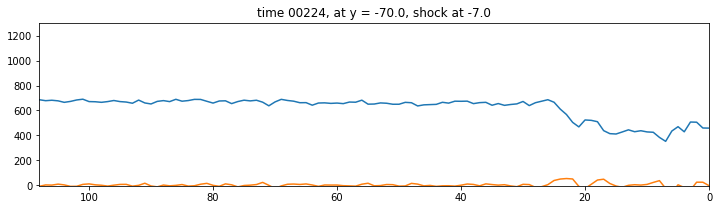

grad_v[ix_is] =  93.38873709843716
[-19. -18. -17. -16. -15. -14. -13. -12. -11. -10.]
grad_v[ix_is] =  80.79262330793202


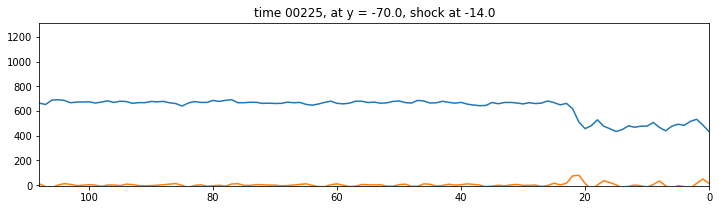

grad_v[ix_is] =  107.70579597071297
[-26. -25. -24. -23. -22. -21. -20. -19. -18. -17.]
grad_v[ix_is] =  52.33402107596808


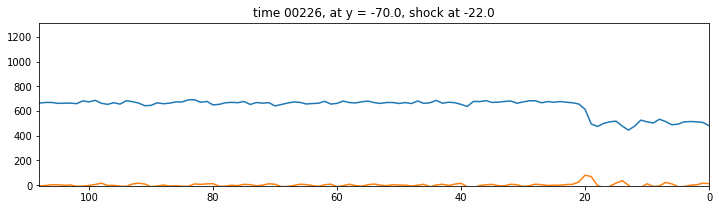

grad_v[ix_is] =  96.63929072208556
[-34. -33. -32. -31. -30. -29. -28. -27. -26. -25.]
grad_v[ix_is] =  32.72712097069794


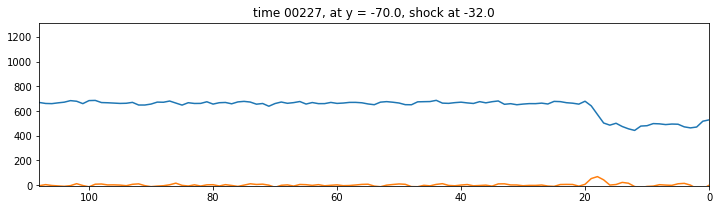

grad_v[ix_is] =  94.54824556459819
[-44. -43. -42. -41. -40. -39. -38. -37. -36. -35.]
grad_v[ix_is] =  62.3273814420221


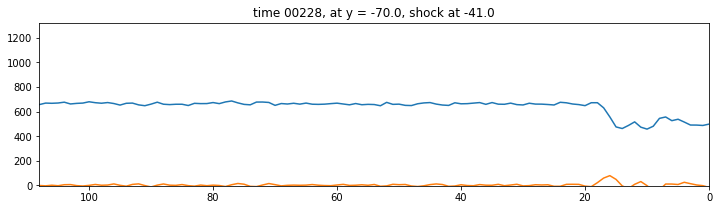

grad_v[ix_is] =  156.0095552207141
[-53. -52. -51. -50. -49. -48. -47. -46. -45. -44.]
grad_v[ix_is] =  8.078085947581997


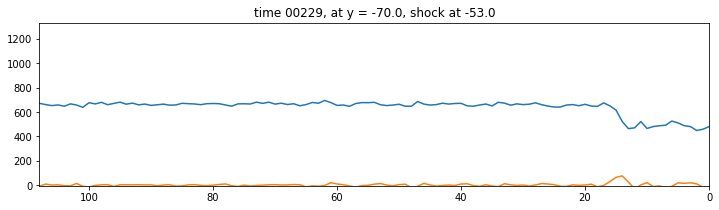

grad_v[ix_is] =  96.29347000122873
[-65. -64. -63. -62. -61. -60. -59. -58. -57. -56.]
grad_v[ix_is] =  67.36278085907645


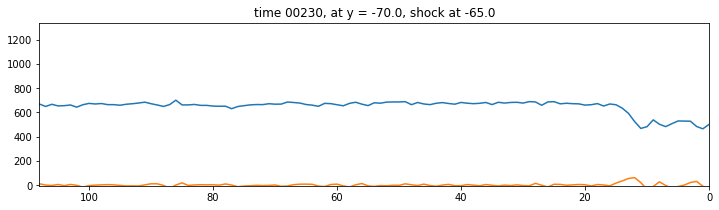

grad_v[ix_is] =  291.99137545324936


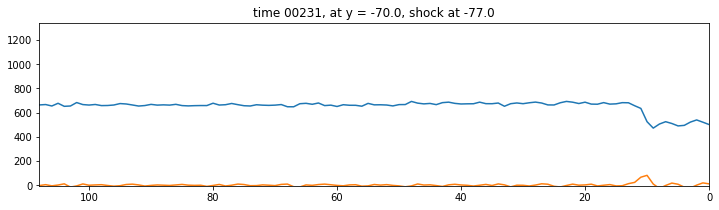

grad_v[ix_is] =  186.43615867743068


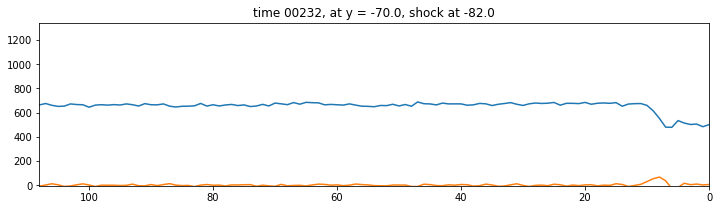

grad_v[ix_is] =  80.72033958891336


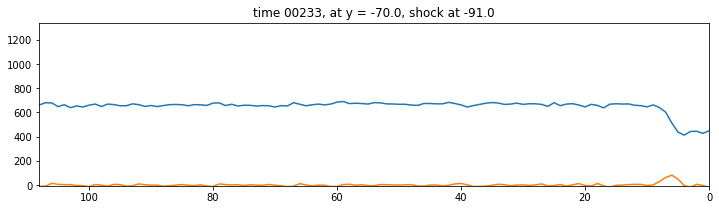

grad_v[ix_is] =  69.35995361129517
[-102. -101. -100.  -99.  -98.  -97.  -96.  -95.  -94.]


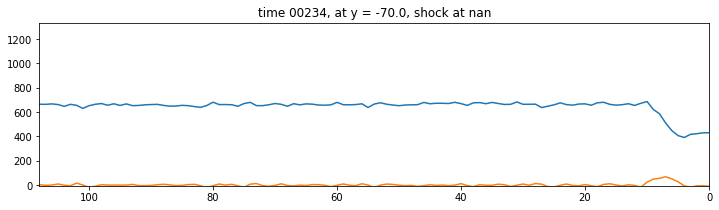

grad_v[ix_is] =  150.34773645555646


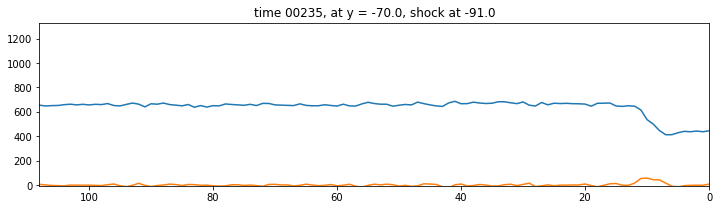

grad_v[ix_is] =  57.60187335307023
[-102. -101. -100.  -99.  -98.  -97.  -96.  -95.  -94.]


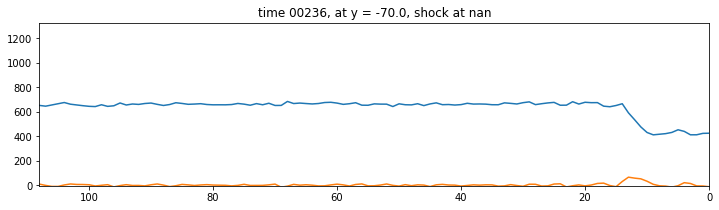

grad_v[ix_is] =  55.38788487565907


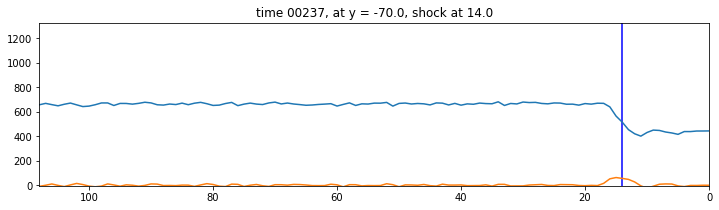

grad_v[ix_is] =  74.39226091827089
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
grad_v[ix_is] =  13.51607982170222


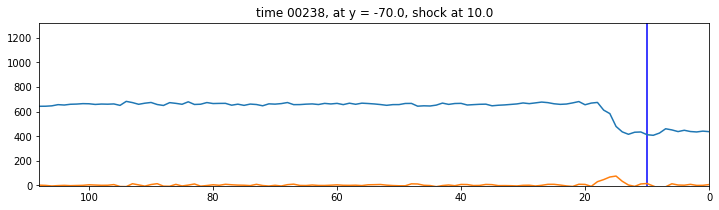

grad_v[ix_is] =  90.11907565059147
[-2. -1. -0.  1.  2.  3.  4.  5.  6.  7.]
grad_v[ix_is] =  19.105664602924463


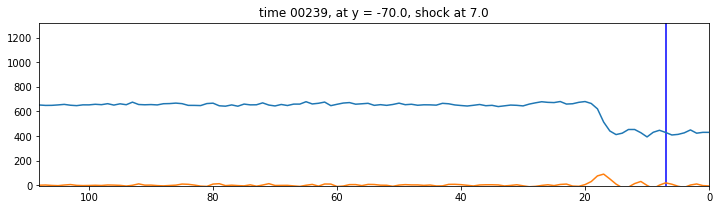

grad_v[ix_is] =  158.1868194227047
[ 96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 110. 111. 112. 113. 114.]
grad_v[ix_is] =  125.10457558597483


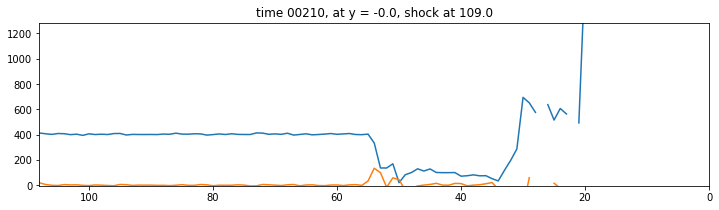

grad_v[ix_is] =  177.5344423334862
[ 97.  98.  99. 100. 101. 102. 103. 104. 105. 106.]
grad_v[ix_is] =  137.93447252419833


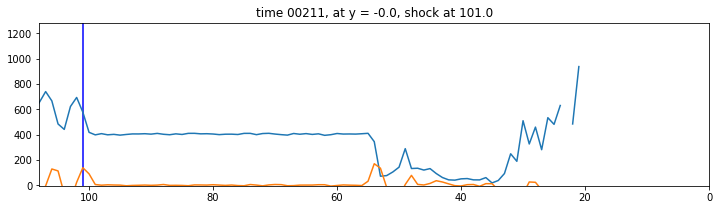

grad_v[ix_is] =  198.38997033816497
[89. 90. 91. 92. 93. 94. 95. 96. 97. 98.]
grad_v[ix_is] =  132.34608822122055


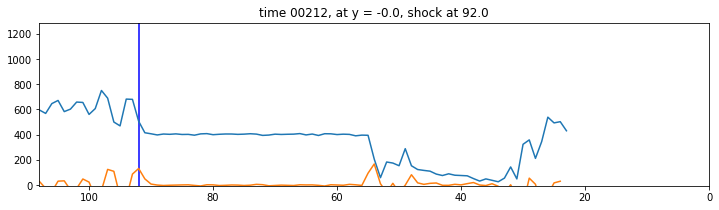

grad_v[ix_is] =  338.40979782558105
[80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
grad_v[ix_is] =  144.15714034952939


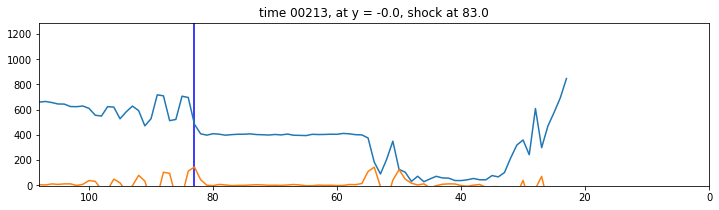

grad_v[ix_is] =  264.5566782847293
[71. 72. 73. 74. 75. 76. 77. 78. 79. 80.]
grad_v[ix_is] =  143.57428383060605


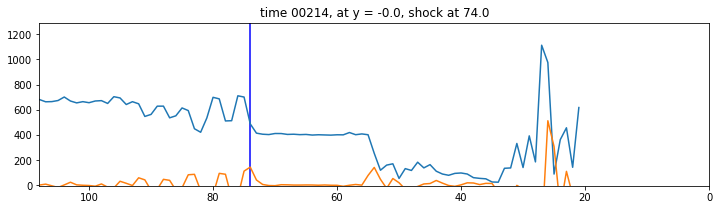

grad_v[ix_is] =  306.9312522220971
[62. 63. 64. 65. 66. 67. 68. 69. 70. 71.]
grad_v[ix_is] =  142.37272135865027


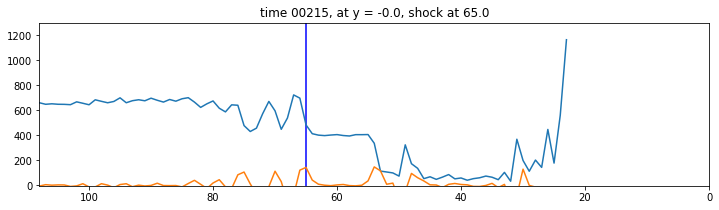

grad_v[ix_is] =  246.58473331184422
[53. 54. 55. 56. 57. 58. 59. 60. 61. 62.]
grad_v[ix_is] =  179.88500927709129


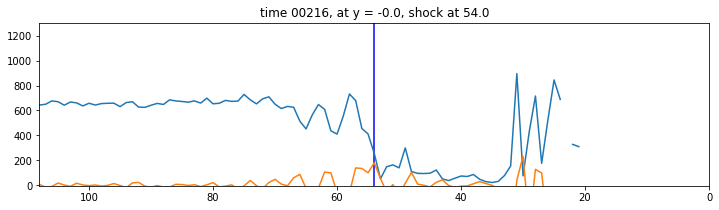

grad_v[ix_is] =  444.96628919260115
[47. 48. 49. 50. 51.]
grad_v[ix_is] =  131.87077652375422


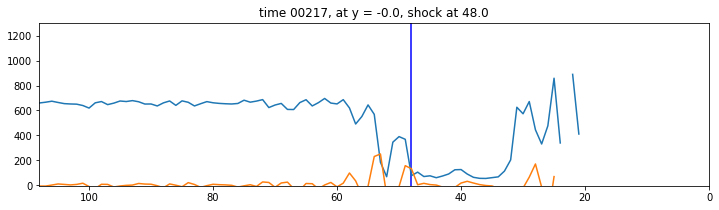

grad_v[ix_is] =  241.44841721010212
[41. 42. 43. 44. 45.]
grad_v[ix_is] =  155.6315835929998


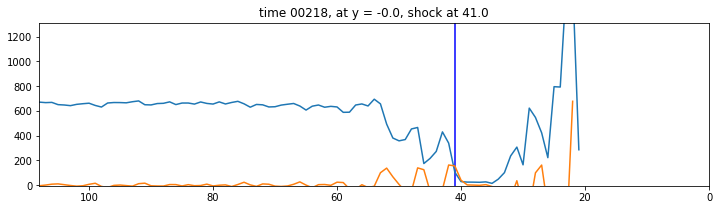

grad_v[ix_is] =  223.48252050243445
[34. 35. 36. 37. 38.]
grad_v[ix_is] =  106.96203549739153


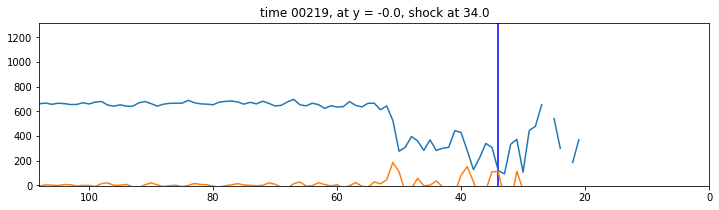

grad_v[ix_is] =  167.30108410824042
[27. 28. 29. 30. 31.]
grad_v[ix_is] =  21.874870805124715


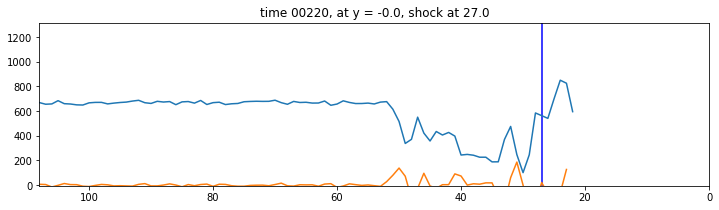

grad_v[ix_is] =  312.8762601689857
[20. 21. 22. 23. 24.]
grad_v[ix_is] =  268.14327388602584


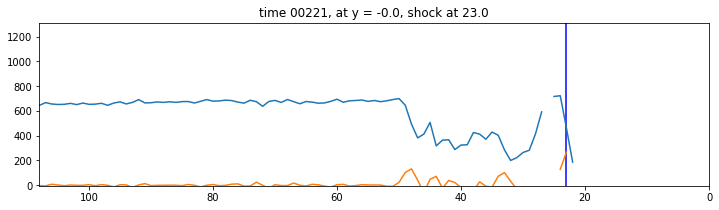

grad_v[ix_is] =  115.5347246653055
[16. 17. 18. 19. 20.]


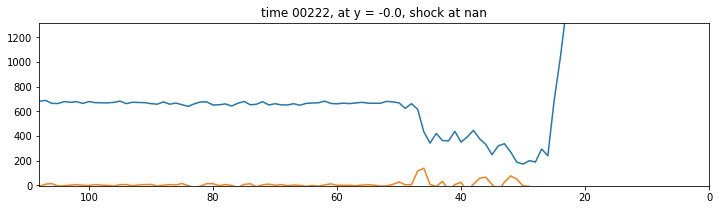

grad_v[ix_is] =  326.27571471581933


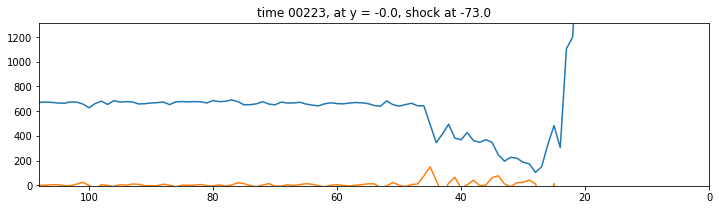

grad_v[ix_is] =  107.67088015906705
[-80. -79. -78. -77. -76.]
grad_v[ix_is] =  78.99237403224956


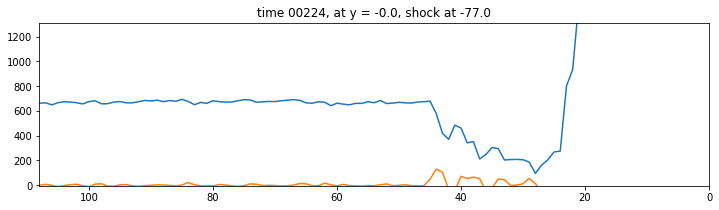

grad_v[ix_is] =  157.4886275310612
[-84. -83. -82. -81. -80.]


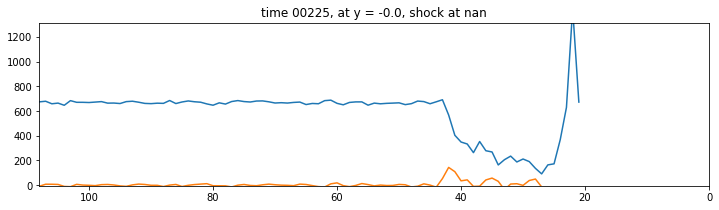

grad_v[ix_is] =  171.55044892514556


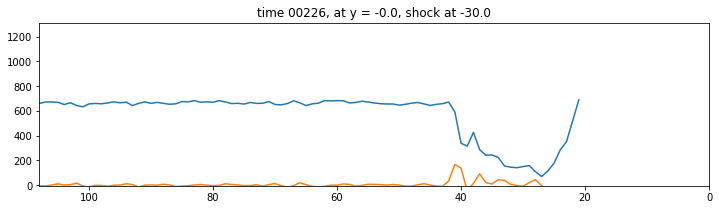

grad_v[ix_is] =  335.73783976584343
[-37. -36. -35. -34. -33.]
grad_v[ix_is] =  108.82504388849785


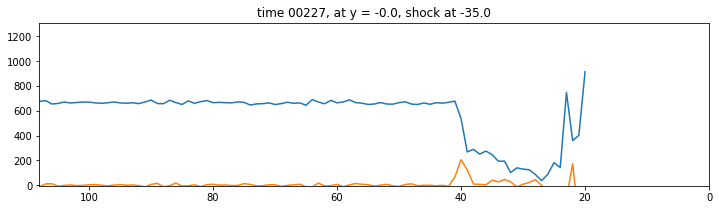

grad_v[ix_is] =  159.3115445673004
[-42. -41. -40. -39. -38.]
grad_v[ix_is] =  75.31277158407241


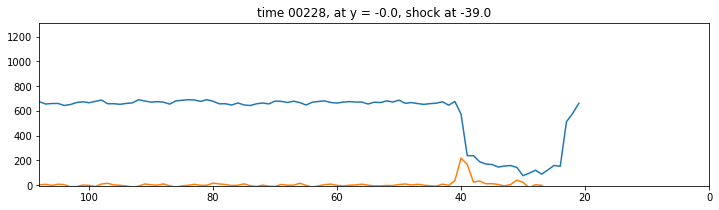

grad_v[ix_is] =  360.7432485076532
[-46. -45. -44. -43. -42.]


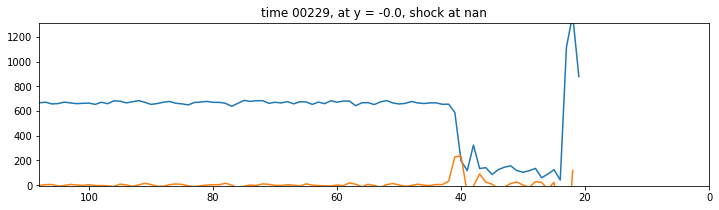

grad_v[ix_is] =  241.01492943306624


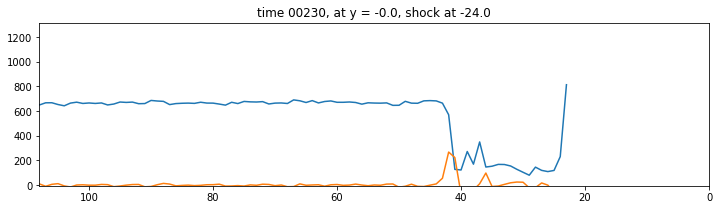

grad_v[ix_is] =  615.4631448046438
[-31. -30. -29. -28. -27.]
grad_v[ix_is] =  307.87043501599146


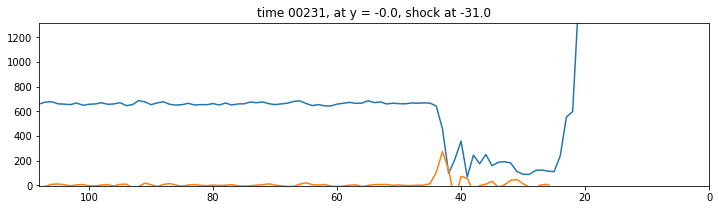

grad_v[ix_is] =  134.76488578222325
[-38. -37. -36. -35. -34.]
grad_v[ix_is] =  21.42899321329189


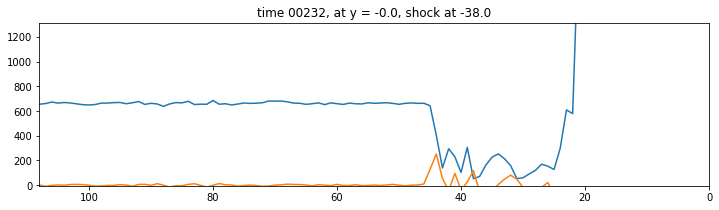

grad_v[ix_is] =  311.3482310975588
[-45. -44. -43. -42. -41.]
grad_v[ix_is] =  55.55487147959589


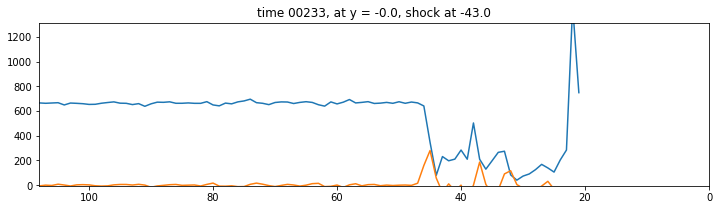

grad_v[ix_is] =  566.3377980599732
[-50. -49. -48. -47. -46.]


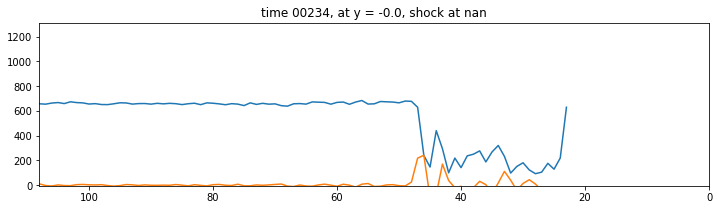

grad_v[ix_is] =  279.84911501967645


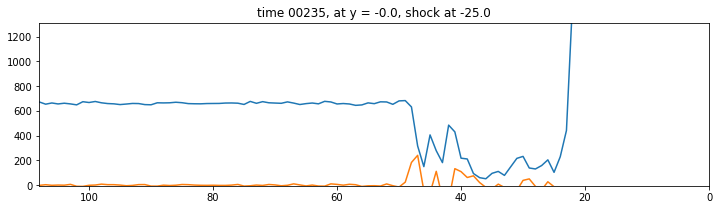

grad_v[ix_is] =  269.80461125282875
[-32. -31. -30. -29. -28.]
grad_v[ix_is] =  119.96662207387234


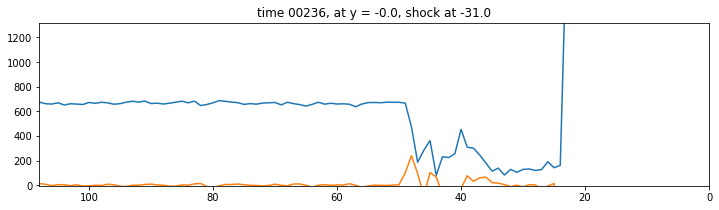

grad_v[ix_is] =  533.4301253980511
[-38. -37. -36. -35. -34.]


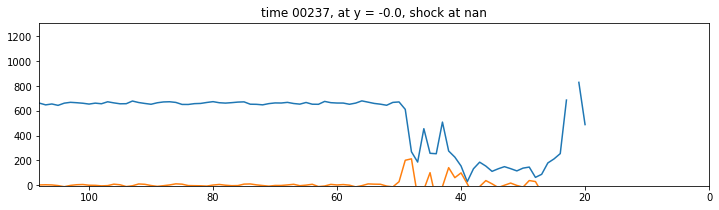

grad_v[ix_is] =  250.76879037737447


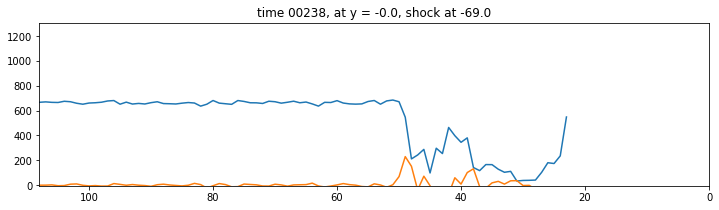

grad_v[ix_is] =  497.4556399616994
[-76. -75. -74. -73. -72.]
grad_v[ix_is] =  135.4921724747457


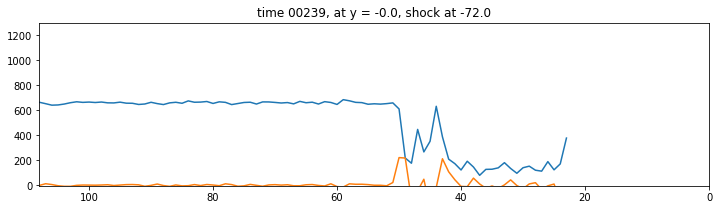

grad_v[ix_is] =  120.33699270824641


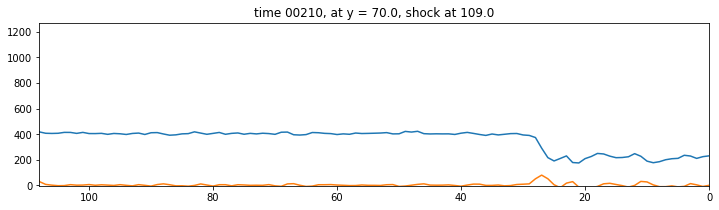

grad_v[ix_is] =  129.28749449743273


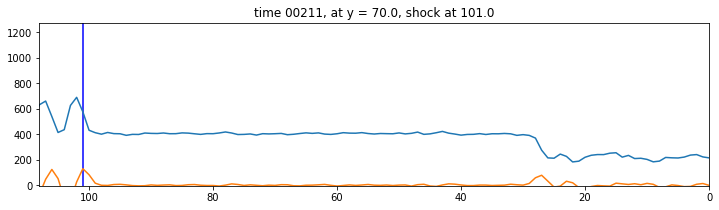

grad_v[ix_is] =  133.67688074415946


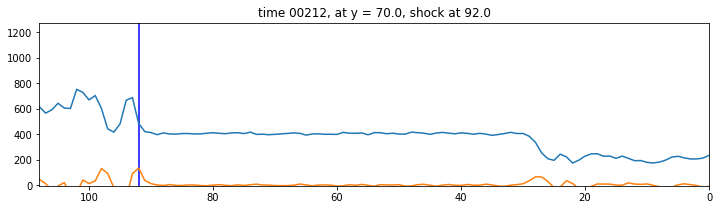

grad_v[ix_is] =  164.77415856128573
[80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
grad_v[ix_is] =  125.5618263849893


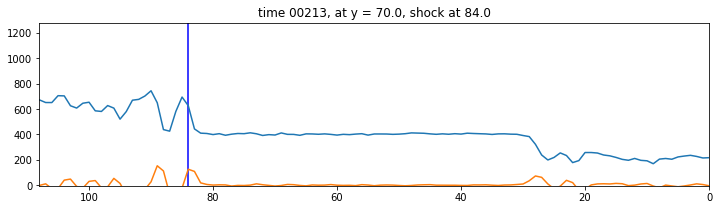

grad_v[ix_is] =  141.94677447934927


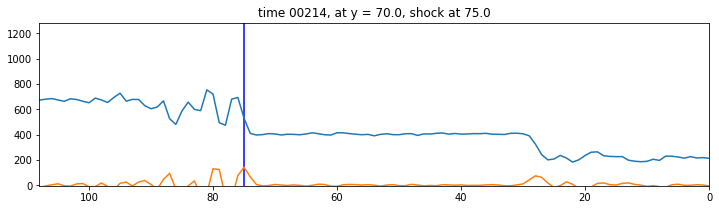

grad_v[ix_is] =  141.91508243133768


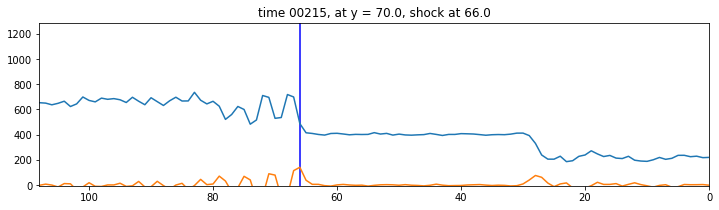

grad_v[ix_is] =  118.22052835419228
[54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
grad_v[ix_is] =  136.33558265100586


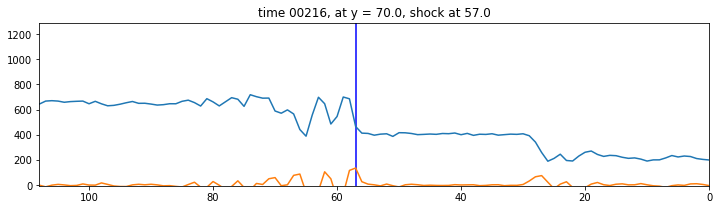

grad_v[ix_is] =  123.55396580737046
[45. 46. 47. 48. 49. 50. 51. 52. 53. 54.]
grad_v[ix_is] =  124.0050604036098


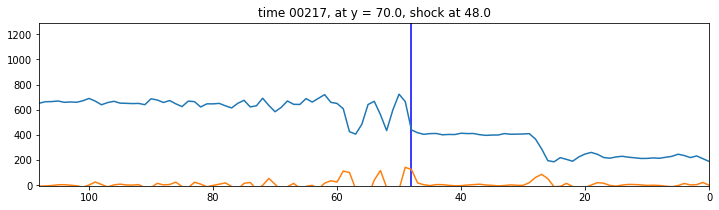

grad_v[ix_is] =  172.17717073591066
[36. 37. 38. 39. 40. 41. 42. 43. 44. 45.]
grad_v[ix_is] =  102.96606863355134


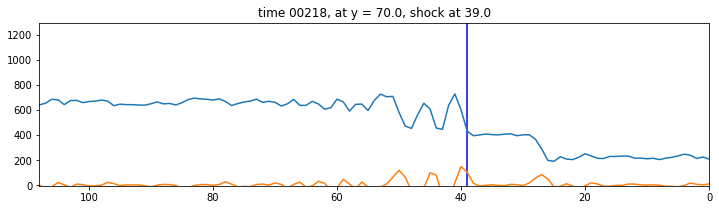

grad_v[ix_is] =  138.54868311178905


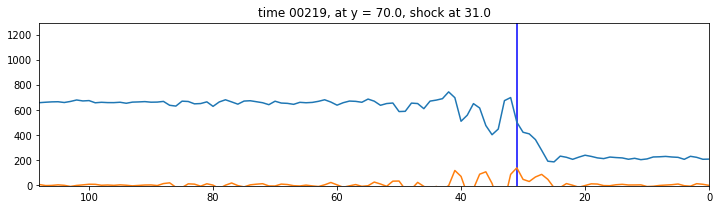

grad_v[ix_is] =  132.8140211593224


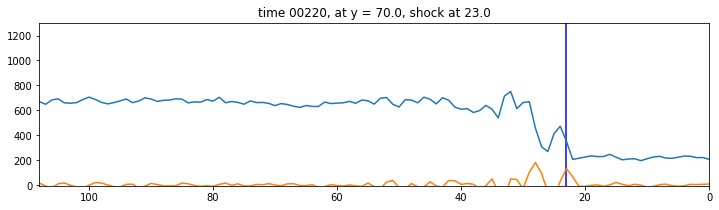

grad_v[ix_is] =  158.12342583208357
[11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
grad_v[ix_is] =  81.0494523427234


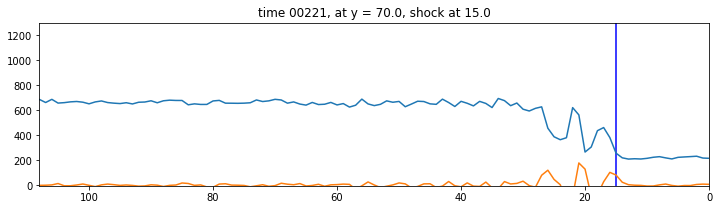

grad_v[ix_is] =  155.95043961921806
[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
grad_v[ix_is] =  77.69436347666611


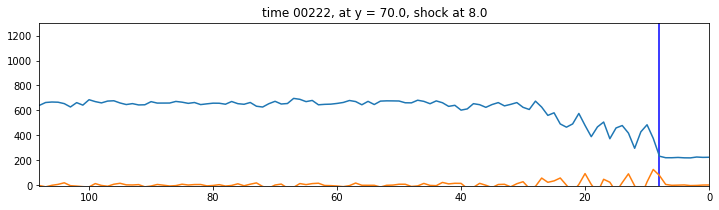

grad_v[ix_is] =  110.19926085906091
[-4. -3. -2. -1. -0.  1.  2.  3.  4.  5.]
grad_v[ix_is] =  111.7517553479903


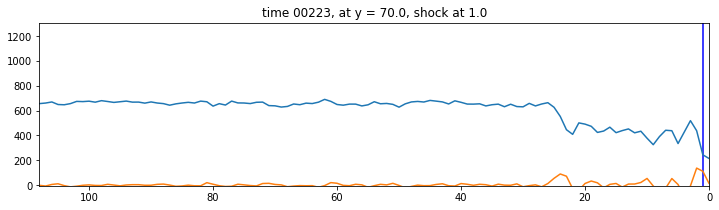

grad_v[ix_is] =  120.4474684870293


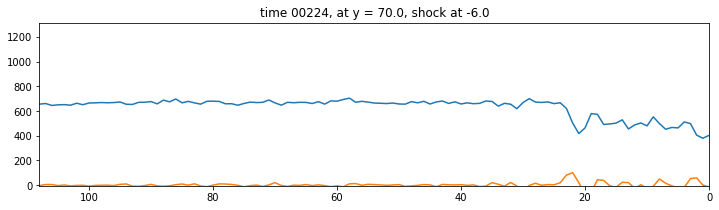

grad_v[ix_is] =  212.6154445001245
[-18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.]
grad_v[ix_is] =  108.00481484386985


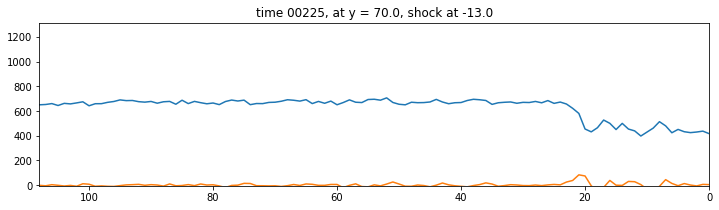

grad_v[ix_is] =  105.84447693227483
[-25. -24. -23. -22. -21. -20. -19. -18. -17. -16.]
grad_v[ix_is] =  42.83406836333762


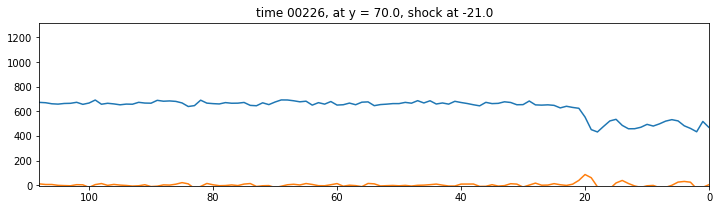

grad_v[ix_is] =  173.70158585438492
[-33. -32. -31. -30. -29. -28. -27. -26. -25. -24.]
grad_v[ix_is] =  48.87654767547144


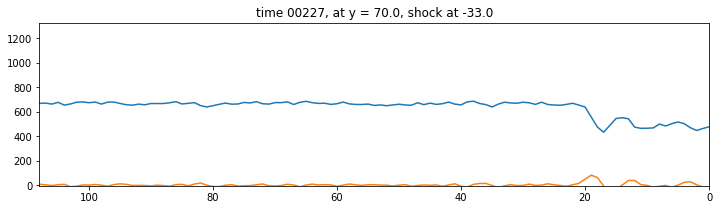

grad_v[ix_is] =  135.74139016402648
[-45. -44. -43. -42. -41. -40. -39. -38. -37. -36.]
grad_v[ix_is] =  73.21417688896301


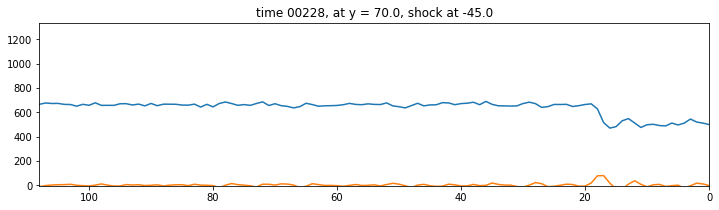

grad_v[ix_is] =  407.8614066636458


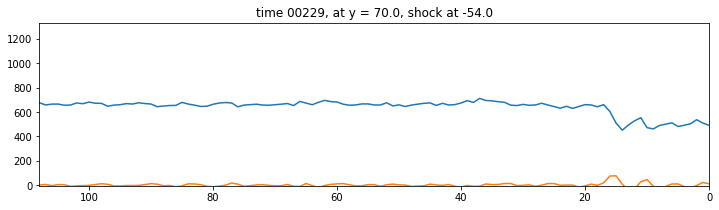

grad_v[ix_is] =  173.38291652915757


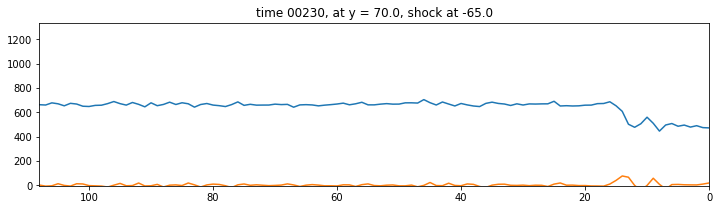

grad_v[ix_is] =  133.8582722946313


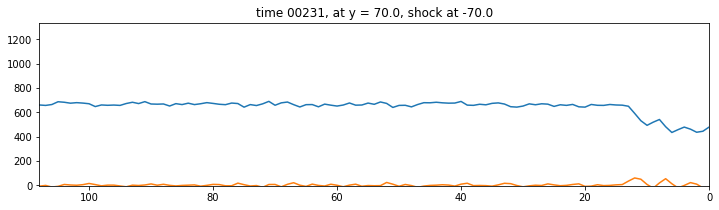

grad_v[ix_is] =  264.3941176159989
[-82. -81. -80. -79. -78. -77. -76. -75. -74. -73.]


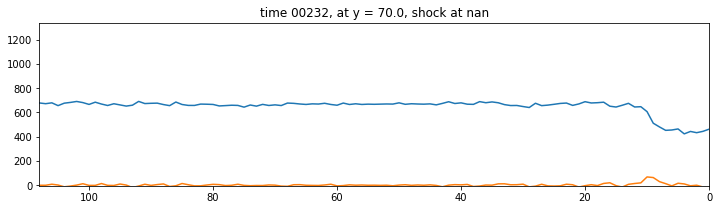

grad_v[ix_is] =  103.54629953321904


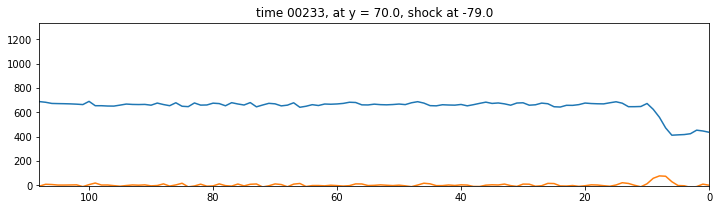

grad_v[ix_is] =  157.6132368325791
[-91. -90. -89. -88. -87. -86. -85. -84. -83. -82.]


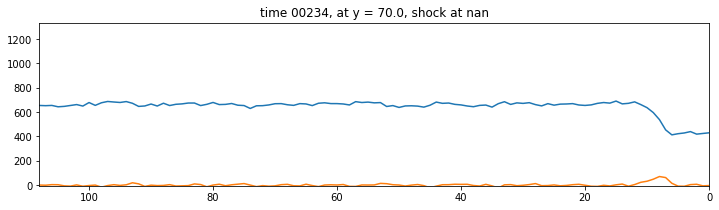

grad_v[ix_is] =  199.53464168825306


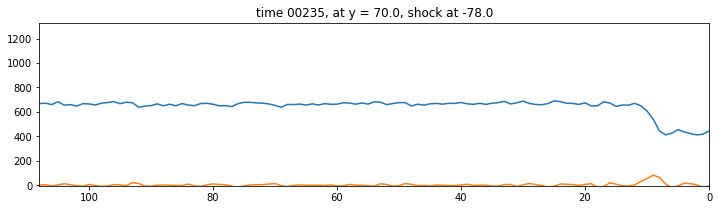

grad_v[ix_is] =  106.39845986051404


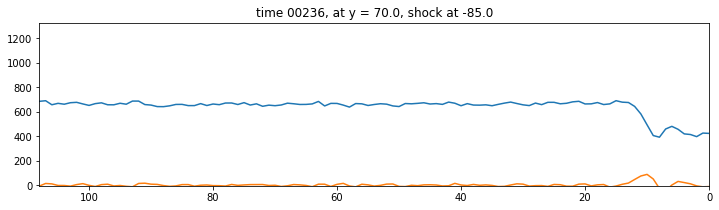

grad_v[ix_is] =  82.05353215574408
[-97. -96. -95. -94. -93. -92. -91. -90. -89. -88.]


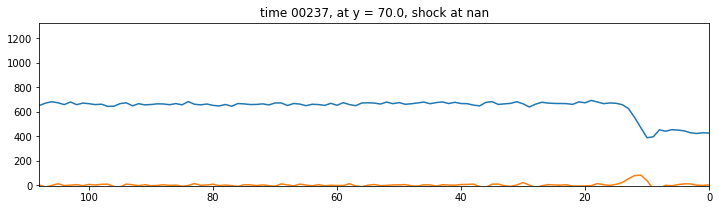

grad_v[ix_is] =  118.04762594768877


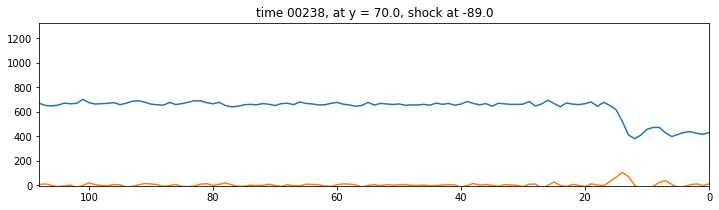

grad_v[ix_is] =  95.08616296088809
[-101. -100.  -99.  -98.  -97.  -96.  -95.  -94.  -93.  -92.]


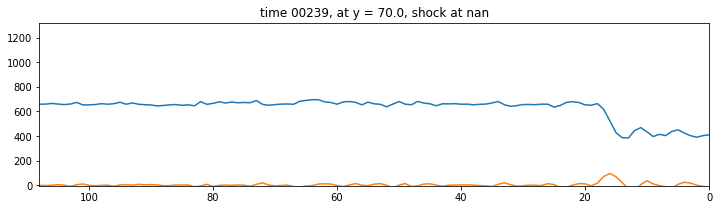

grad_v[ix_is] =  127.57547013583559


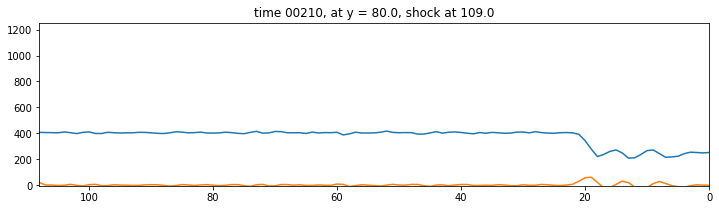

grad_v[ix_is] =  99.61727230541763
[ 97.  98.  99. 100. 101. 102. 103. 104. 105. 106.]
grad_v[ix_is] =  136.1903465052768


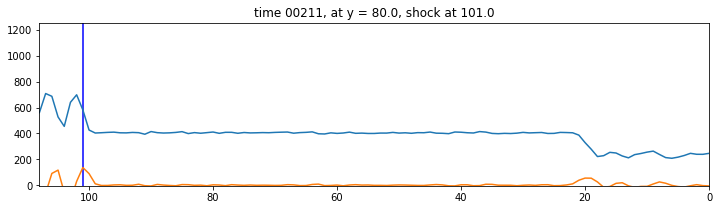

grad_v[ix_is] =  132.56568201710138


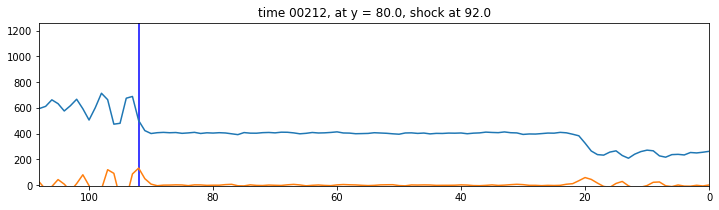

grad_v[ix_is] =  118.78295215150294


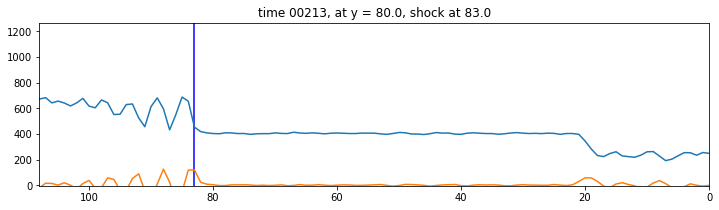

grad_v[ix_is] =  132.56080120389697


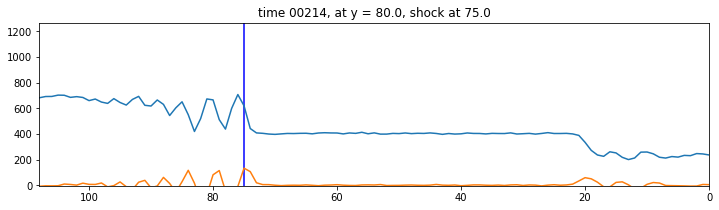

grad_v[ix_is] =  149.177653912375


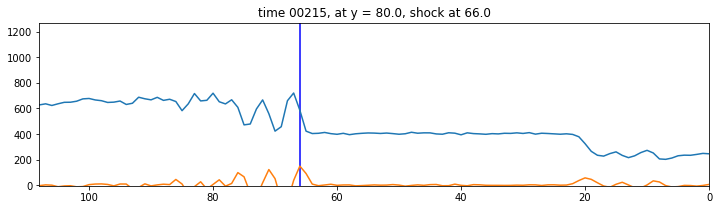

grad_v[ix_is] =  173.22711572958443
[54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
grad_v[ix_is] =  142.663821610414


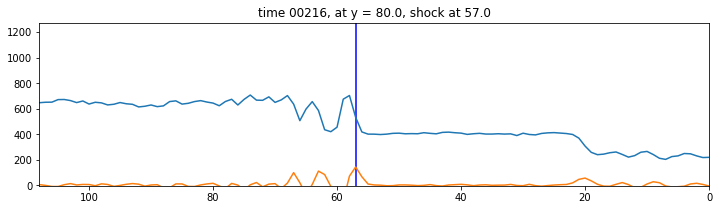

grad_v[ix_is] =  137.2392835089861
[45. 46. 47. 48. 49. 50. 51. 52. 53. 54.]
grad_v[ix_is] =  129.64005416165188


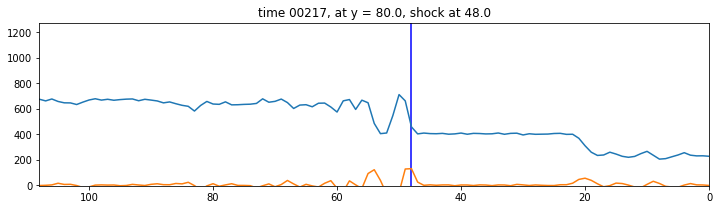

grad_v[ix_is] =  136.41589601118685


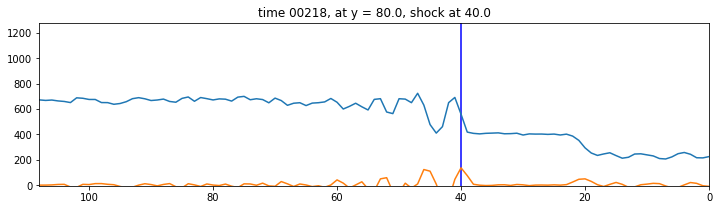

grad_v[ix_is] =  126.97233838059017


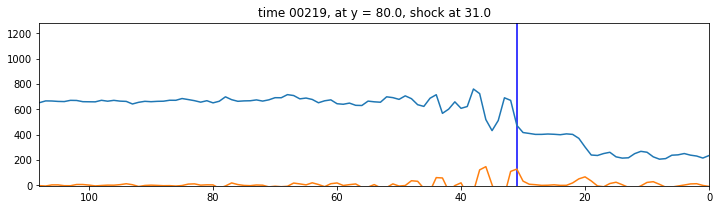

grad_v[ix_is] =  123.29225930519382


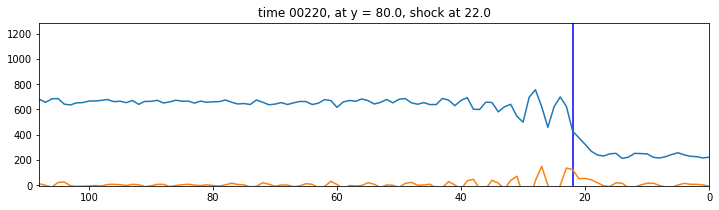

grad_v[ix_is] =  114.23301169569399
[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
grad_v[ix_is] =  94.68598345658462


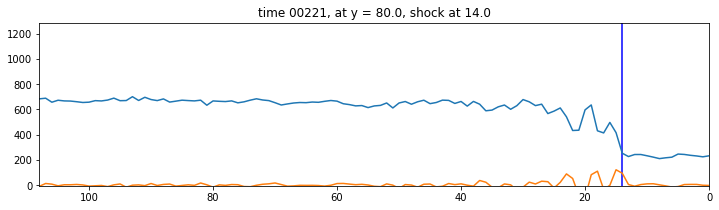

grad_v[ix_is] =  104.96865354467076
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
grad_v[ix_is] =  100.83320039199248


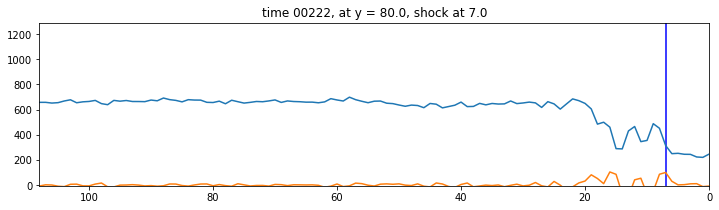

grad_v[ix_is] =  93.16638820239496
[-5. -4. -3. -2. -1. -0.  1.  2.  3.  4.]
grad_v[ix_is] =  83.11236073812856


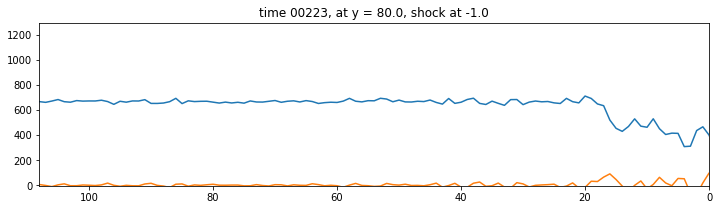

grad_v[ix_is] =  153.94647015422646
[-13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.]
grad_v[ix_is] =  70.42084344395035


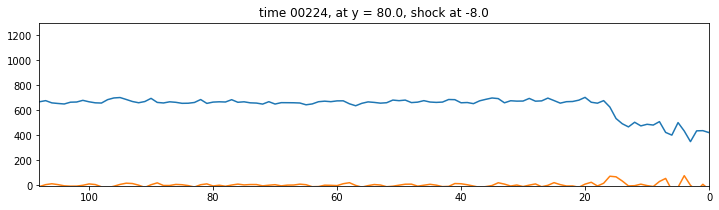

grad_v[ix_is] =  70.71116165050846


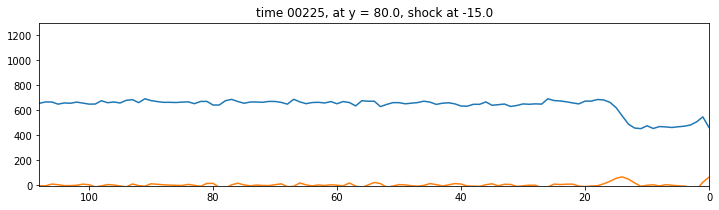

grad_v[ix_is] =  105.48841790084495
[-27. -26. -25. -24. -23. -22. -21. -20. -19. -18.]
grad_v[ix_is] =  77.09908144285447


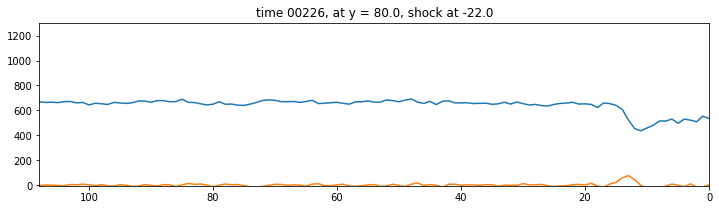

grad_v[ix_is] =  120.12398386237487


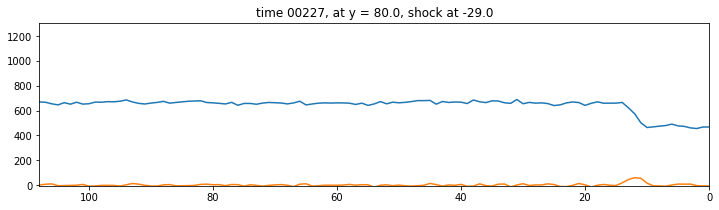

grad_v[ix_is] =  69.19406354640492
[-41. -40. -39. -38. -37. -36. -35. -34. -33. -32.]
grad_v[ix_is] =  39.339591518053496


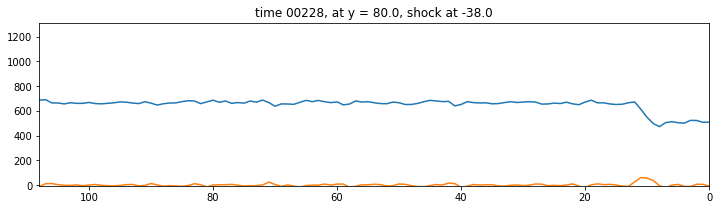

grad_v[ix_is] =  77.75668084238643
[-50. -49. -48. -47. -46. -45. -44. -43. -42. -41.]
grad_v[ix_is] =  51.40418755176145


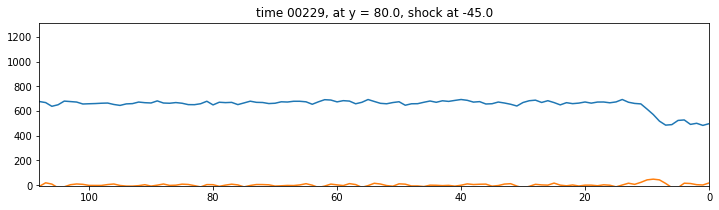

grad_v[ix_is] =  64.97139083801355
[-57. -56. -55. -54. -53. -52. -51. -50. -49. -48.]
grad_v[ix_is] =  35.62026434832012


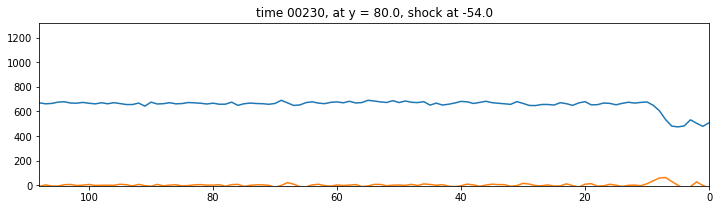

grad_v[ix_is] =  203.4206226413676
[-66. -65. -64. -63. -62. -61. -60. -59. -58. -57.]
grad_v[ix_is] =  71.76871284722273


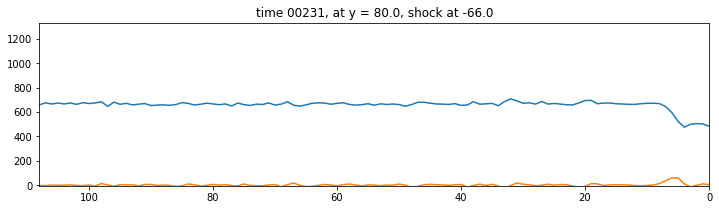

grad_v[ix_is] =  114.62792870323051
[-78. -77. -76. -75. -74. -73. -72. -71. -70. -69.]
grad_v[ix_is] =  94.17750212093233


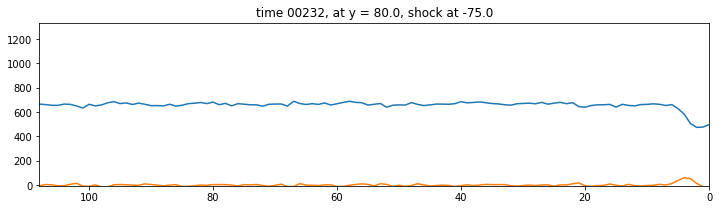

grad_v[ix_is] =  120.95063515361184


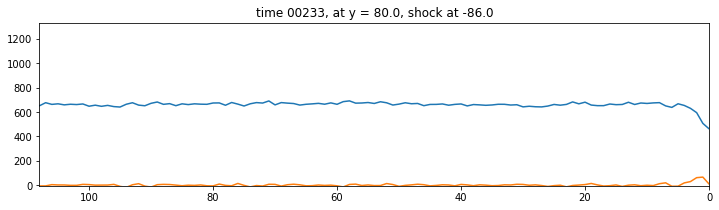

grad_v[ix_is] =  286.7406026307229


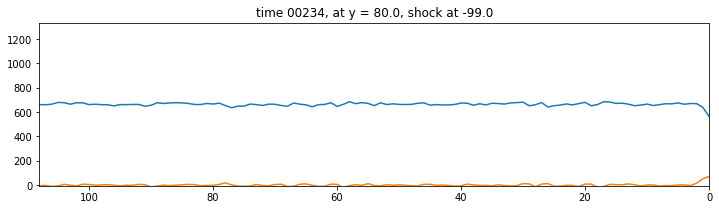

grad_v[ix_is] =  121.66174326638736
[-102.]


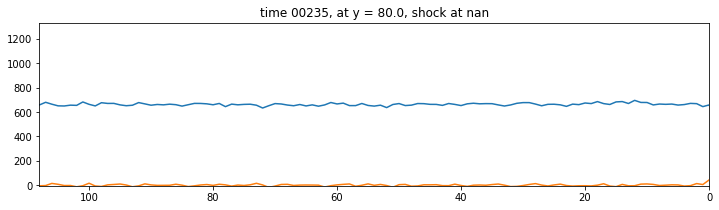

grad_v[ix_is] =  72.93246670121073


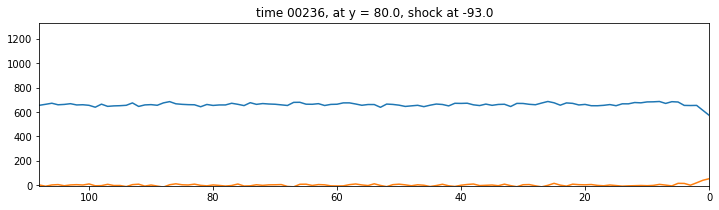

grad_v[ix_is] =  66.33775703919267
[-102. -101. -100.  -99.  -98.  -97.  -96.]
grad_v[ix_is] =  46.26130384598588


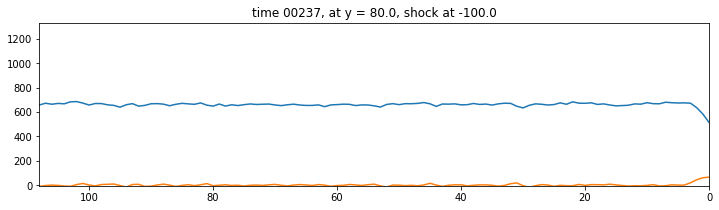

grad_v[ix_is] =  71.16419143484009
[]


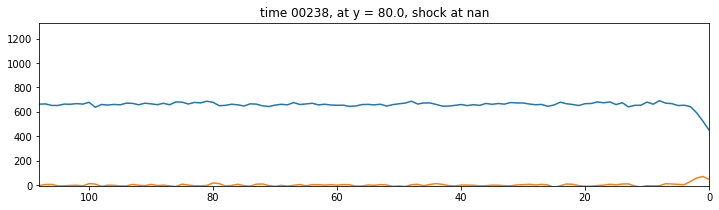

grad_v[ix_is] =  54.315125640958115


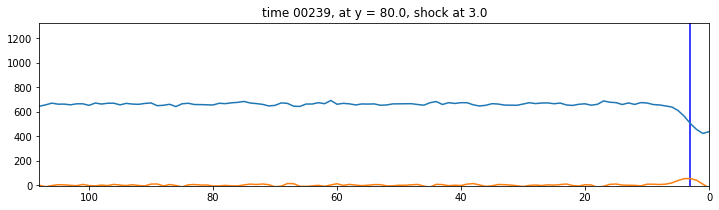

grad_v[ix_is] =  122.98676471731349


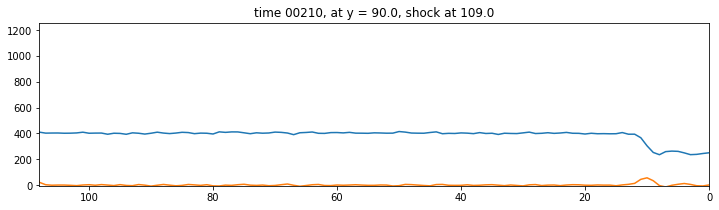

grad_v[ix_is] =  113.551669620977
[ 97.  98.  99. 100. 101. 102. 103. 104. 105. 106.]
grad_v[ix_is] =  110.56333810274836


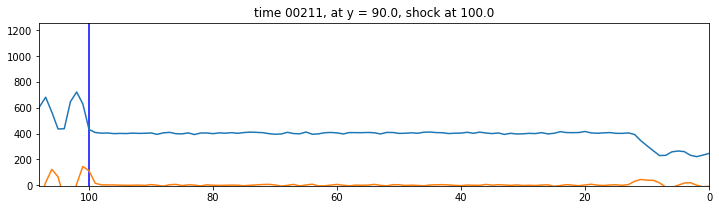

grad_v[ix_is] =  147.1353722957946


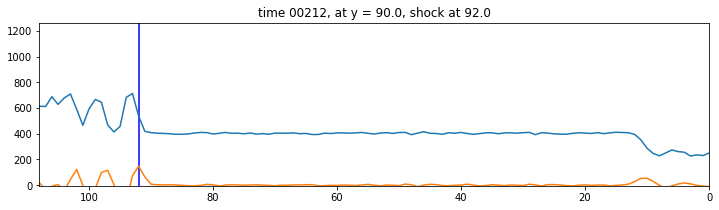

grad_v[ix_is] =  129.63261319382602


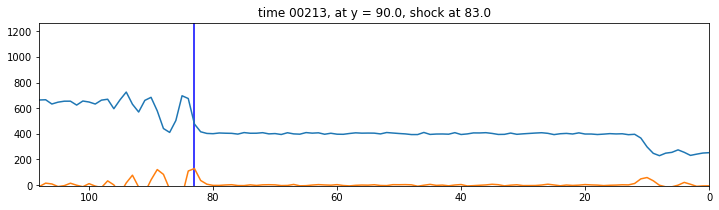

grad_v[ix_is] =  103.63620664410047


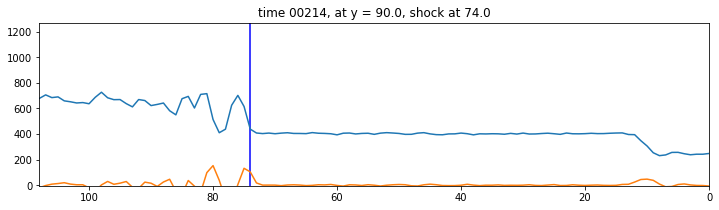

grad_v[ix_is] =  141.1527873147143


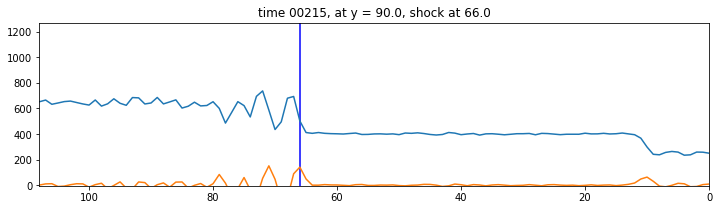

grad_v[ix_is] =  115.08739741003262


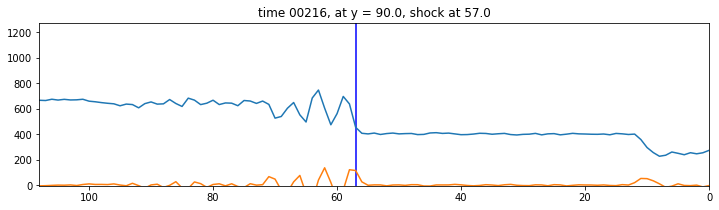

grad_v[ix_is] =  144.0802876940733


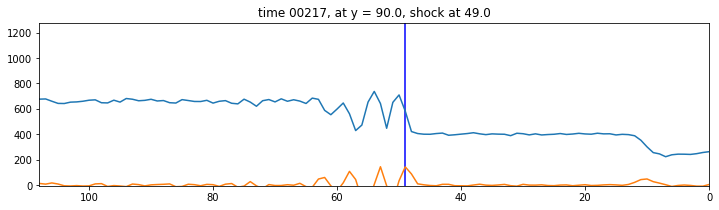

grad_v[ix_is] =  159.04890152919327


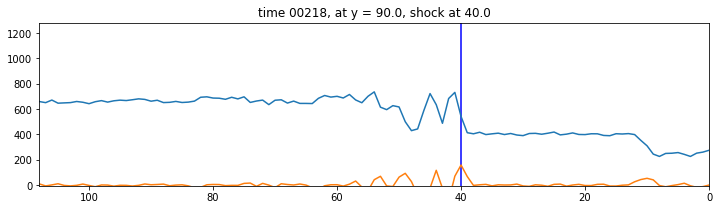

grad_v[ix_is] =  151.98034932939234


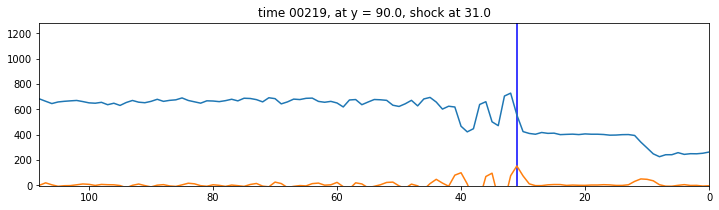

grad_v[ix_is] =  147.44844165981104


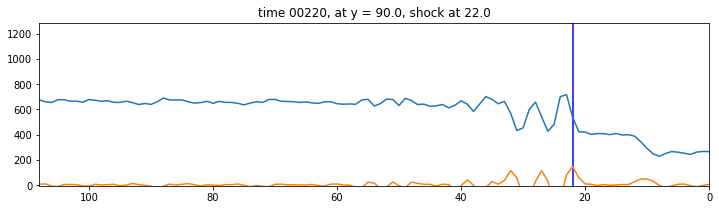

grad_v[ix_is] =  157.82673945317816


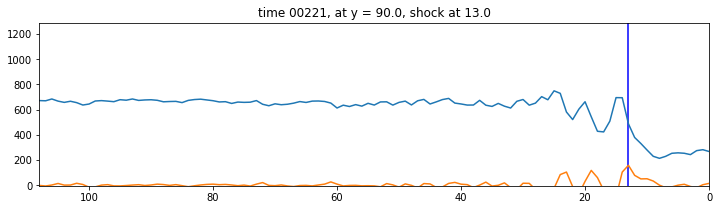

grad_v[ix_is] =  96.76316843784653


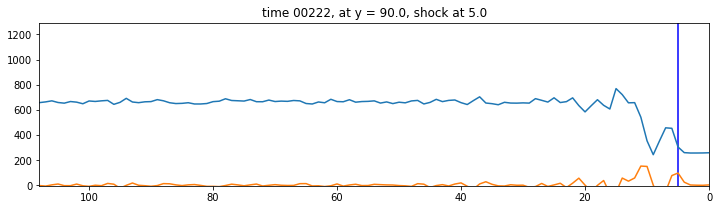

grad_v[ix_is] =  104.70963134991608


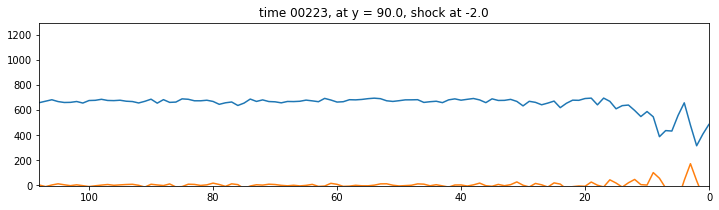

grad_v[ix_is] =  110.05505555747082


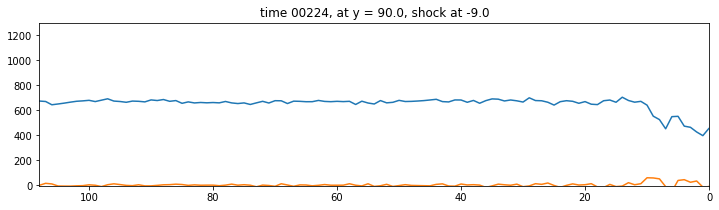

grad_v[ix_is] =  111.13298229970471


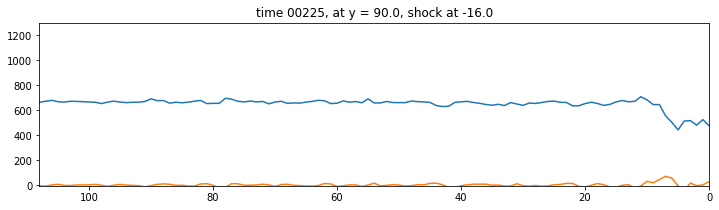

grad_v[ix_is] =  91.07136626674935


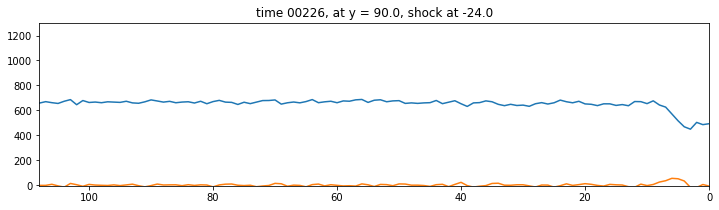

grad_v[ix_is] =  107.16428595783802


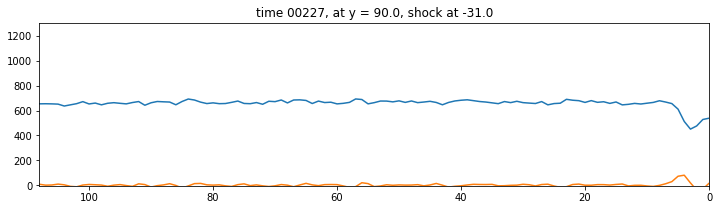

grad_v[ix_is] =  83.7870542779371


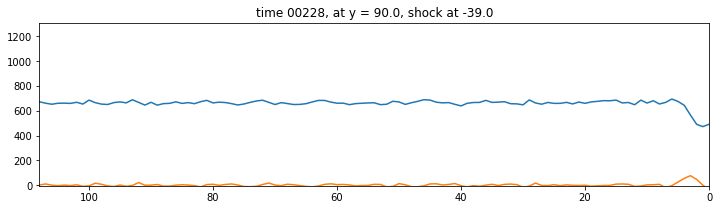

grad_v[ix_is] =  97.14263989309256


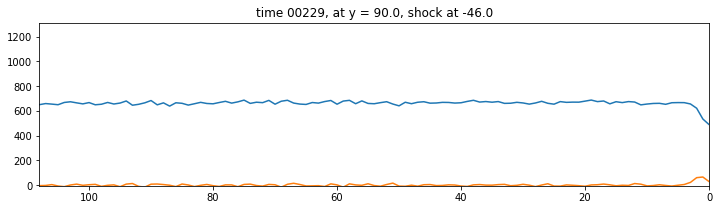

grad_v[ix_is] =  108.0782568828981


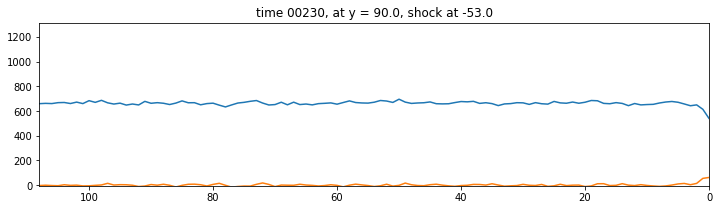

grad_v[ix_is] =  66.23288402791752


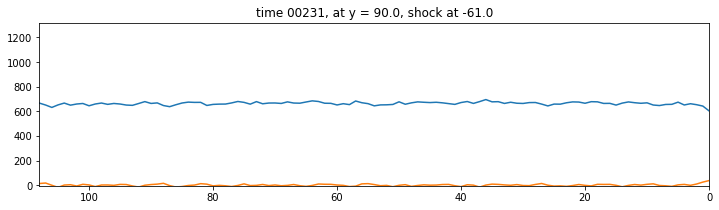

grad_v[ix_is] =  66.55295215627558


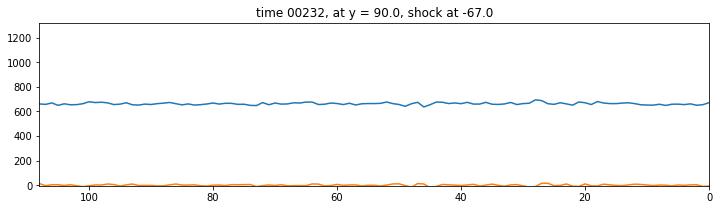

grad_v[ix_is] =  52.99813078032389
[-79. -78. -77. -76. -75. -74. -73. -72. -71. -70.]
grad_v[ix_is] =  43.33744691267361


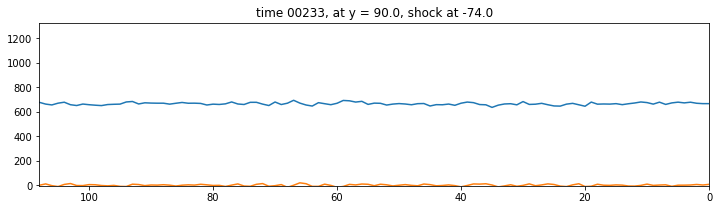

grad_v[ix_is] =  65.26443860828604


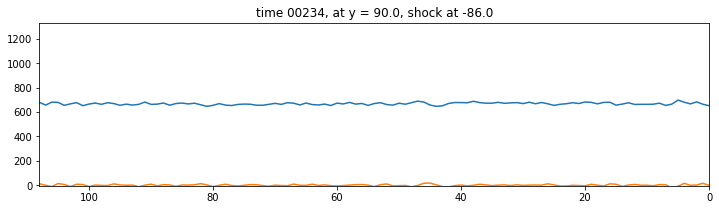

grad_v[ix_is] =  135.11263174710507


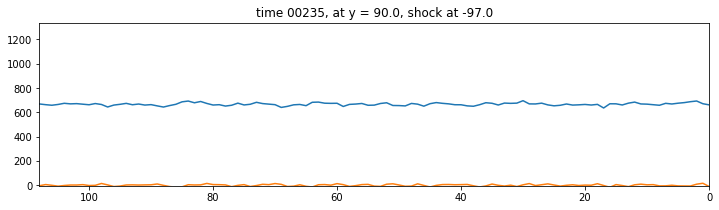

grad_v[ix_is] =  63.28881402858565
[-102. -101. -100.]


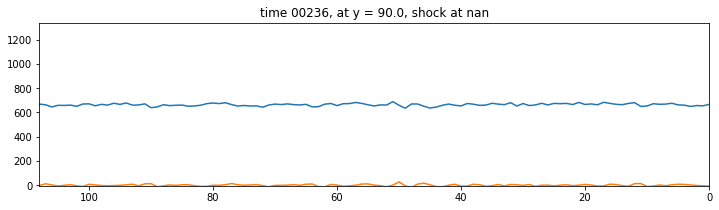

grad_v[ix_is] =  48.75938095229034


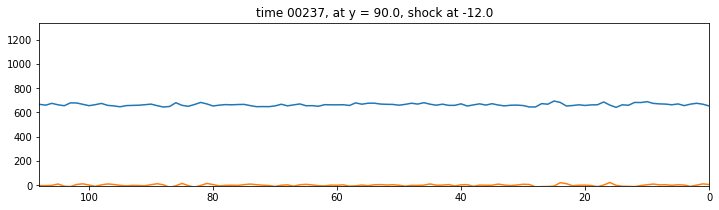

grad_v[ix_is] =  42.38912144364059
[-24. -23. -22. -21. -20. -19. -18. -17. -16. -15.]
grad_v[ix_is] =  7.469603025526084


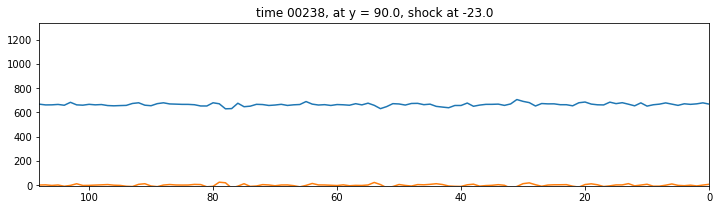

grad_v[ix_is] =  46.3812988150832
[-35. -34. -33. -32. -31. -30. -29. -28. -27. -26.]
grad_v[ix_is] =  11.943699480452807


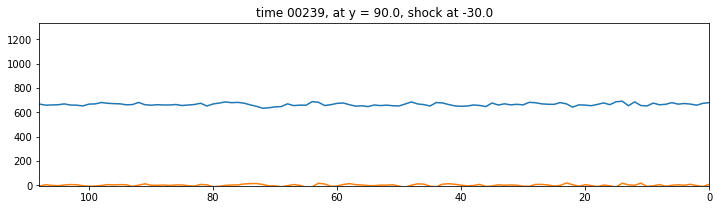

grad_v[ix_is] =  134.62111000291267


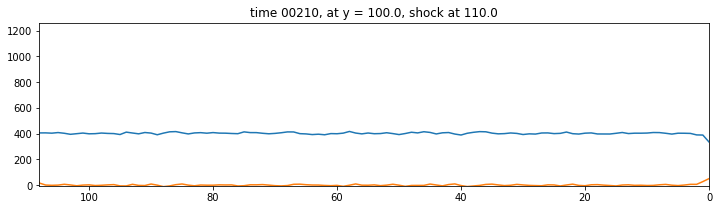

grad_v[ix_is] =  135.26461995791408


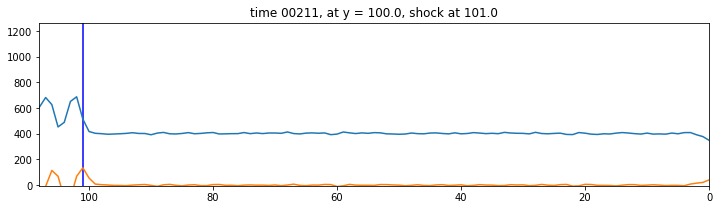

grad_v[ix_is] =  122.10324353926538


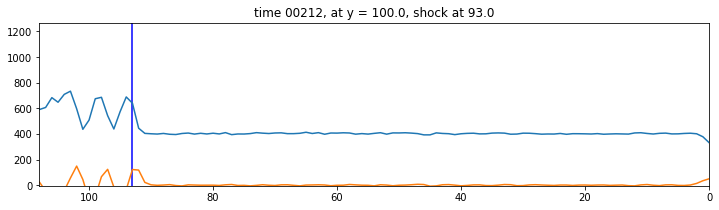

grad_v[ix_is] =  145.2951194068927


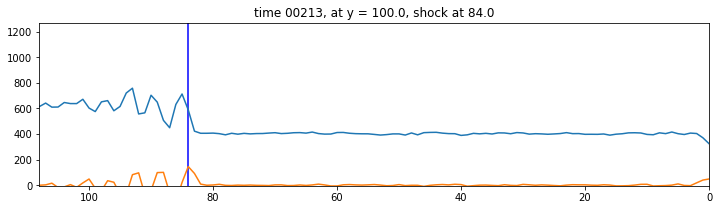

grad_v[ix_is] =  87.48350260510668


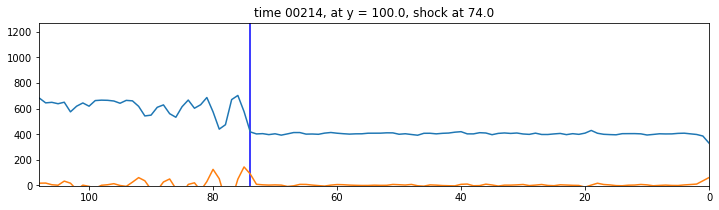

grad_v[ix_is] =  140.6550532169053


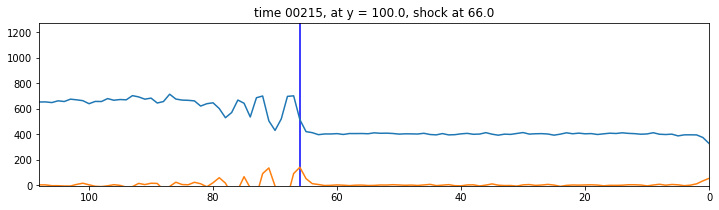

grad_v[ix_is] =  131.25533559117963


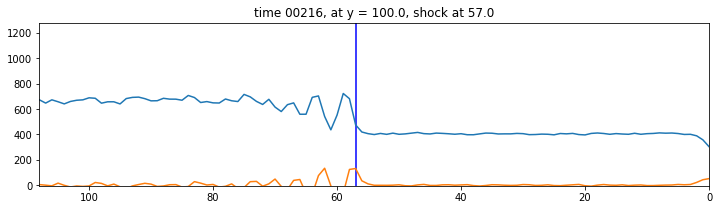

grad_v[ix_is] =  138.16957028817836


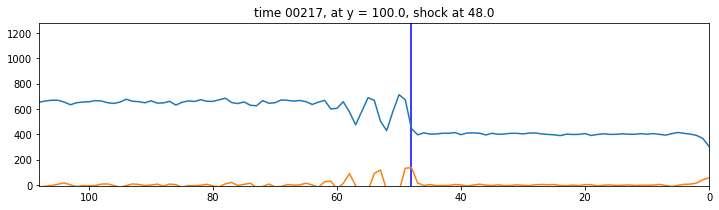

grad_v[ix_is] =  143.80991072427835


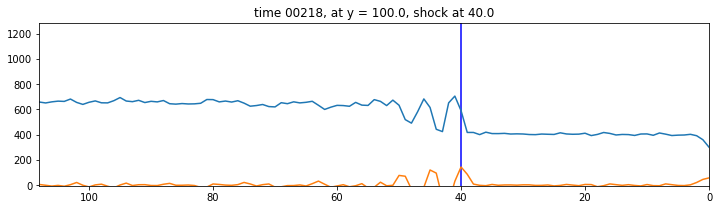

grad_v[ix_is] =  138.683240227587


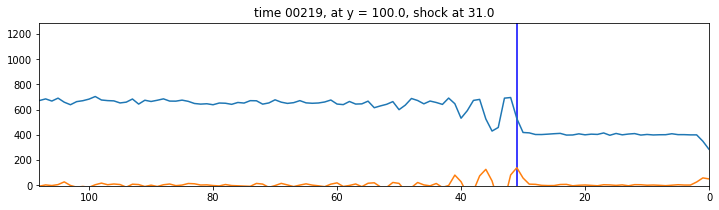

grad_v[ix_is] =  128.36772804140384


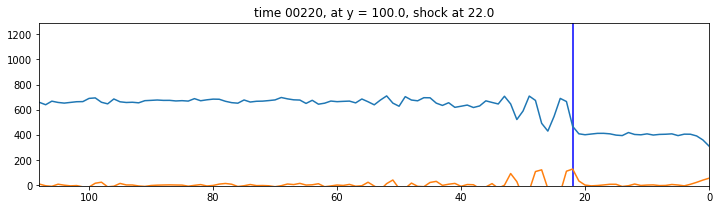

grad_v[ix_is] =  117.18375457452674


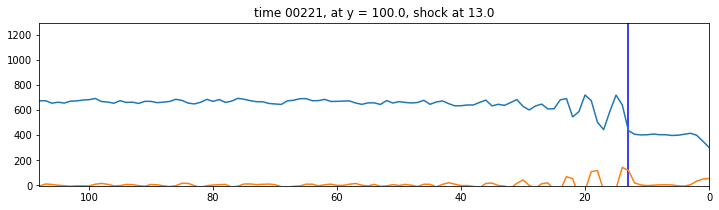

grad_v[ix_is] =  102.06525008939701


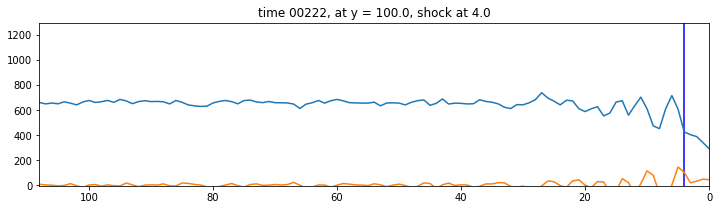

grad_v[ix_is] =  104.88362152364502


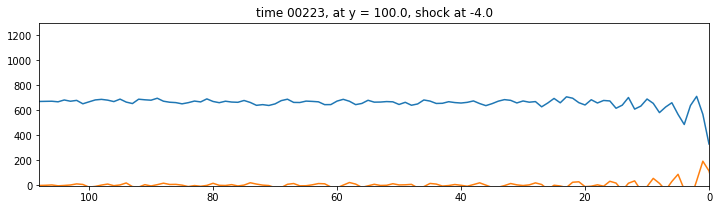

grad_v[ix_is] =  98.77172636432391


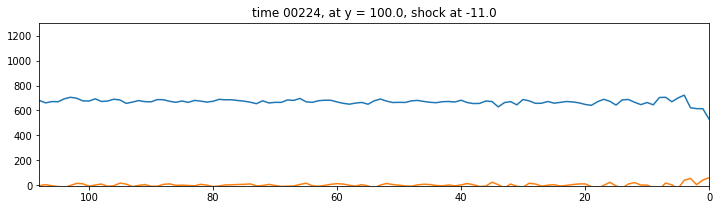

grad_v[ix_is] =  97.00133204385469


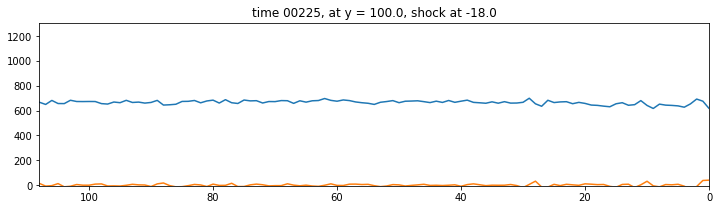

grad_v[ix_is] =  111.57894141706763


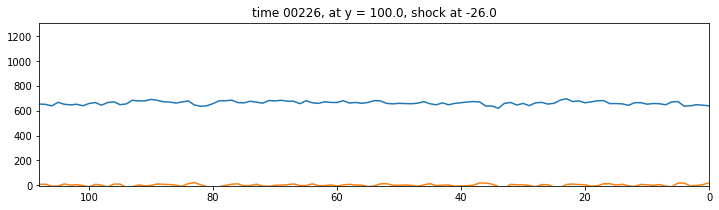

grad_v[ix_is] =  86.27956042741408


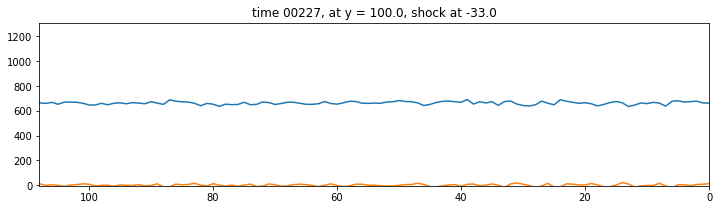

grad_v[ix_is] =  71.7751280578419


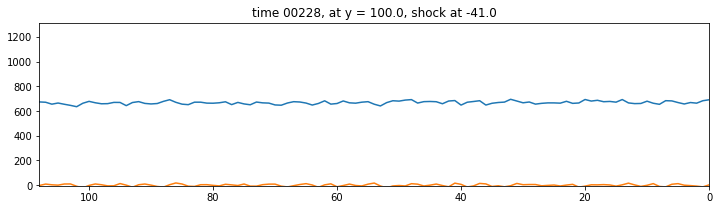

grad_v[ix_is] =  86.67883302384061


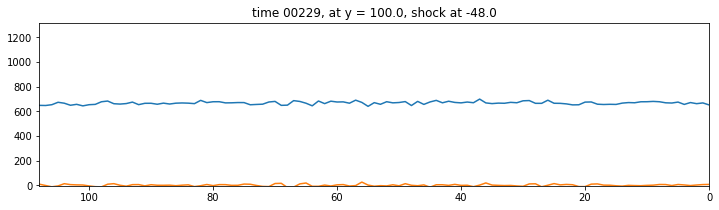

grad_v[ix_is] =  93.56875684504695


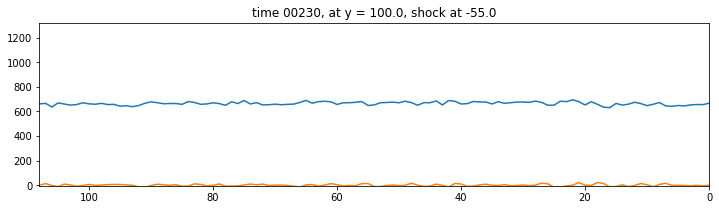

grad_v[ix_is] =  92.76708829731459


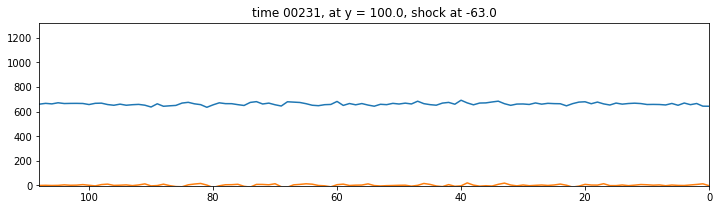

grad_v[ix_is] =  75.73848927850455


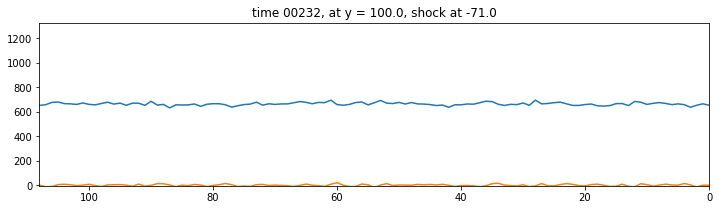

grad_v[ix_is] =  103.98022862741891


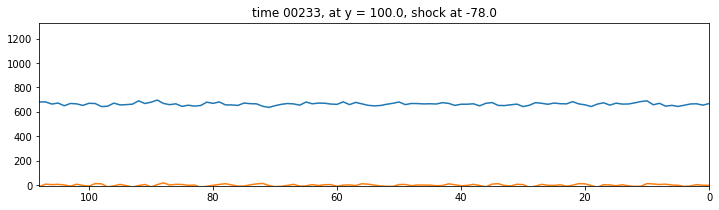

grad_v[ix_is] =  87.44855641364379


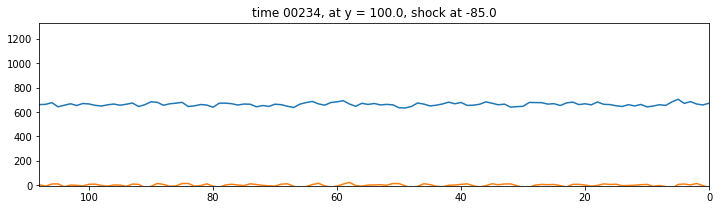

grad_v[ix_is] =  59.522802636717614


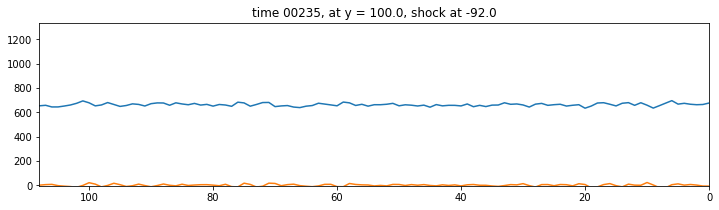

grad_v[ix_is] =  47.277037849991075


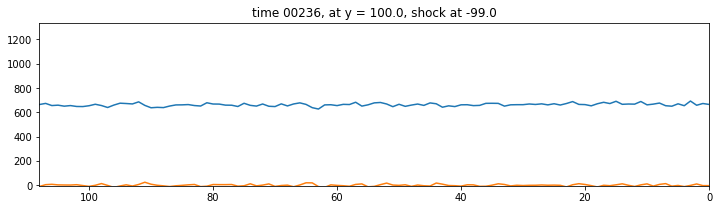

grad_v[ix_is] =  46.73037859737809
[-102.]


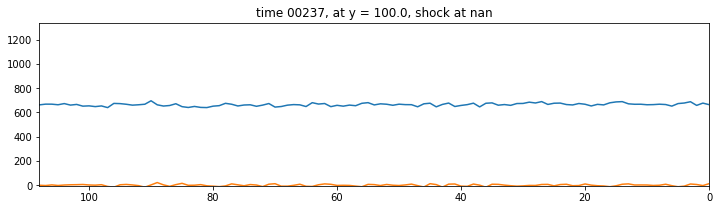

grad_v[ix_is] =  61.67209763267999


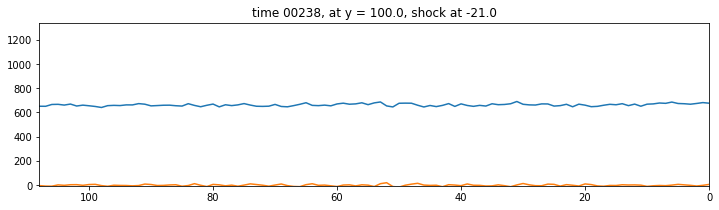

grad_v[ix_is] =  47.402464819905646
[-33. -32. -31. -30. -29. -28. -27. -26. -25. -24.]
grad_v[ix_is] =  21.103578602651595


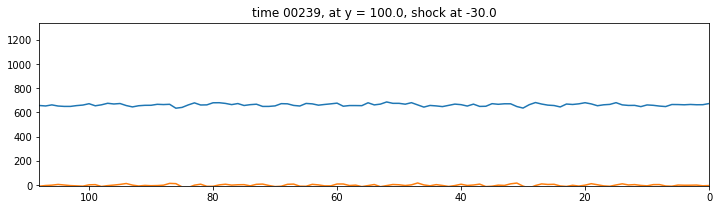

grad_v[ix_is] =  131.31164637712985


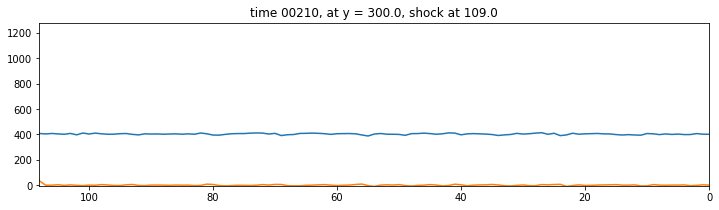

grad_v[ix_is] =  98.31905451526521


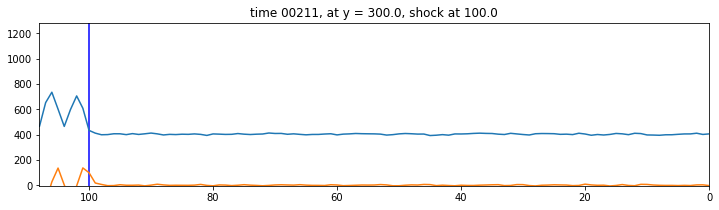

grad_v[ix_is] =  144.04477078519534


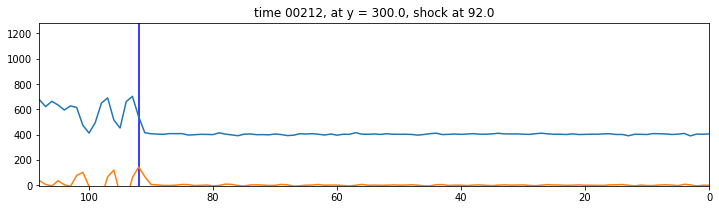

grad_v[ix_is] =  141.77133985344682


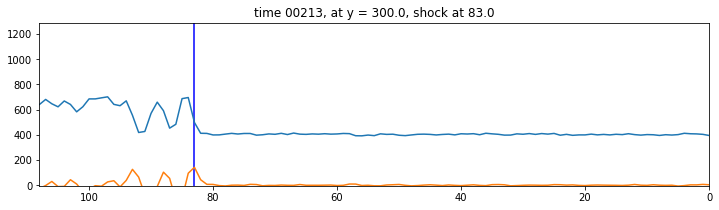

grad_v[ix_is] =  129.84929153380386


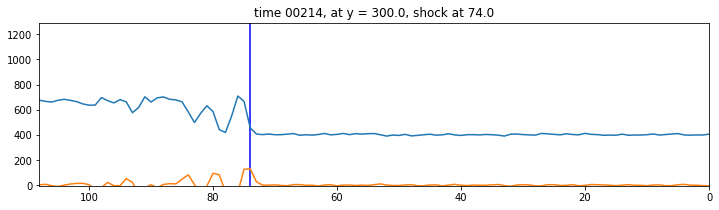

grad_v[ix_is] =  90.0835747463768


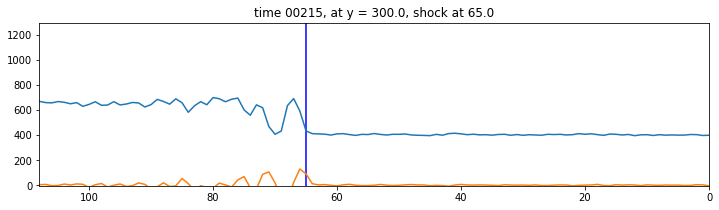

grad_v[ix_is] =  135.28729662561744


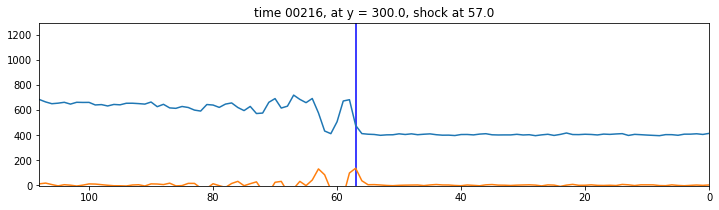

grad_v[ix_is] =  105.42736466063533


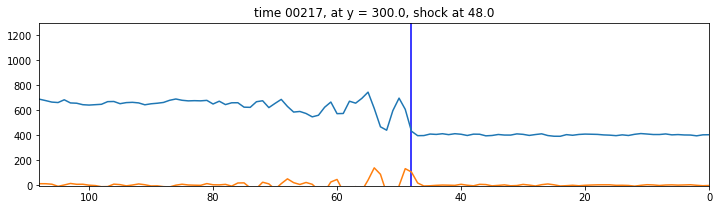

grad_v[ix_is] =  143.72843918075827


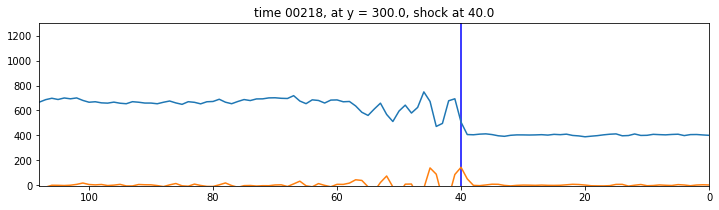

grad_v[ix_is] =  119.47835898152599


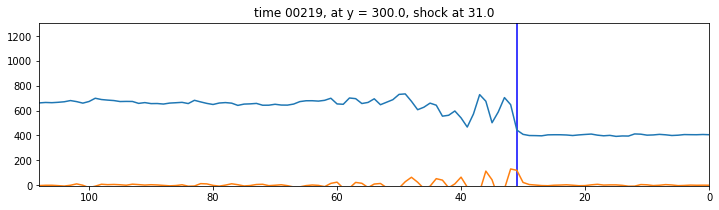

grad_v[ix_is] =  144.17097719466253


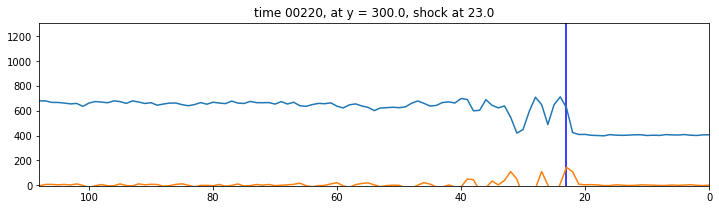

grad_v[ix_is] =  150.78435806171234


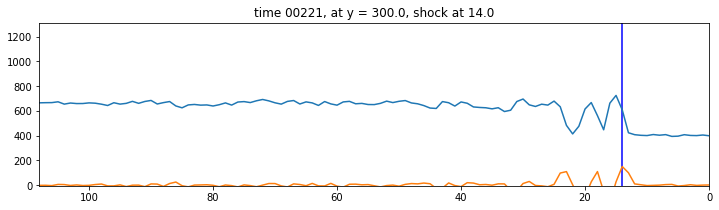

grad_v[ix_is] =  140.66463615633097


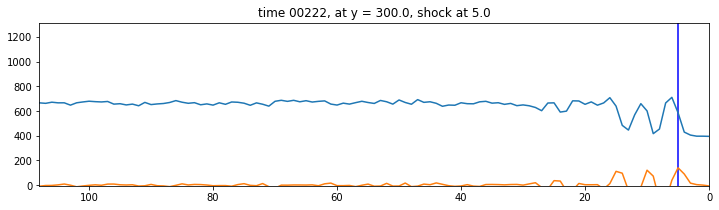

grad_v[ix_is] =  141.38548430032432


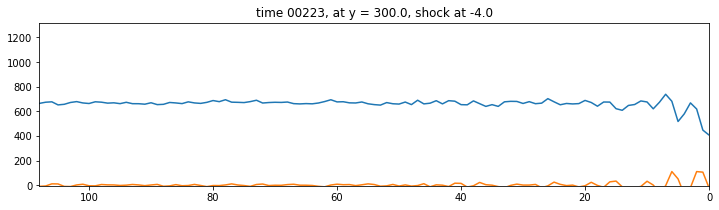

grad_v[ix_is] =  115.41279997603735


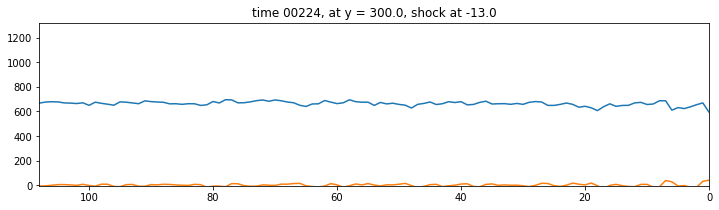

grad_v[ix_is] =  146.8869164926738


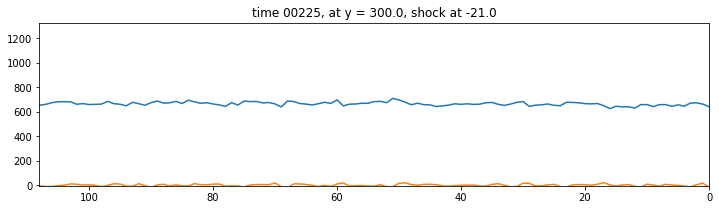

grad_v[ix_is] =  142.32015115787428


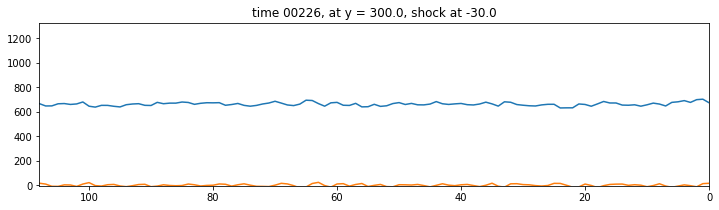

grad_v[ix_is] =  132.31136903725485


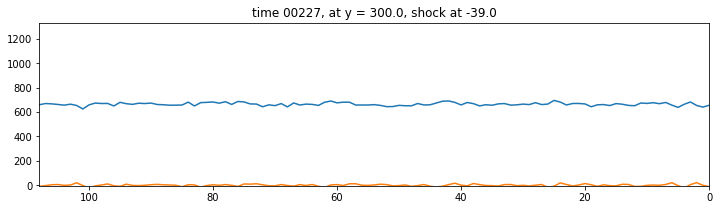

grad_v[ix_is] =  129.952587837549


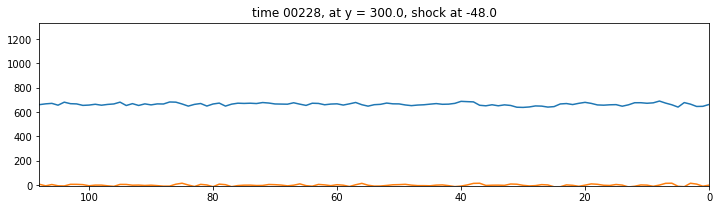

grad_v[ix_is] =  146.8782019209478


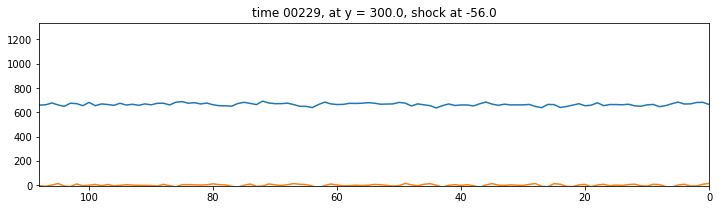

grad_v[ix_is] =  143.72858682408423


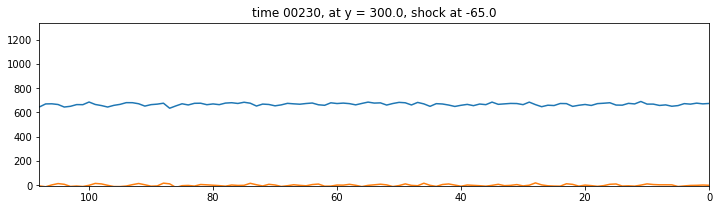

grad_v[ix_is] =  153.73733688107467


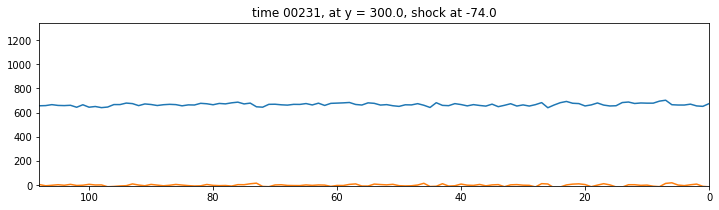

grad_v[ix_is] =  147.36266988632698


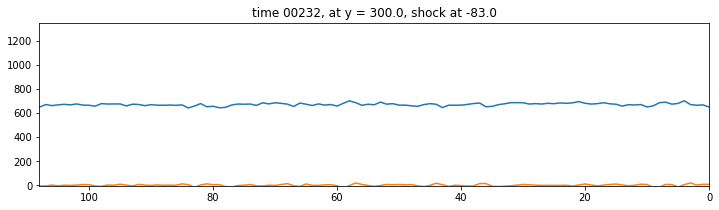

grad_v[ix_is] =  138.79516771864417


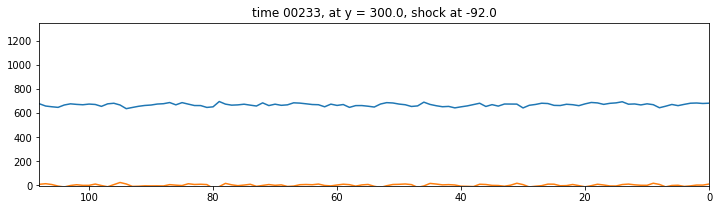

grad_v[ix_is] =  126.54975259632903


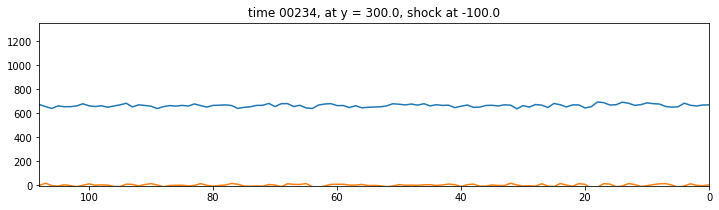

grad_v[ix_is] =  104.93906385239228
[]


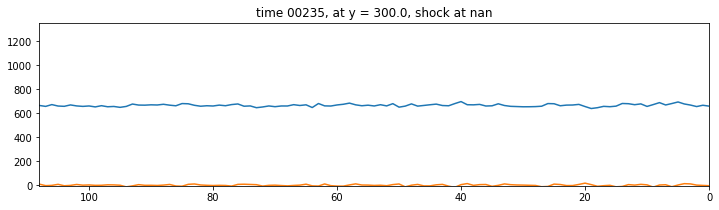

grad_v[ix_is] =  43.00475957401892


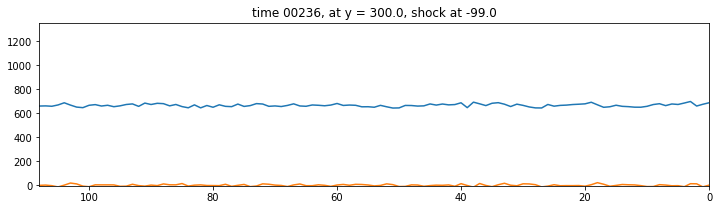

grad_v[ix_is] =  43.05555106191207
[-102.]


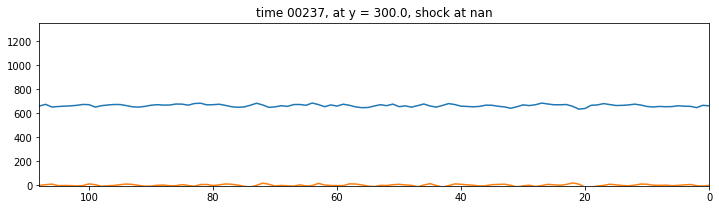

grad_v[ix_is] =  45.76497363882845


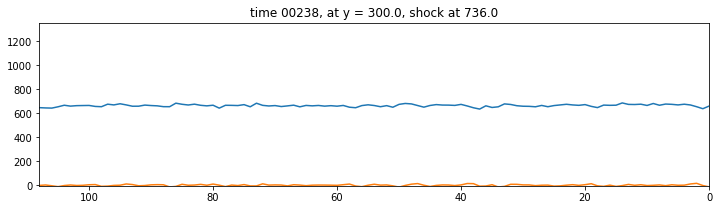

grad_v[ix_is] =  40.03080894837069


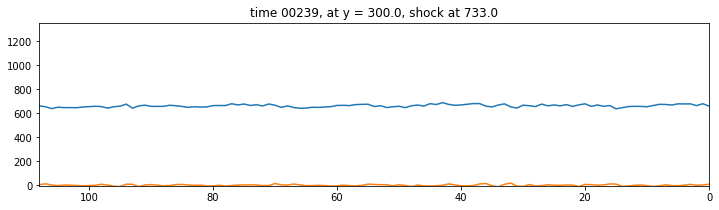

TypeError: list indices must be integers or slices, not str

In [20]:
'''''''''''''''''''''''
Check the ip shock detection
'''''''''''''''''''''''

verbose = False
rcParams["figure.figsize"] = [12,3]

# dummy_time:
time = '00210'

list_data_y = stored_data[time]['Vx']['(xy) plane']
# list_data_y = ['y = -0.0']

for str_y in list_data_y:

    t = []
    pos = []
                              
    for time in sorted(stored_data):
        
        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue

        Vx_xy = stored_data[time]['Vx']['(xy) plane']
        Vy_xy = stored_data[time]['Vy']['(xy) plane']
        Vz_xy = stored_data[time]['Vz']['(xy) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (str_y == 'y = -0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = np.array(Vx_xy[str_y])
        Vy = np.array(Vy_xy[str_y])
        Vz = np.array(Vz_xy[str_y])

        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V, verbose=verbose)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose=verbose, info=info)
        j = 0
        while absurdity['absurd']:
            
#             v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)
#             plt.axvline(x_is, color='blue')
#             plt.plot(x, v_slice)
#             plt.plot(x, np.gradient(v_slice))
#             plt.xlim([-100, 250])
#             plt.ylim([-5, 2*np.nanmean(v_slice)])
#             plt.title(f'time {time}, at {str_y}, shock at {x_is}: ABSURD')
#             plt.show()
                        
            test = absurdity['test']
            print(x[test])
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            
#             def debug():
#                 set_trace()
#                 absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
#                 return

#             if time=='00217':
#                 debug()

            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
#                 break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
              pass
#             break

        v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)

        plt.axvline(x_is, color='blue')
        plt.plot(x, v_slice)
        plt.plot(x, np.gradient(v_slice))
        plt.xlim([-100, 250])
        plt.ylim([-5, 2*np.nanmean(v_slice)])
        plt.title(f'time {time}, at {str_y}, shock at {x_is}')
        ax = plt.gca()
        ax.invert_xaxis()
        ax.set_xlim([108, 0])
        plt.show()

list_data_z = stored_data[time]['Vx']['(xz) plane']

for str_z in list_data_z:

    t = []
    pos = []
                              
    for time in sorted(stored_data):
        
        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue

        Vx_xz = stored_data[time]['Vx']['(xz) plane']
        Vy_xz = stored_data[time]['Vy']['(xz) plane']
        Vz_xz = stored_data[time]['Vz']['(xz) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None

        Vx = np.array(Vx_xz[str_z])
        Vy = np.array(Vy_xz[str_z])
        Vz = np.array(Vz_xz[str_z])

        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V, verbose=verbose)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose=verbose, info=info)
        j = 0
        while absurdity['absurd']:
            
#             v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)
#             plt.axvline(x_is, color='blue')
#             plt.plot(x, v_slice)
#             plt.plot(x, np.gradient(v_slice))
#             plt.xlim([-100, 250])
#             plt.ylim([-5, 2*np.nanmean(v_slice)])
#             plt.title(f'time {time}, at {str_z}, shock at {x_is}: ABSURD')
#             plt.show()            
            
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break

        v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)

        plt.axvline(x_is, color='blue')
        plt.plot(x, v_slice)
        plt.plot(x, np.gradient(v_slice))
        plt.xlim([-100, 250])
        plt.ylim([-5, 2*np.nanmean(v_slice)])
        plt.title(f'time {time}, at {str_z}, shock at {x_is}')
        ax = plt.gca()
        ax.invert_xaxis()
        plt.show()


In [18]:
time

'00234'